# Figure 5: Spatial correspondence between C-SALE maps and cerebellar parcellations

**Comparisions were made to the Multi-Domain Task Battery [King et al. 2019] and the mid-granularity symmetrical hierarchical atlas of [Nettekoven et al. 2024] for the main figure.**

**We also compared out maps to cerebellar gradients [Guell et al. 2018], resting-state networks [Buckner et al. 2011], a cortical-subcortical network parcellation (Ji et al. (2019), and a winner-takes all meta-analatic atlas [Van Overwalle et al. 2023].**

**We also considered structural parcellations, specifically cerebellar lobules. We compared maps both against a deterministic and probabilistic segmentation.**

Source: https://github.com/DiedrichsenLab/cerebellar_atlases/tree/master/Diedrichsen_2009

Note that there are two primary types of comparisons:
1. Continuous C-SALE z-maps vs. continous parcellations;
2. Binary C-SALE clusters (thresholded) vs. binary parcellations. Most comparisons are of this type.

For the former, we calculate spatial correlations. For the latter, we calculate spatial overlap or average z-values per parcel of the target map.
For both types of comparisons, we have used variograms to calculate 1,000 surrogates of our z-maps . By then comparing the actual spatial correspondence (correlation, overlap, or mean-z) relative to that of the surrogate-target correspondence distribution, we can find whether the relationship is significant after accounting for spatial autocorrelation. All p-values were corrected for multiple comparison (FDR).

We also compared thresholded C-SALE maps against the cerebellar gradients of Guell et al. (2018). To do this, we used the LittleBrain toolbox (Guell et al. 2019)(https://github.com/xaviergp/littlebrain/blob/master/LittleBrain_v3_Manual.pdf). We choose to visualize the loadings of our clusters onto the principal and secondary gradients alongside color-coding for the Buckner et al. (2011) resting-state atlas, to provide complementary perspectives from gradients/ network-based approaches. 

In [1]:
import os
import sys

import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap
import matplotlib.cm as cm
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering
import scipy
from scipy.cluster.hierarchy import dendrogram
import statsmodels.stats.multitest
import SUITPy
import nibabel
import nilearn
import nilearn.plotting
from nilearn.image import resample_to_img
from tqdm import tqdm
import re
import SUITPy

import warnings
warnings.filterwarnings("ignore")

# Define base directory of the project which is the parent of scripts folder
BASE_DIR = os.path.abspath('../..')
sys.path.append(os.path.join(BASE_DIR, 'scripts'))

import utils

# Defines input and output paths.
INPUT_DIR = os.path.join(BASE_DIR, 'input')
OUTPUT_DIR = os.path.join(BASE_DIR, 'output')
# create a diectory for all correlations, mean z-values, and p-vakues
CORR_DIR = os.path.join(OUTPUT_DIR, 'corr_parcellations')

# Set up font style
plt.rcParams["font.family"] = "Asana Math"
plt.rcParams["font.size"] = 14
plt.rcParams["figure.dpi"] = 300

In [2]:
# Function to extract and map column names
def map_column_names(col_name):
    # Extract the part after the last '/' character
    subdomain = col_name.split('/')[-1]
    # Map using subdomain_labels
    return utils.bd_labels.get(subdomain, subdomain)

## S13. Create a manual label for the LittleBrain Gradients figure.
**These maps were made externally by uploading the thresholded C-SALE z-maps to the LittleBrain Toolbox (Guell et al. 2019): https://xaviergp.github.io/littlebrain/.**

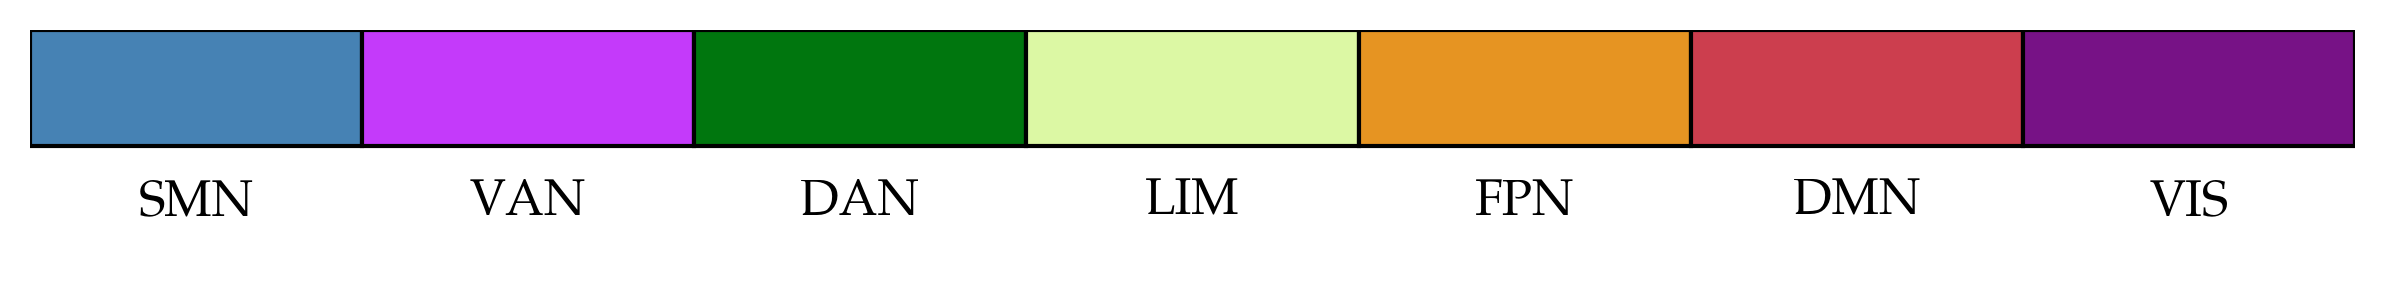

In [3]:
# Define Network Labels corresponding to the Buckner et al. 2011 resting-state networks (based on Guell et al. 2018 - Figure 1B).
# Use abbreviated network names for the labels
networks = [
    ("SMN", "#4682b4"),  # Blue - Somatomotor Network
    ("VAN", "#c43afa"),  # Bright Purple - Ventral Attention Network
    ("DAN", "#00760e"),  # Green - Dorsal Attention Network
    ("LIM", "#dcf8a4"),  # Light Yellow - Limbic Network
    ("FPN", "#e69422"),  # Orange - Frontoparietal Network
    ("DMN", "#cc3e4e"),  # Red - Default-Mode Network
    ("VIS", "#771286")   # Darker Purple (Magenta) - Visual Network
]
# Create a new figure.
fig, ax = plt.subplots(figsize=(10, 1))
# Hide axes
ax.axis('off')
# Create legend
for i, (label, color) in enumerate(networks):
    rect = mpatches.Rectangle((i, 0), 1, 1, facecolor=color, edgecolor="black")
    ax.add_patch(rect)
    ax.text(i + 0.5, -0.5, label, ha="center", va="center", fontsize=12)
# Set limits
ax.set_xlim(0, len(networks))
ax.set_ylim(-1, 1)
plt.show()

# First, we compare continuous maps

## 5a. Run variogram-based correlation between an example Z map and the MDTB maps

### Resample the parcellation

In [4]:
all_files = glob.glob(os.path.join(INPUT_DIR, 'cerebellar_atlases', 'King_2019', 'con-MDTB*.nii'))
# select tasks based on Fig. 1 of the Nature Neuroscience paper.
sel_tasks = ['VerbGeneration', 'ActionObservation', 'TheoryOfMind', 'VisualSearchMedium', 
             'Object2Back+', 'SadFaces', 'FingerSequence', 'Rest',
             'AnimatedMovie', 'LandscapeMovie', 'FingerSimple', 'SpatialImagery',
             'BiologicalMotion', 'MentalRotationMedium', 'SpatialMapMedium', 'Math']
sel_tasks_print_names = ['Verb Generation', 'Action Observation', 'Theory of Mind', 'Visual Search',
                         'Object 2-back', 'Sad Faces', 'Finger Sequence', 'Rest',
                         'Animated Movie', 'Landscape Movie', 'Finger Simple', 'Spatial Imagery',
                         'Biological Motion', 'Mental Rotation', 'Spatial Map', 'Math']
# load deformation needed for transforming SUIT to MNI
deformation = os.path.join(INPUT_DIR, 'def_suit2mni.nii')
proper_mask_2mm = nibabel.load(os.path.join(INPUT_DIR, 'maps', 'D2009_MNI_2mm.nii.gz'))
sel_maps = {}
sel_maps_mni = {}
for task in sel_tasks:
    print(task)
    for map_path in all_files:
        if task in map_path:
            break
    sel_maps[task] = map_path
    # Look for _spce-MNI2mm suffixes
    map_mni_2mm_path = map_path.replace('space-SUIT', 'space-MNI2mm')
    # Check if the resampled MNI 2mm map already exists
    if os.path.exists(map_mni_2mm_path):
        print(f"{map_mni_2mm_path} already exists, loading this file...")
        sel_maps_mni[task] = nibabel.load(map_mni_2mm_path)
    else:
        map_mni = SUITPy.reslice.reslice_image(map_path, deformation)
        map_mni_2mm = nilearn.image.resample_to_img(map_mni, proper_mask_2mm)
        sel_maps_mni[task] = map_mni_2mm
        # Save the new, MNI 2mm resliced map
        map_mni_2mm.to_filename(map_mni_2mm_path)
        print(f"Saved new file: {map_mni_2mm_path}")

VerbGeneration
/data/project/cerebellum_ale/public/input/cerebellar_atlases/King_2019/con-MDTB27VerbGeneration_space-MNI2mm.nii already exists, loading this file...
ActionObservation
/data/project/cerebellum_ale/public/input/cerebellar_atlases/King_2019/con-MDTB07ActionObservation_space-MNI2mm.nii already exists, loading this file...
TheoryOfMind
/data/project/cerebellum_ale/public/input/cerebellar_atlases/King_2019/con-MDTB06TheoryOfMind_space-MNI2mm.nii already exists, loading this file...
VisualSearchMedium
/data/project/cerebellum_ale/public/input/cerebellar_atlases/King_2019/con-MDTB30VisualSearchMedium_space-MNI2mm.nii already exists, loading this file...
Object2Back+
/data/project/cerebellum_ale/public/input/cerebellar_atlases/King_2019/con-MDTB23Object2Back+_space-MNI2mm.nii already exists, loading this file...
SadFaces
/data/project/cerebellum_ale/public/input/cerebellar_atlases/King_2019/con-MDTB14SadFaces_space-MNI2mm.nii already exists, loading this file...
FingerSequence
/

### Run variogram-based correlation between an example Z map and the MDTB maps

In [5]:
if os.path.exists(os.path.join(CORR_DIR, 'z_mdtb_posneg_r.csv')) and os.path.exists(os.path.join(CORR_DIR, 'z_mdtb_posneg_p.csv')):
    # Load correlations and p-values from csv
    r = pd.read_csv(os.path.join(CORR_DIR, 'z_mdtb_posneg_r.csv'), index_col=0)
    p = pd.read_csv(os.path.join(CORR_DIR, 'z_mdtb_posneg_p.csv'), index_col=0)
    # Display the resulting dataframes
    print(r)
    print(p)
else: 
    mask_data = proper_mask_2mm.get_fdata().astype('bool')
    # Initialize dataframes
    r = pd.DataFrame(index=sel_tasks, dtype=float)
    p = pd.DataFrame(index=sel_tasks, dtype=float)
    surrogates_paths = sorted(glob.glob(os.path.join(OUTPUT_DIR,
        'SALE/*/*/uncorr_z_2mm_mask-D2009_MNI_surrogates-variogram_n-1000.npy')
    ))
    for surrogates_path in tqdm(surrogates_paths):
        # Extract subbd using regex
        subbd_match = re.search(r'SALE/(.*?)/(.*?)/', surrogates_path)
        if subbd_match:
            subbd = subbd_match.group(2)
        else:
            print(f"Failed to parse subbd from path: {surrogates_path}")
            continue
        # Load z-map and mask it
        z_2mm = os.path.join(os.path.dirname(surrogates_path), 'uncorr_z_2mm.nii.gz')
        z_2mm_masked = nibabel.load(z_2mm).get_fdata()[mask_data]
        # Load surrogates
        surrogates = np.load(surrogates_path)
        # Calculate r and p between current z-map and every task
        for task in tqdm(sel_tasks):
            target_masked = sel_maps_mni[task].get_fdata()[mask_data]
            r.loc[task, subbd] = scipy.stats.pearsonr(z_2mm_masked, target_masked).statistic
            # Create a null-distribution of correlations
            null_dist = [scipy.stats.pearsonr(surrogates[i, :], target_masked).statistic for i in range(1000)]
            # and calculate target-correlation p-values based on this distribution
            p.loc[task, subbd] = (np.abs(null_dist) >= np.abs(r.loc[task, subbd])).mean()
    # Display the resulting dataframes
    print(r)
    print(p)
    # Save correlations and p-values to csv
    r.to_csv(os.path.join(CORR_DIR, 'z_mdtb_posneg_r.csv'))
    p.to_csv(os.path.join(CORR_DIR, 'z_mdtb_posneg_p.csv'))

100%|█████████████████████████████████████████████████████████████████████████████████| 38/38 [06:05<00:00,  9.63s/it]

                      Action.Execution.Speech  Action.Execution  \
VerbGeneration                       0.005312          0.026220   
ActionObservation                    0.104597          0.064991   
TheoryOfMind                        -0.070021         -0.152577   
VisualSearchMedium                   0.048246         -0.168844   
Object2Back+                         0.026111         -0.064378   
SadFaces                            -0.129721         -0.056104   
FingerSequence                       0.239468          0.463230   
Rest                                -0.167520         -0.104136   
AnimatedMovie                       -0.098850         -0.231292   
LandscapeMovie                      -0.249826         -0.256768   
FingerSimple                        -0.139110         -0.026604   
SpatialImagery                      -0.213687         -0.124597   
BiologicalMotion                    -0.210797         -0.209893   
MentalRotationMedium                 0.039685          0.05528

### 5a. Plot and hierarchically cluster

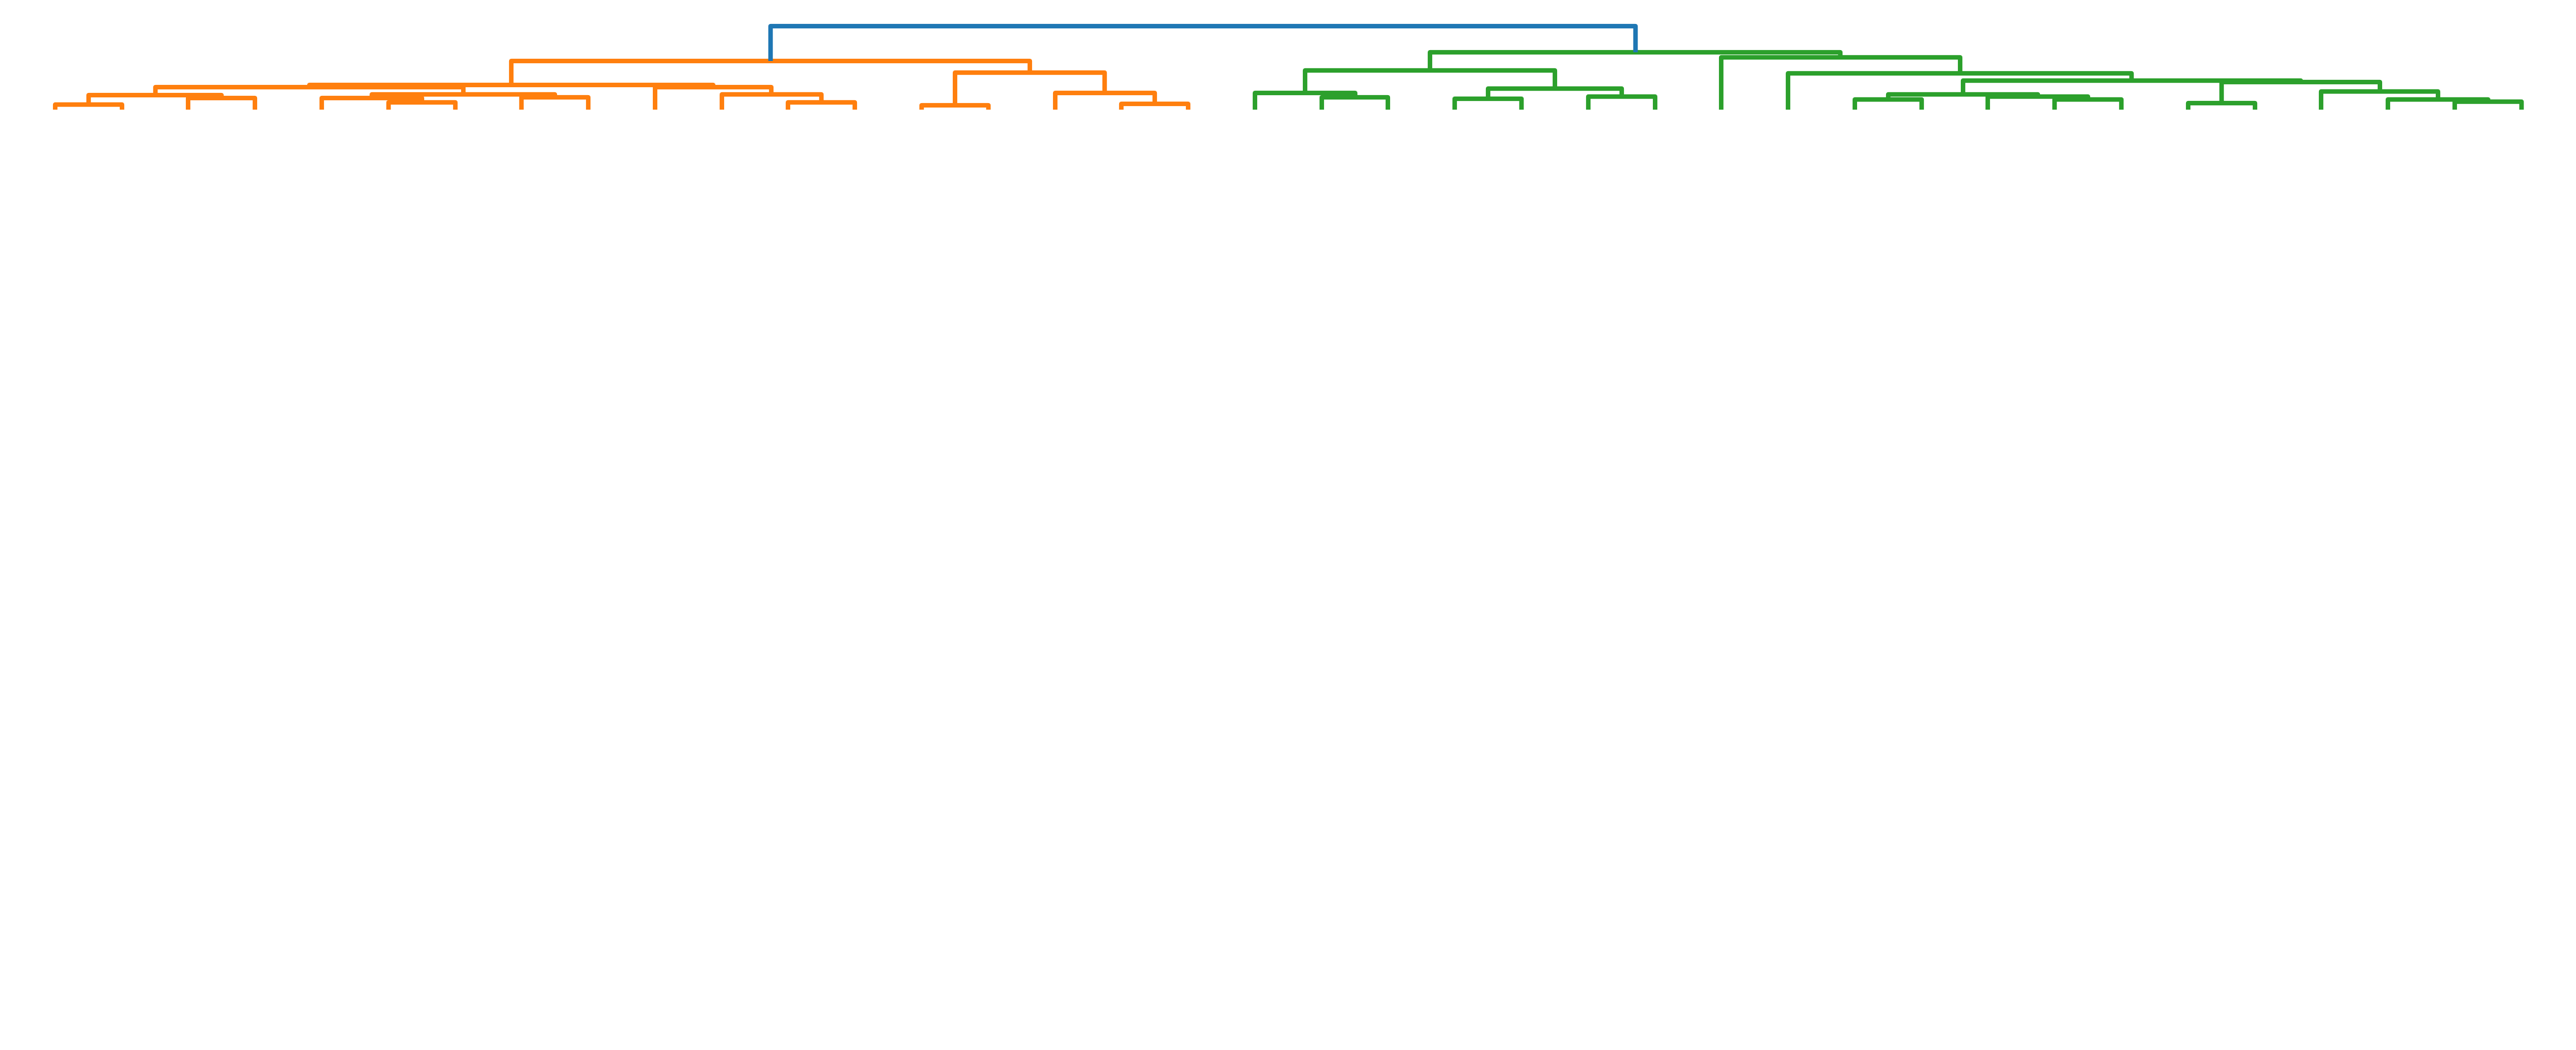

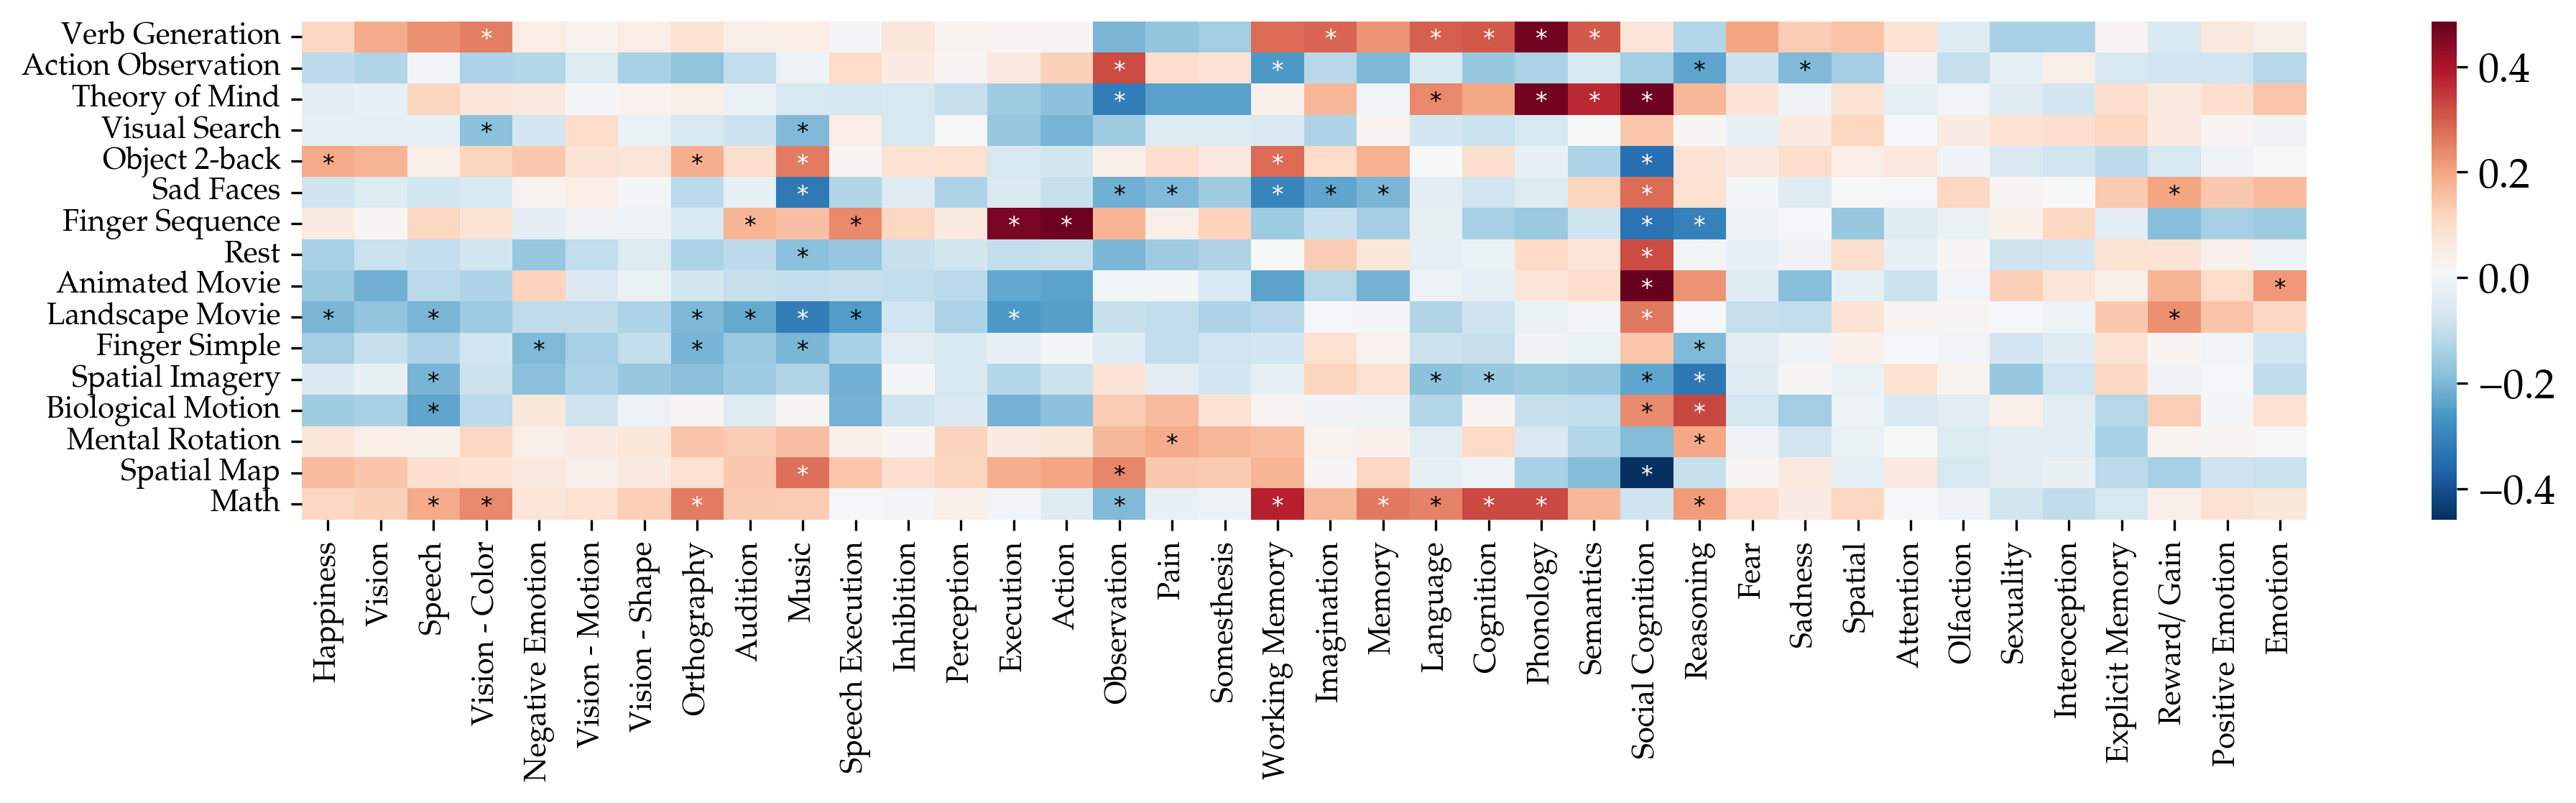

In [6]:
# Perform hierarchical clustering and plot dendrogram
fig, ax = plt.subplots(figsize=(15, 6))
model, dendro, leaf_order = utils.hierarchical_clustering(r.T, no_plot=False, ax=ax)
ax.set_ylim([-25, ax.get_ylim()[1]])
ax.axis('off')

# reorder the original data
r_reordered = r.iloc[:, leaf_order]

# FDR correction
sig_fdr, _ = statsmodels.stats.multitest.fdrcorrection(p.values.flatten())
# reshape 
sig_fdr = pd.DataFrame(sig_fdr.reshape(p.shape), index=p.index, columns=p.columns)
# reorder
sig_fdr = sig_fdr.iloc[:, leaf_order]

# plot the reordered data
fig, ax = plt.subplots(figsize=(15, 3))
sns.heatmap(r_reordered, cmap='RdBu_r',linecolor='.8', ax=ax)
ax.set_xticks(np.arange(r.shape[1])+0.5)
ax.set_xticklabels(utils.bd_labels.loc[r_reordered.columns].values, rotation=90, horizontalalignment='center', fontsize=10)
ax.set_yticks(np.arange(r.shape[0])+0.5)
ax.set_yticklabels(sel_tasks_print_names, rotation=0, fontsize=10)
ax.set_ylabel('')

# add the * layer
for x, col in enumerate(r_reordered.columns):
    for y, row in enumerate(r_reordered.index):
        if sig_fdr.loc[row, col]: # Use the FDR-corrected p-values.
            text = r'$*$'
            # Conditional color based on the value of r
            text_color = 'white' if r_reordered.loc[row, col] > 0.25 or r_reordered.loc[row, col] < -0.25  else 'black'
            ax.text(x+0.5, y+0.6,
                    text, 
                    fontsize=8,
                    color=text_color,
                    horizontalalignment='center', 
                    verticalalignment='center')

## S12b. Probabilistic lobular segmentation of Diedrichsen et al. (2009).

In [7]:
# Load data
D2009p = nibabel.load(os.path.join(INPUT_DIR, 'cerebellar_atlases', 'Diedrichsen_2009', 'atl-Anatom_space-MNI_probseg.nii'))

### Resample the parcellation

In [8]:
D2009p_data = D2009p.get_fdata()
print(D2009p_data.shape)  # Should print (x, y, z, n)

(153, 103, 84, 34)


#### Optional: visualize statmaps per lobule.

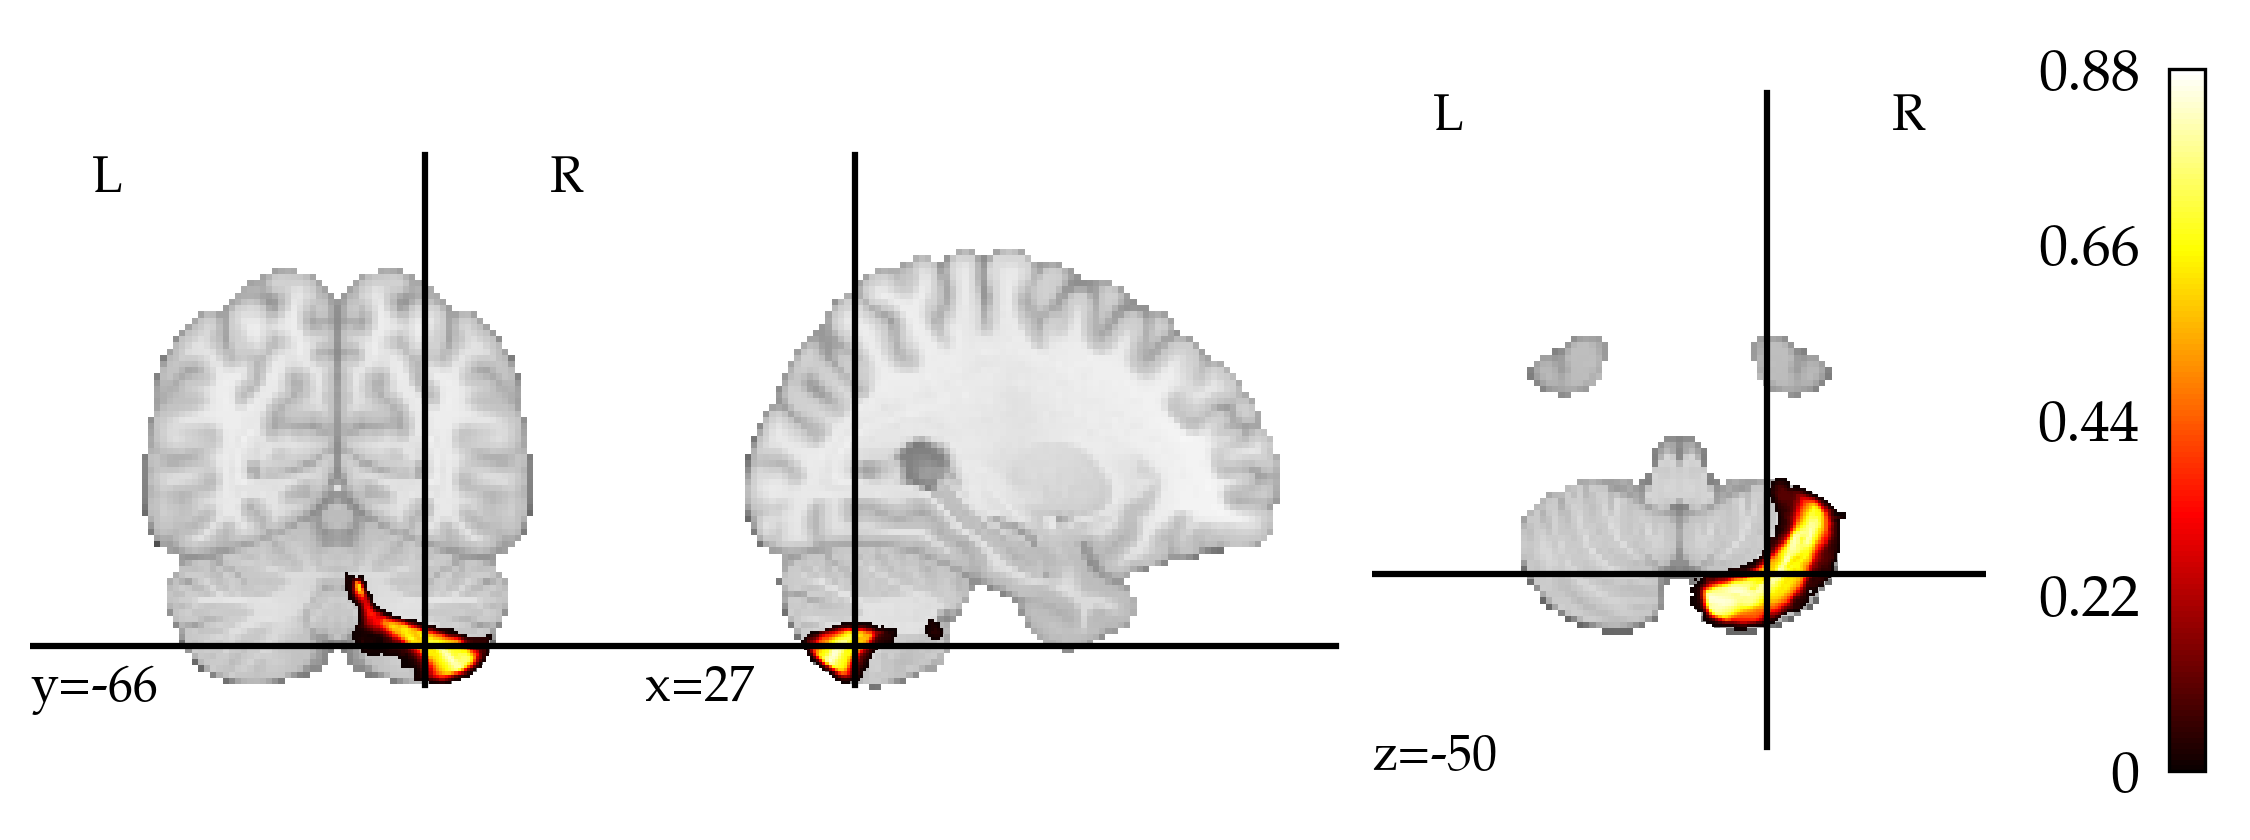

In [9]:
# View the xth statmap (i.e., the probabilistic map for the xth lobule)
statmap = D2009p_data[:, :, :, 15]
nilearn.plotting.plot_stat_map(nibabel.Nifti1Image(statmap, D2009p.affine))
plt.show() 

#### Check affines and resample if necessary

In [10]:
# Save each resampled map
resampled_dir = os.path.join(INPUT_DIR, 'maps/Diedrichsen2009_resampled_mni2mm')

In [11]:
if os.path.exists(os.path.join(resampled_dir, 'D2009_resampled_mni-2mm.nii.gz')):
    combined_4d_map = nibabel.load(os.path.join(INPUT_DIR, 'maps/Diedrichsen2009_resampled_mni2mm/D2009_resampled_mni-2mm.nii.gz'))
    D2009p_new_data = combined_4d_map.get_fdata()
    print(D2009p_new_data.shape)
else:
    # Check affine matrices to see if resampling is necessary
    print("Affine of 4D Probabilistic Segmentation Map (D2009p):")
    print(D2009p.affine)
    proper_mask_2mm = nibabel.load(os.path.join(INPUT_DIR, 'maps/D2009_MNI_2mm.nii.gz'))
    print("\nAffine of Target Mask (proper_mask_2mm):")
    print(proper_mask_2mm.affine)
    # The resolution differs between the maps (D2009p is 1 mm instead of 2mm used throughout the study).
    # Create the directory for resampled maps if it does not exist
    os.makedirs(resampled_dir, exist_ok=True)
    # loop through each 3D map in the 4D image
    resampled_maps = []
    for i in range(D2009p.shape[-1]):
        # extract the i-th 3D map
        statmap = nibabel.Nifti1Image(D2009p.dataobj[..., i], D2009p.affine)
    
        # resample to the target mask for each map individually
        resampled_statmap = resample_to_img(statmap, proper_mask_2mm, interpolation='nearest')
    
        resampled_maps.append(resampled_statmap)
    for idx, img in enumerate(resampled_maps):
        nibabel.save(img, os.path.join(resampled_dir, f'resampled_map_{idx}.nii.gz'))

    # Combine them into a single 4D image and save
    combined_4d_map = nibabel.concat_images(resampled_maps)
    nibabel.save(combined_4d_map, os.path.join(resampled_dir, 'D2009_resampled_mni-2mm.nii.gz'))
    
    D2009p_new_data = combined_4d_map.get_fdata()
    print(D2009p_new_data.shape)  # Should print something like (x, y, z, n)

(77, 52, 43, 34)


#### Optional: compare visually to the not-resampled lobular segmentation

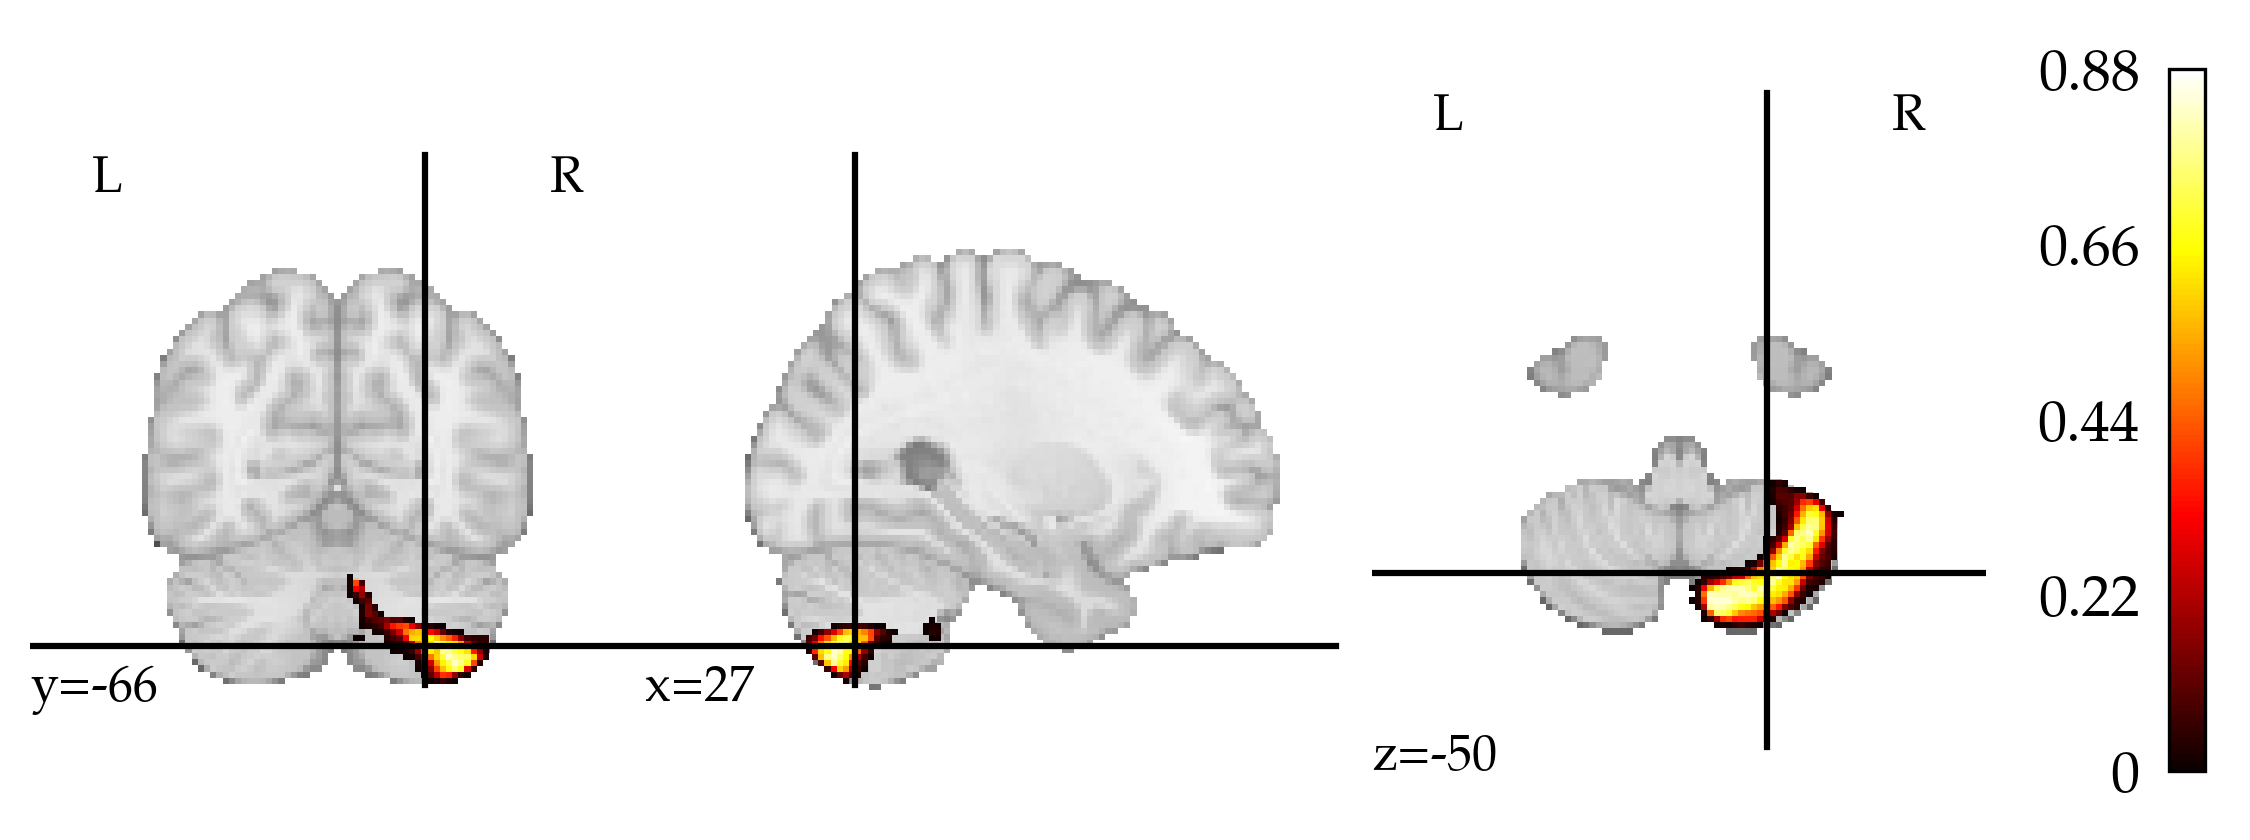

In [12]:
# View the same statmap again
statmap = D2009p_new_data[:, :, :, 15]
nilearn.plotting.plot_stat_map(nibabel.Nifti1Image(statmap, combined_4d_map.affine))
plt.show()

### Run variogram-based correlation between an example Z-map and the probabilistic lobular maps

In [13]:
lobule_labels = pd.Series({
    '0': 'Left I-IV',
    '1': 'Right I-IV',
    '2': 'Left V',
    '3': 'Right V',
    '4': 'Left VI',
    '5': 'Vermis VI',
    '6': 'Right VI',
    '7': 'Left Crus I',
    '8': 'Vermis Crus I',
    '9': 'Right Crus I',
    '10': 'Left Crus II',
    '11': 'Vermis Crus II',
    '12': 'Right Crus II',
    '13': 'Left VIIb',
    '14': 'Vermis VIIb',
    '15': 'Right VIIb',
    '16': 'Left VIIIa',
    '17': 'Vermis VIIIa',
    '18': 'Right VIIIa',
    '19': 'Left VIIIb',
    '20': 'Vermis VIIIb',
    '21': 'Right VIIIb',
    '22': 'Left IX',
    '23': 'Vermis IX',
    '24': 'Right IX',
    '25': 'Left X',
    '26': 'Vermis X',
    '27': 'Right X',
    '28': 'Left Dentate',
    '29': 'Right Dentate',
    '30': 'Left Interposed',
    '31': 'Right Interposed',
    '32': 'Left Fastigial',
    '33': 'Right Fastigial'
})

In [14]:
# Check the shape of the 4D map
print("Shape of the 4D map:", combined_4d_map.shape)

# Number of volumes in the 4D map (i.e., size of the fourth dimension)
num_volumes = combined_4d_map.shape[-1]
print("Number of volumes (maps) in the 4D map:", num_volumes)

# Verify that the number of labels aligns with the available indices
max_label_index = max(int(label) for label in lobule_labels.keys())
print("Max label index:", max_label_index)

if max_label_index >= num_volumes:
    print("Warning: Some labels exceed the number of available volumes in the 4D map.")

Shape of the 4D map: (77, 52, 43, 34)
Number of volumes (maps) in the 4D map: 34
Max label index: 33


In [15]:
if os.path.exists(os.path.join(CORR_dir, 'z_d2009-probseg_r.csv')) and os.path.exists(os.path.join(CORR_DIR, 'z_d2009-probseg_p.csv')):
    # Load correlations and p-values from csv
    r = pd.read_csv(os.path.join(CORR_dir, 'z_d2009-probseg_r.csv'), index_col=0)
    p = pd.read_csv(os.path.join(CORR_dir, 'z_d2009-probseg_p.csv'), index_col=0)
    # Display the resulting dataframes
    print(r)
    print(p)
else:
    # Initialize DataFrames for storing results
    r = pd.DataFrame(index=lobule_labels.values, dtype=float)
    p = pd.DataFrame(index=lobule_labels.values, dtype=float)
    # Define the mask for the brain area of interest
    mask_data = proper_mask_2mm.get_fdata().astype('bool')
    # Get all surrogates paths
    surrogates_paths = sorted(glob.glob(os.path.join(OUTPUT_DIR, 
        'SALE/*/*/uncorr_z_2mm_mask-D2009_MNI_surrogates-variogram_n-1000.npy')
    ))
    # Iterate through each surrogate file to perform the correlation
    for surrogates_path in tqdm(surrogates_paths, desc="Processing Surrogate Paths"): # This take ~20 seconds per (sub)domain.
        # Extract the domain and subdomain from the file path using regex
        subbd_match = re.search(r'SALE/(.*?)/(.*?)/', surrogates_path)
        if subbd_match:
            bd = subbd_match.group(1)
            subbd = subbd_match.group(2)
        else:
            print(f"Failed to parse bd/subbd from path: {surrogates_path}")
            continue
        # Load z map and apply the mask
        z_2mm = os.path.join(os.path.dirname(surrogates_path), 'uncorr_z_2mm.nii.gz')
        z_2mm_masked = nibabel.load(z_2mm).get_fdata()[mask_data]
        # Load surrogate maps
        surrogates = np.load(surrogates_path)
        # Compare against each lobule in the 4D combined map
        for label, lobule_name in lobule_labels.items():
            # Convert the label to an integer index for accessing the 3D map
            label_idx = int(label) - 1  # Adjust index to match 0-based indexing
            # Extract the corresponding 3D map from the combined 4D map
            statmap = combined_4d_map.slicer[..., label_idx]
            statmap_masked = statmap.get_fdata()[mask_data]
            # Calculate Pearson correlation
            r.loc[lobule_name, f'{bd}/{subbd}'] = scipy.stats.pearsonr(z_2mm_masked, statmap_masked).statistic
            # Generate null distribution of correlatios
            null_dist = [scipy.stats.pearsonr(surrogates[i, :], statmap_masked).statistic for i in range(1000)]
            # and calculate p-value of target-map relative to surrogate map correlations
            p.loc[lobule_name, f'{bd}/{subbd}'] = (np.abs(null_dist) >= np.abs(r.loc[lobule_name, f'{bd}/{subbd}'])).mean()    
    # Display the resulting dataframes
    print(r)
    print(p)
    # Save correlations and p-values to csv
    r.to_csv(os.path.join(CORR_DIR, 'z_d2009-probseg_r.csv'))
    p.to_csv(os.path.join(CORR_DIR, 'z_d2009-probseg_p.csv'))

Processing Surrogate Paths: 100%|█████████████████████████████████████████████████████| 38/38 [12:31<00:00, 19.77s/it]

                  Action/Action.Execution.Speech  Action/Action.Execution  \
Left I-IV                              -0.006710                -0.008537   
Right I-IV                             -0.053223                -0.055988   
Left V                                 -0.068947                 0.006551   
Right V                                 0.150706                 0.165979   
Left VI                                -0.028702                 0.372928   
Vermis VI                               0.550535                 0.265866   
Right VI                                0.114291                 0.139558   
Left Crus I                             0.285911                 0.263213   
Vermis Crus I                          -0.087411                -0.167687   
Right Crus I                           -0.012508                -0.023599   
Left Crus II                           -0.100708                -0.176805   
Vermis Crus II                         -0.121310                -0.156437   

In [16]:
# Update column names for r and p dataframes using the map_colum_names function.
r.columns = r.columns.map(map_column_names)
p.columns = p.columns.map(map_column_names)
# Optionally display the updated column names to verify
print(r.columns)
print(p.columns)

Index(['Speech Execution', 'Execution', 'Imagination', 'Inhibition',
       'Observation', 'Action', 'Attention', 'Orthography', 'Phonology',
       'Semantics', 'Speech', 'Language', 'Explicit Memory', 'Working Memory',
       'Memory', 'Music', 'Reasoning', 'Social Cognition', 'Spatial',
       'Cognition', 'Fear', 'Sadness', 'Negative Emotion', 'Happiness',
       'Reward/ Gain', 'Positive Emotion', 'Emotion', 'Sexuality',
       'Interoception', 'Audition', 'Olfaction', 'Pain', 'Somesthesis',
       'Vision - Color', 'Vision - Motion', 'Vision - Shape', 'Vision',
       'Perception'],
      dtype='object')
Index(['Speech Execution', 'Execution', 'Imagination', 'Inhibition',
       'Observation', 'Action', 'Attention', 'Orthography', 'Phonology',
       'Semantics', 'Speech', 'Language', 'Explicit Memory', 'Working Memory',
       'Memory', 'Music', 'Reasoning', 'Social Cognition', 'Spatial',
       'Cognition', 'Fear', 'Sadness', 'Negative Emotion', 'Happiness',
       'Reward/ Gai

### S12b. Plot and hierarchically cluster

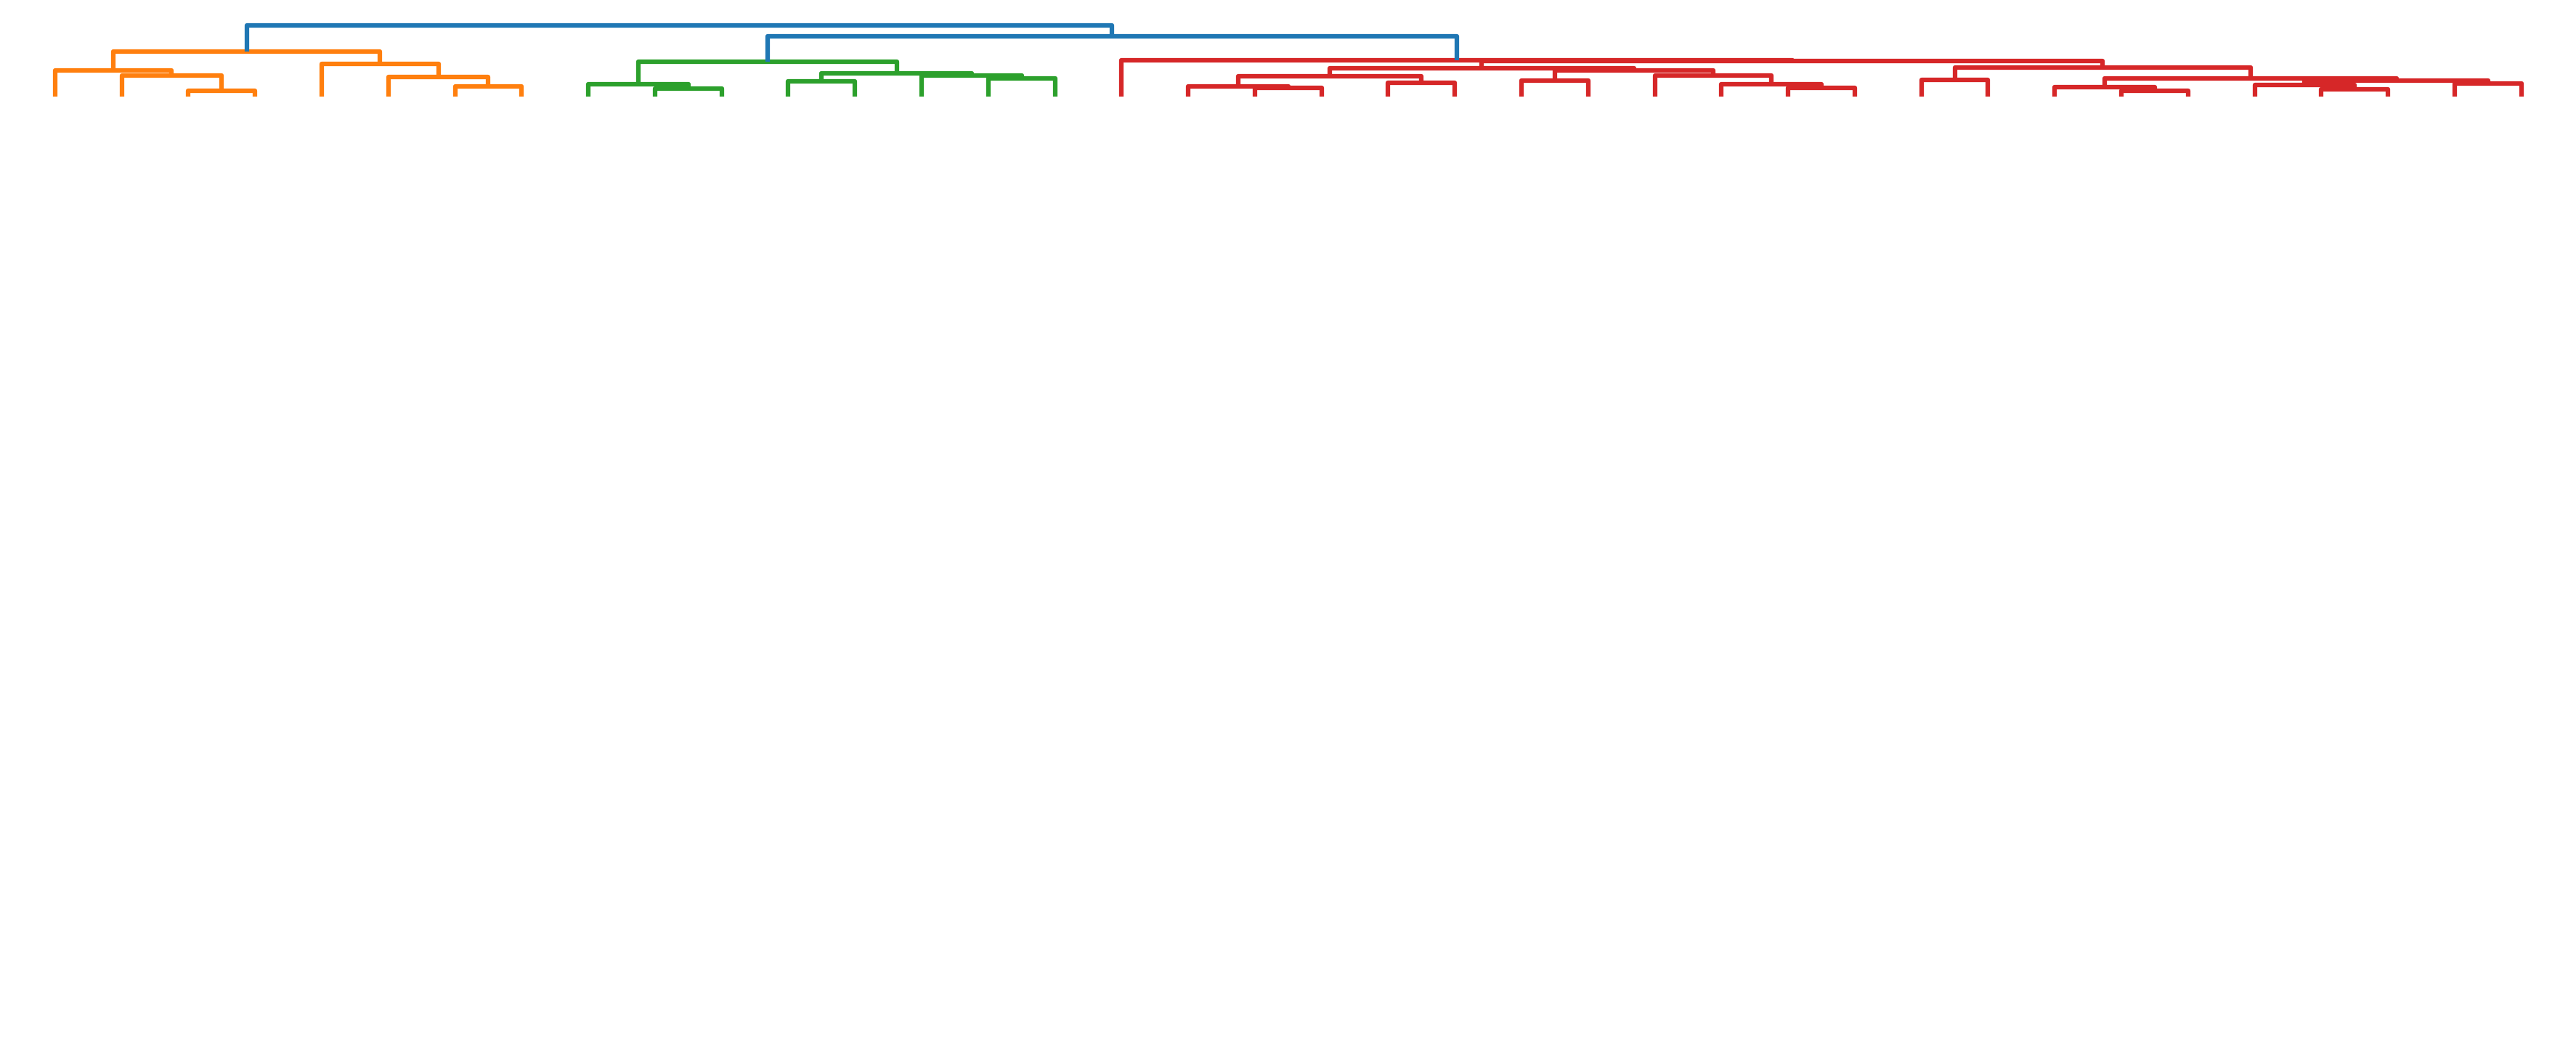

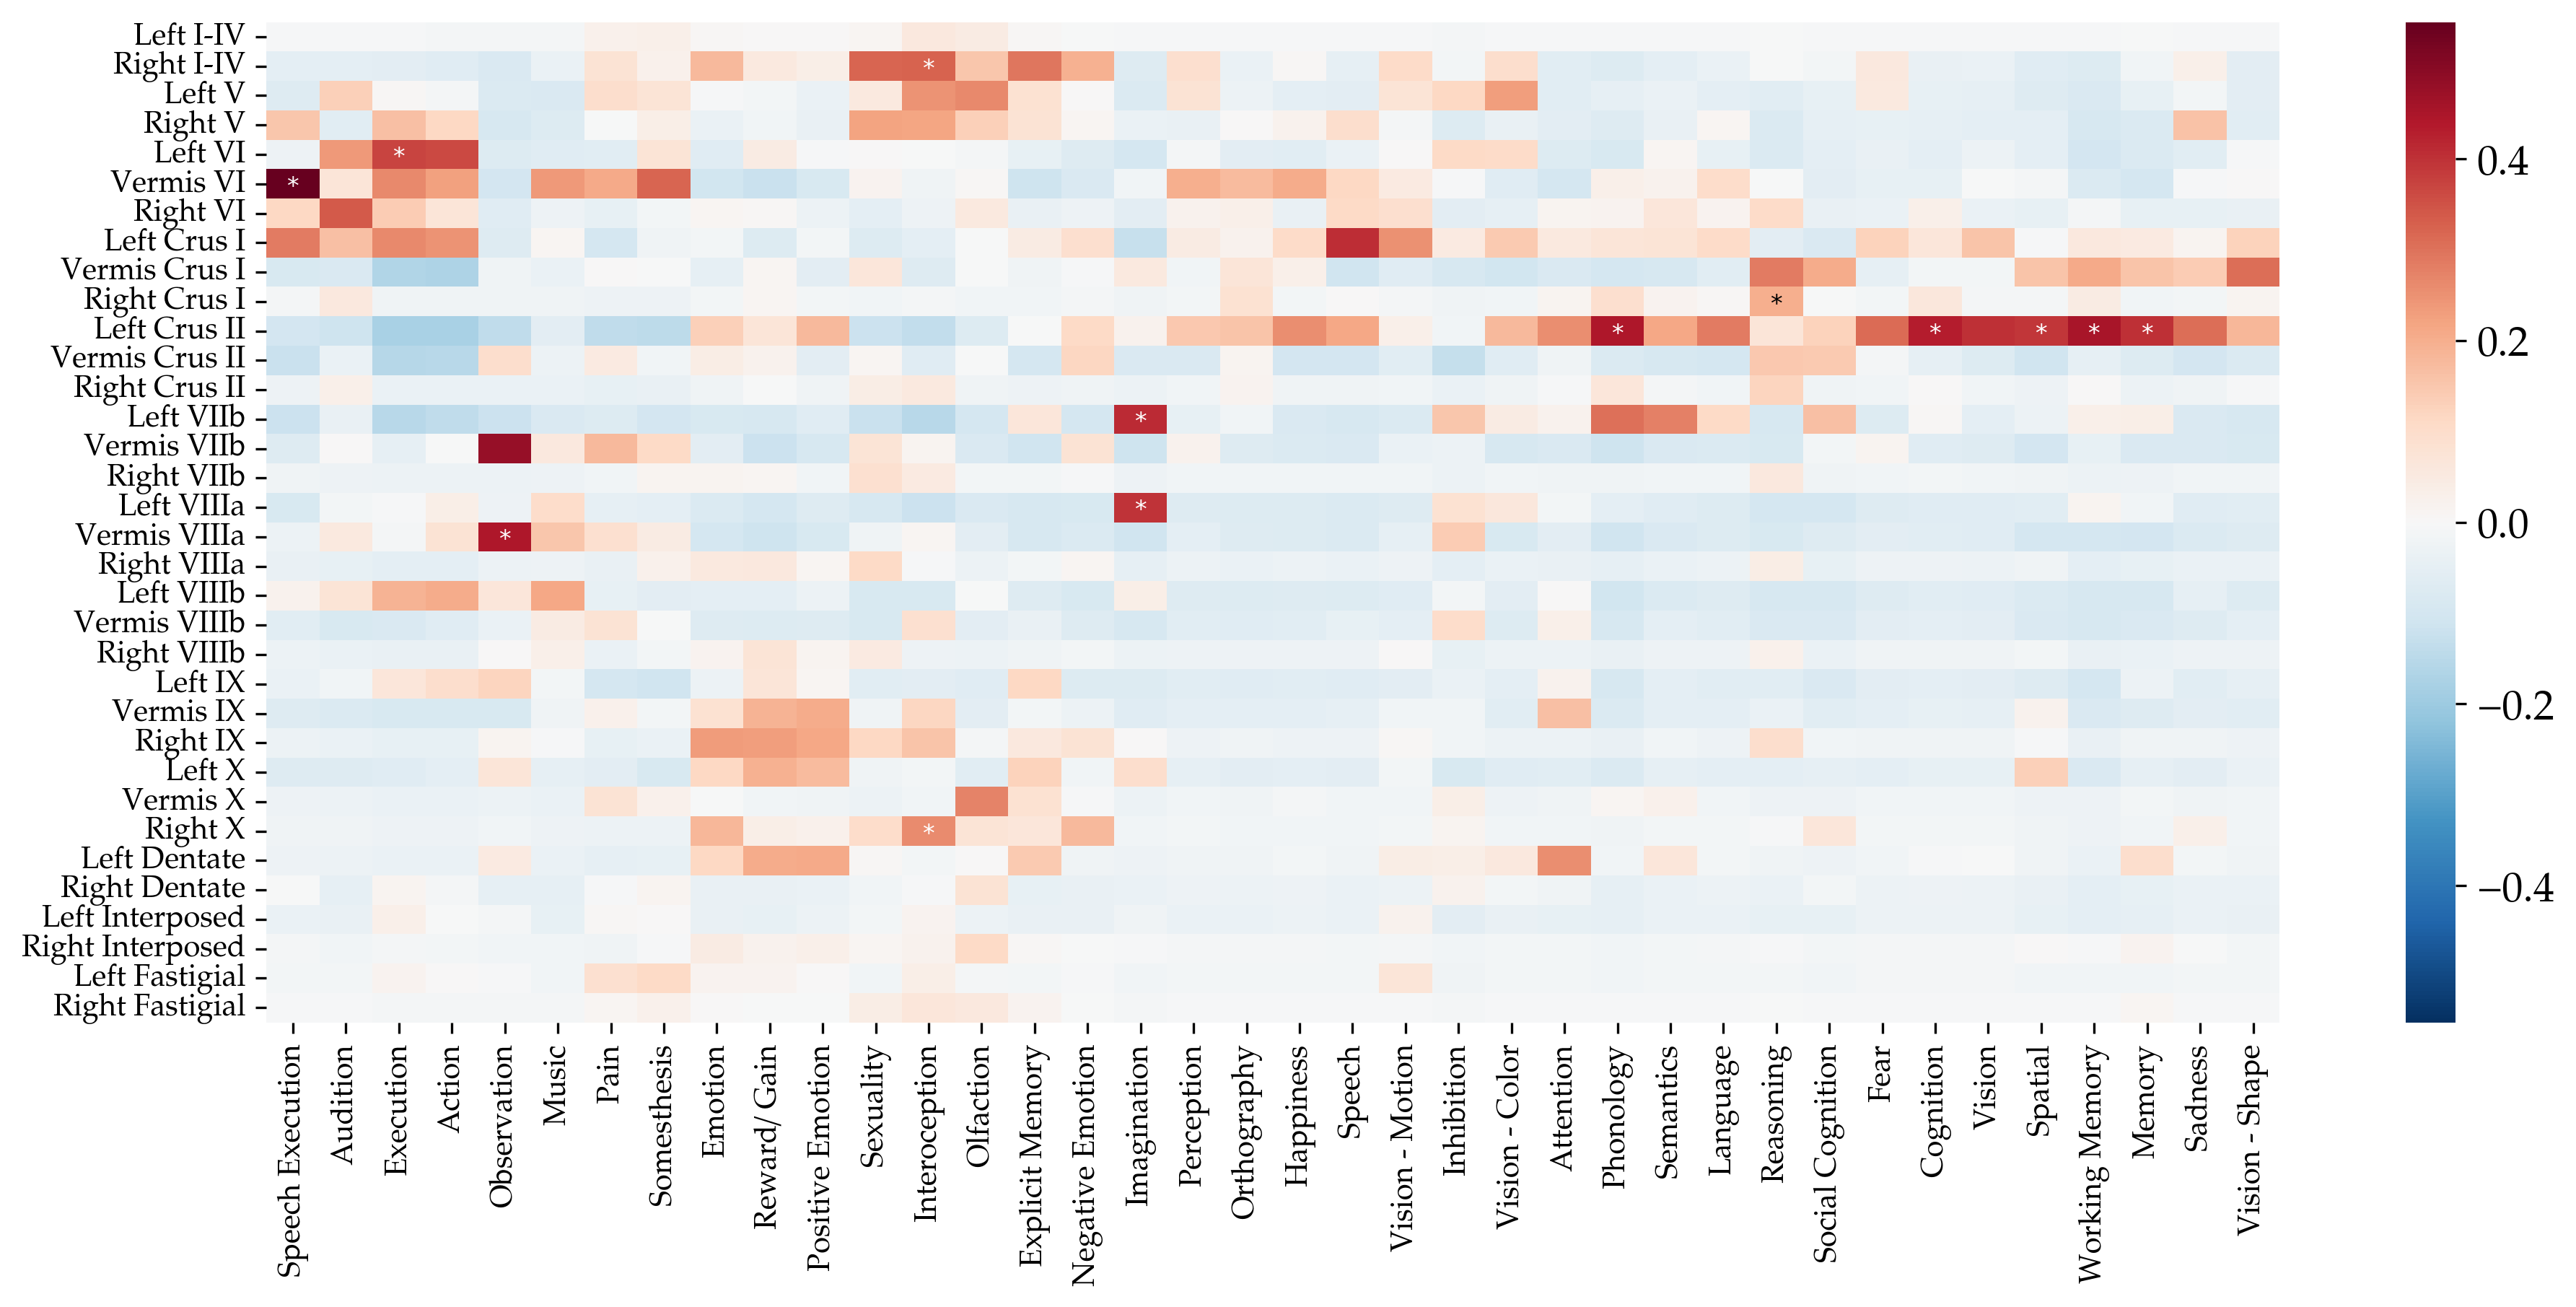

In [17]:
# Perform hierarchical clustering and plot dendrogram
fig, ax = plt.subplots(figsize=(15, 6))
model, dendro, leaf_order = utils.hierarchical_clustering(r.T, no_plot=False, ax=ax)
ax.set_ylim([-25, ax.get_ylim()[1]])
ax.axis('off')

# reorder the original data
r_reordered = r.iloc[:, leaf_order]

# FDR correction
sig_fdr, _ = statsmodels.stats.multitest.fdrcorrection(p.values.flatten())
# reshape 
sig_fdr = pd.DataFrame(sig_fdr.reshape(p.shape), index=p.index, columns=p.columns)
# reorder
sig_fdr = sig_fdr.iloc[:, leaf_order]

# Plot the reordered data with FDR-correction
vmax = np.abs(r_reordered).max().max()  # This ensures the color bar covers the entire range of the data
fig, ax = plt.subplots(figsize=(15, 6))
sns.heatmap(r_reordered, cmap='RdBu_r',linecolor='.8', ax=ax, vmin=-vmax, vmax=vmax)
ax.set_xticks(np.arange(r.shape[1])+0.5)
ax.set_xticklabels(r_reordered.columns, rotation=90, horizontalalignment='center', fontsize=10)
ax.set_yticks(np.arange(r.shape[0])+0.5)
ax.set_yticklabels(lobule_labels, rotation=0, fontsize=10)
ax.set_ylabel('')
# add the * layer
for x, col in enumerate(r_reordered.columns):
    for y, row in enumerate(r_reordered.index):
        if sig_fdr.loc[row, col]: # Use the FDR-corrected p-values.
            text = r'$*$'
            # Conditional color based on the value of r
            text_color = 'white' if r_reordered.loc[row, col] > 0.25 or r_reordered.loc[row, col] < -0.25  else 'black'
            ax.text(x+0.5, y+0.6,
                    text, 
                    fontsize=8,
                    color=text_color,
                    horizontalalignment='center', 
                    verticalalignment='center')

# Binary parcellations

## 5d and S11c. The Nettekoven Hierarchical Cerebellar Atlas

Note: we use the 32-parcel symmetrical atlas, merging the left and right parcels to ultimately create 16 parcels.
Note 2: We spoke to the authors and using the M1-to-S5 naming is more appropriate as labels are putative. Hence we have two versions of the figure with the putatitve behavioral labels in the supplements.

In [24]:
nettekoven_labels = pd.Series({
    '0': 'null',
    'M1L': 'Eye - left',
    'M2L': 'Mouth - left',
    'M3L': 'Hand & Upper - left',
    'M4L': 'Foot & Lower - left',
    'A1L': 'Spatial simulation - left',
    'A2L': 'Action observation - left',
    'A3L': 'Motor imagery - left',
    'D1L': 'Spatial WM - left',
    'D2L': 'Retrieval - left',
    'D3L': 'Verbal WM - left',
    'D4L': 'Spatial/ N-back - left',
    'S1L': 'Linguistic - left',
    'S2L': 'Social - left',
    'S3L': 'Rest - left',
    'S4L': 'Self-projection - left',
    'S5L': 'Scene construction - left',
    'M1R': 'Eye - right',
    'M2R': 'Mouth - right',
    'M3R': 'Hand & Upper - right',
    'M4R': 'Foot & Lower - right',
    'A1R': 'Spatial simulation - right',
    'A2R': 'Action observation - right',
    'A3R': 'Motor imagery - right',
    'D1R': 'Spatial WM - right',
    'D2R': 'Retrieval - right',
    'D3R': 'Verbal WM - right',
    'D4R': 'Spatial/ N-back - right',
    'S1R': 'Linguistic - right',
    'S2R': 'Social - right',
    'S3R': 'Rest - right',
    'S4R': 'Self-projection - right',
    'S5R': 'Scene construction - right' 
})

# Create putative behavioral labels
nettekoven_labels_putative = nettekoven_labels[:17].str.replace(' - left', '')
nettekoven_labels_putative
# # Create main figure labels
nettekoven_labels = nettekoven_labels.index
nettekoven_labels_merged = nettekoven_labels[:17].str.replace('L', '')
nettekoven_labels_merged

Index(['0', 'M1', 'M2', 'M3', 'M4', 'A1', 'A2', 'A3', 'D1', 'D2', 'D3', 'D4',
       'S1', 'S2', 'S3', 'S4', 'S5'],
      dtype='object')

### Load Nettekoven maps and resample them to MNI 2mm space

In [25]:
# Load data
nett = nibabel.load(os.path.join(INPUT_DIR, 'cerebellar_atlases/Nettekoven_2023/atl-NettekovenSym32_space-MNI152NLin6AsymC_dseg.nii'))
# nilearn.plotting.plot_stat_map(nett, threshold=0)

In [26]:
# Resample
proper_mask_2mm = nibabel.load(os.path.join(INPUT_DIR, 'maps/D2009_MNI_2mm.nii.gz')) # Should have been specified before. make sure this map is used.
nett_mni_2mm = nilearn.image.resample_to_img(nett, proper_mask_2mm)

#### Create a symmetric version in which L and R belong to the same parcel:

In [27]:
nett_mni_2mm_data = nett_mni_2mm.get_fdata()
nett_mni_2mm_data[nett_mni_2mm_data>16] -= 16
nett_mni_2mm_sym = nilearn.image.new_img_like(nett_mni_2mm, nett_mni_2mm_data)
# nilearn.plotting.plot_stat_map(nett_mni_2mm_sym)

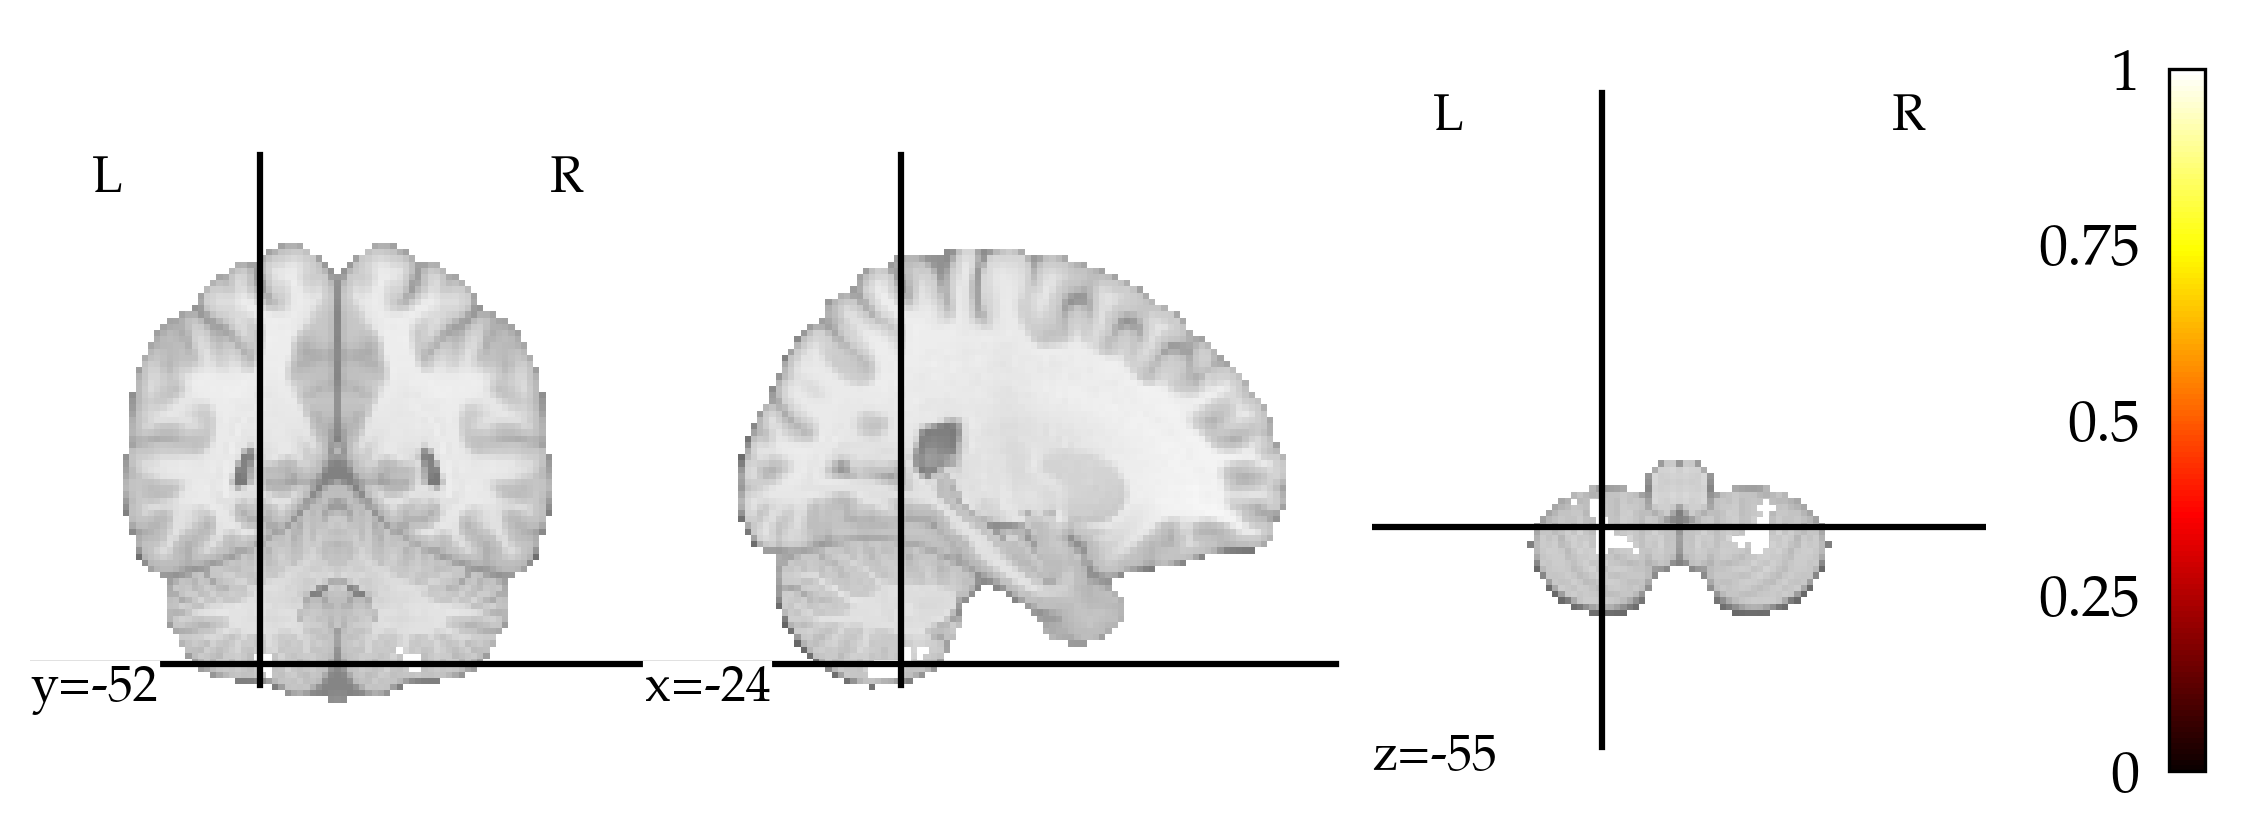

In [28]:
# Plot a single, example, parcel and check if it is symmetric.
nilearn.plotting.plot_stat_map(nilearn.image.math_img('a == 7', a=nett_mni_2mm_sym))

### Run variogram-based mean test

This uses the merged atlas (so compares C-SALE maps against 16 parcels).

In [36]:
if os.path.exists(os.path.join(CORR_DIR, 'z_nettekoven_dseg_LRmerge_mean.csv')) and os.path.exists(os.path.join(CORR_DIR, 'z_nettekoven_dseg_LRmerge_p.csv')):
    # Load correlations and p-values from csv
    obs_mean = pd.read_csv(os.path.join(CORR_DIR, 'z_nettekoven_dseg_LRmerge_mean.csv'), index_col=0)
    p = pd.read_csv(os.path.join(CORR_DIR, 'z_nettekoven_dseg_LRmerge_p.csv'), index_col=0)
    # Add putative labels
    obs_mean_labeled = obs_mean.copy()
    p_labeled = p.copy()
    obs_mean_labeled.index = nettekoven_labels_putative
    p_labeled.index = nettekoven_labels_putative
    # Display the dataframes
    print(obs_mean)
    print(p)
    print(obs_mean_labeled)
    print(p_labeled)
    obs_mean_labeled.to_csv(os.path.join(CORR_DIR, 'z_nettekoven_dseg_LRmerge_mean-labeled.csv'))
    p_labeled.to_csv(os.path.join(CORR_DIR, 'z_nettekoven_dseg_LRmerge_p-labeled.csv'))
    
else:
    mask_data = proper_mask_2mm.get_fdata().astype('bool')
    nett_mni_2mm_sym_masked = nett_mni_2mm_sym.get_fdata()[mask_data]
    obs_mean = pd.DataFrame(index=range(17))
    p = pd.DataFrame(index=range(17))
    surrogates_paths = sorted(glob.glob(os.path.join(OUTPUT_DIR,
        'SALE/*/*/uncorr_z_2mm_mask-D2009_MNI_surrogates-variogram_n-1000.npy')
    ))
    for surrogates_path in tqdm(surrogates_paths): # Takes ~3 seconds per (sub)domain.
        # Extract subbd using regex for better reliability
        subbd_match = re.search(r'SALE/(.*?)/(.*?)/', surrogates_path)
        if subbd_match:
            subbd = subbd_match.group(2)
        else:
            print(f"Failed to parse subbd from path: {surrogates_path}")
            continue
        # load z map and mask it
        z_2mm = os.path.join(os.path.dirname(surrogates_path), 'uncorr_z_2mm.nii.gz')
        z_2mm_masked = nibabel.load(z_2mm).get_fdata()[mask_data]
        # load surrogates
        surrogates = np.load(surrogates_path)

        obs_mean.loc[:, subbd] = pd.DataFrame(
            {'nett': nett_mni_2mm_sym_masked,
            'z': z_2mm_masked}
        ).groupby('nett').mean().values.flatten()
        null_mean = (
            pd.DataFrame(surrogates.T, index=nett_mni_2mm_sym_masked)
            .reset_index(drop=False)
            .groupby('index')
            .mean().values
        )
        p.loc[:, subbd] = (np.abs(null_mean) >= np.abs(obs_mean.loc[:, subbd].values[:, None])).mean(axis=1)
    obs_mean.index = nettekoven_labels_merged
    p.index = nettekoven_labels_merged
    # Add putative labels
    obs_mean_labeled = obs_mean.copy()
    p_labeled = p.copy()
    obs_mean_labeled.index = nettekoven_labels_putative
    p_labeled.index = nettekoven_labels_putative
    # drop null
    obs_mean = obs_mean.drop(index='0')
    p = p.drop(index='0')
    obs_mean_labeled = obs_mean_labeled.drop(index='null')
    p_labeled = p_labeled.drop(index='null')
    # Display the resulting dataframes
    print(obs_mean)
    print(p)
    print(obs_mean_labeled)
    print(p_labeled)
    obs_mean.to_csv(os.path.join(CORR_DIR, 'z_nettekoven_dseg_LRmerge_mean.csv'))
    p.to_csv(os.path.join(CORR_DIR, 'z_nettekoven_dseg_LRmerge_p.csv'))
    obs_mean_labeled.to_csv(os.path.join(CORR_DIR, 'z_nettekoven_dseg_LRmerge_mean-labeled.csv'))
    p_labeled.to_csv(os.path.join(CORR_DIR, 'z_nettekoven_dseg_LRmerge_p-labeled.csv'))

100%|█████████████████████████████████████████████████████████████████████████████████| 38/38 [00:23<00:00,  1.60it/s]

    Action.Execution.Speech  Action.Execution  Action.Imagination  \
M1                 0.775836          0.876592            0.043266   
M2                 0.917452          1.717290            0.027739   
M3                 0.440161          1.548532            0.075177   
M4                 0.027687          0.120065            0.036563   
A1                 0.181921          0.915246            0.079077   
A2                 0.060659          0.691589            0.046432   
A3                 0.448077          0.641585            0.007232   
D1                 0.498127          0.372724            0.335134   
D2                 0.110392          0.250731            0.562742   
D3                 0.328776          0.549612            0.197661   
D4                 0.144589          0.141174            0.435142   
S1                 0.276299          0.192969            0.171448   
S2                 0.005222          0.001598            0.421848   
S3                 0.023394       

### 5d. Plot and hierarchically cluster

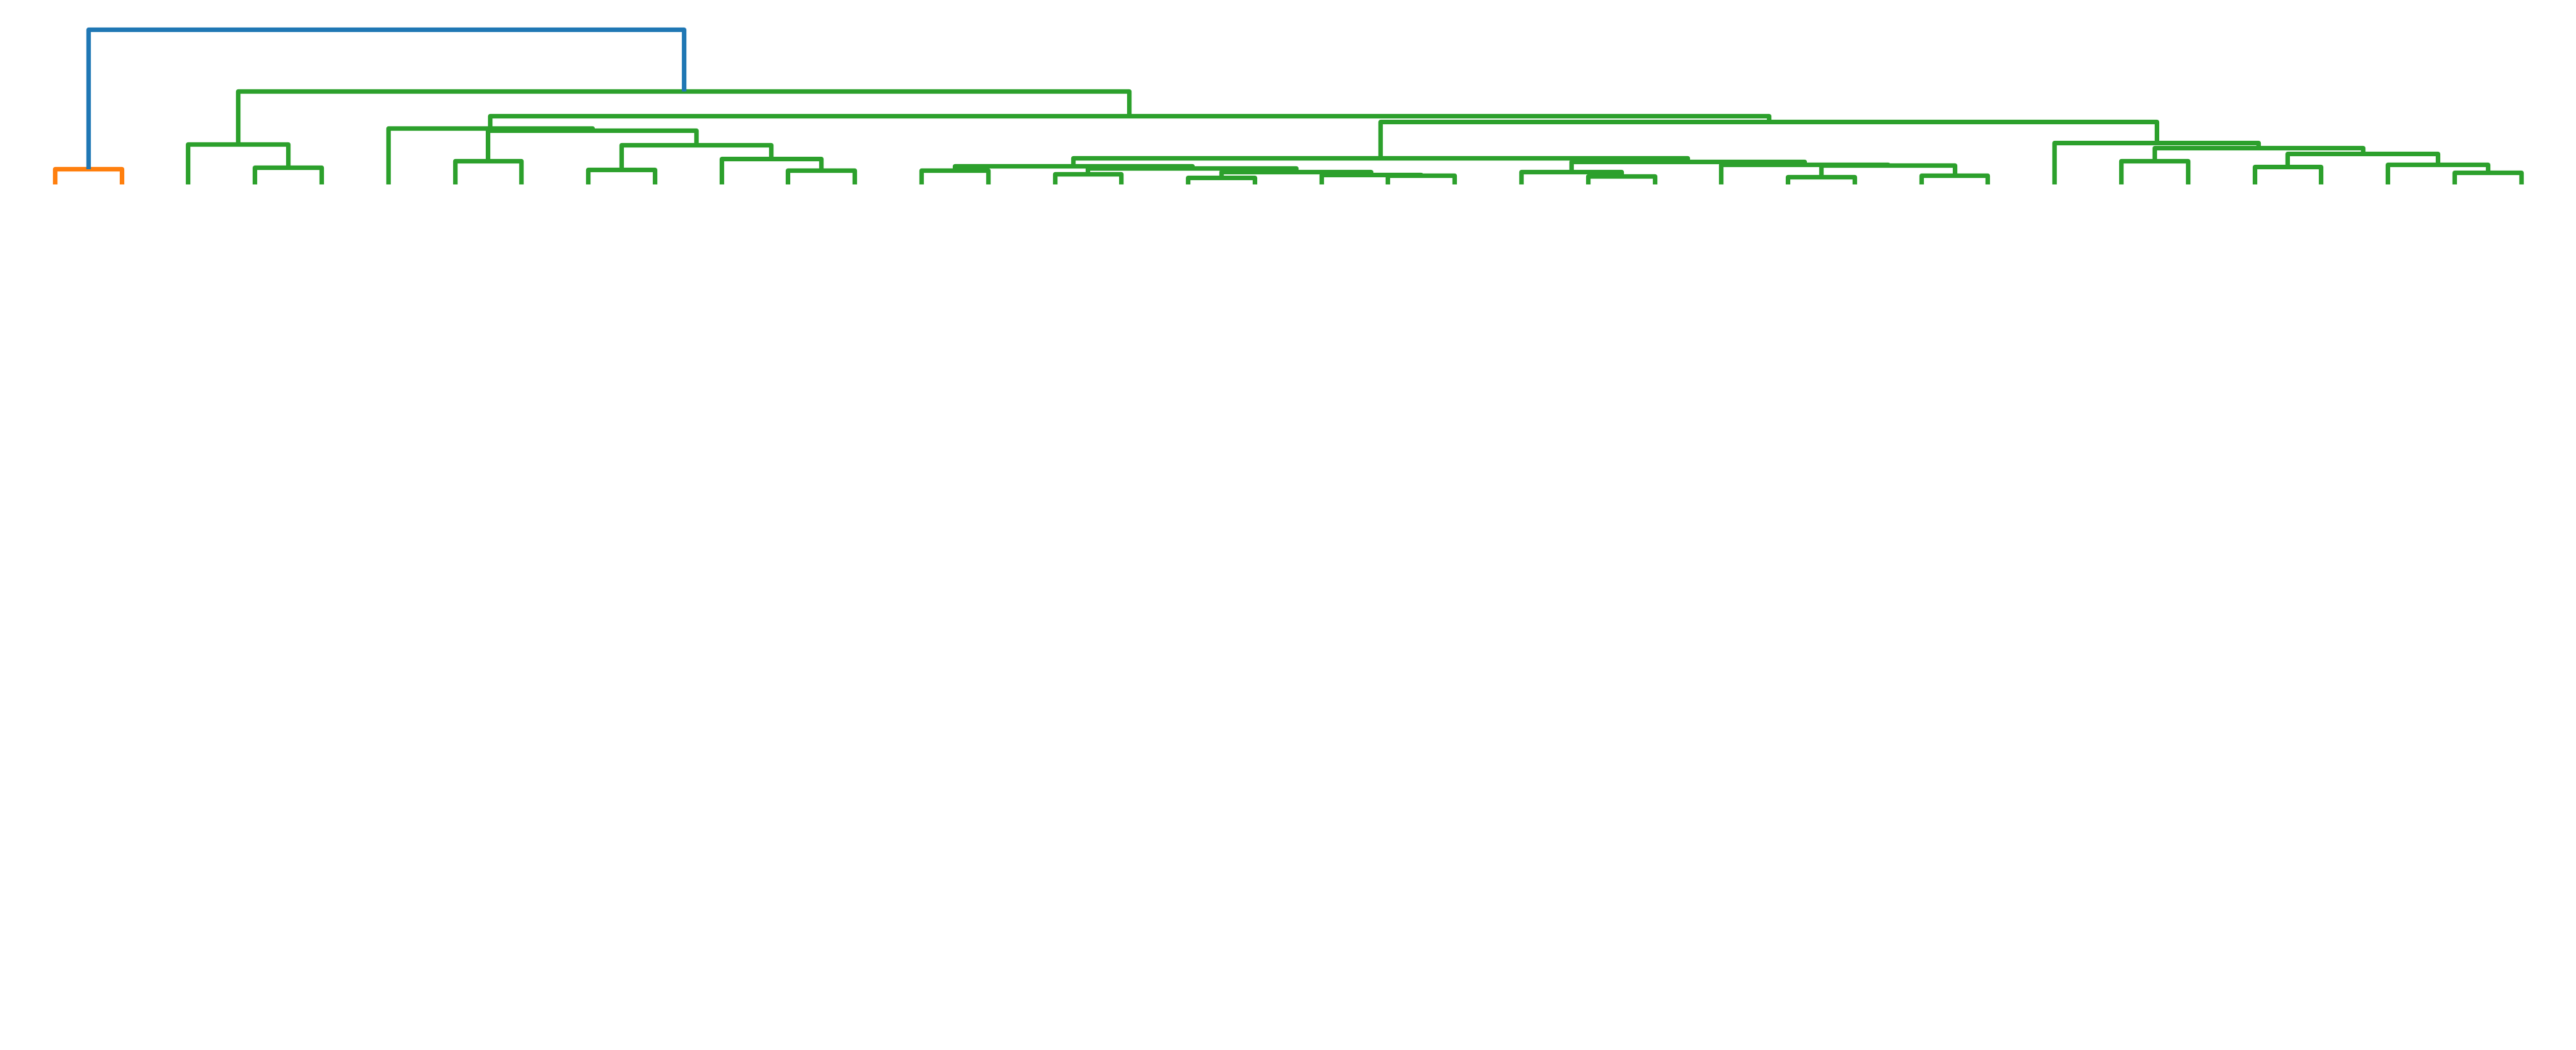

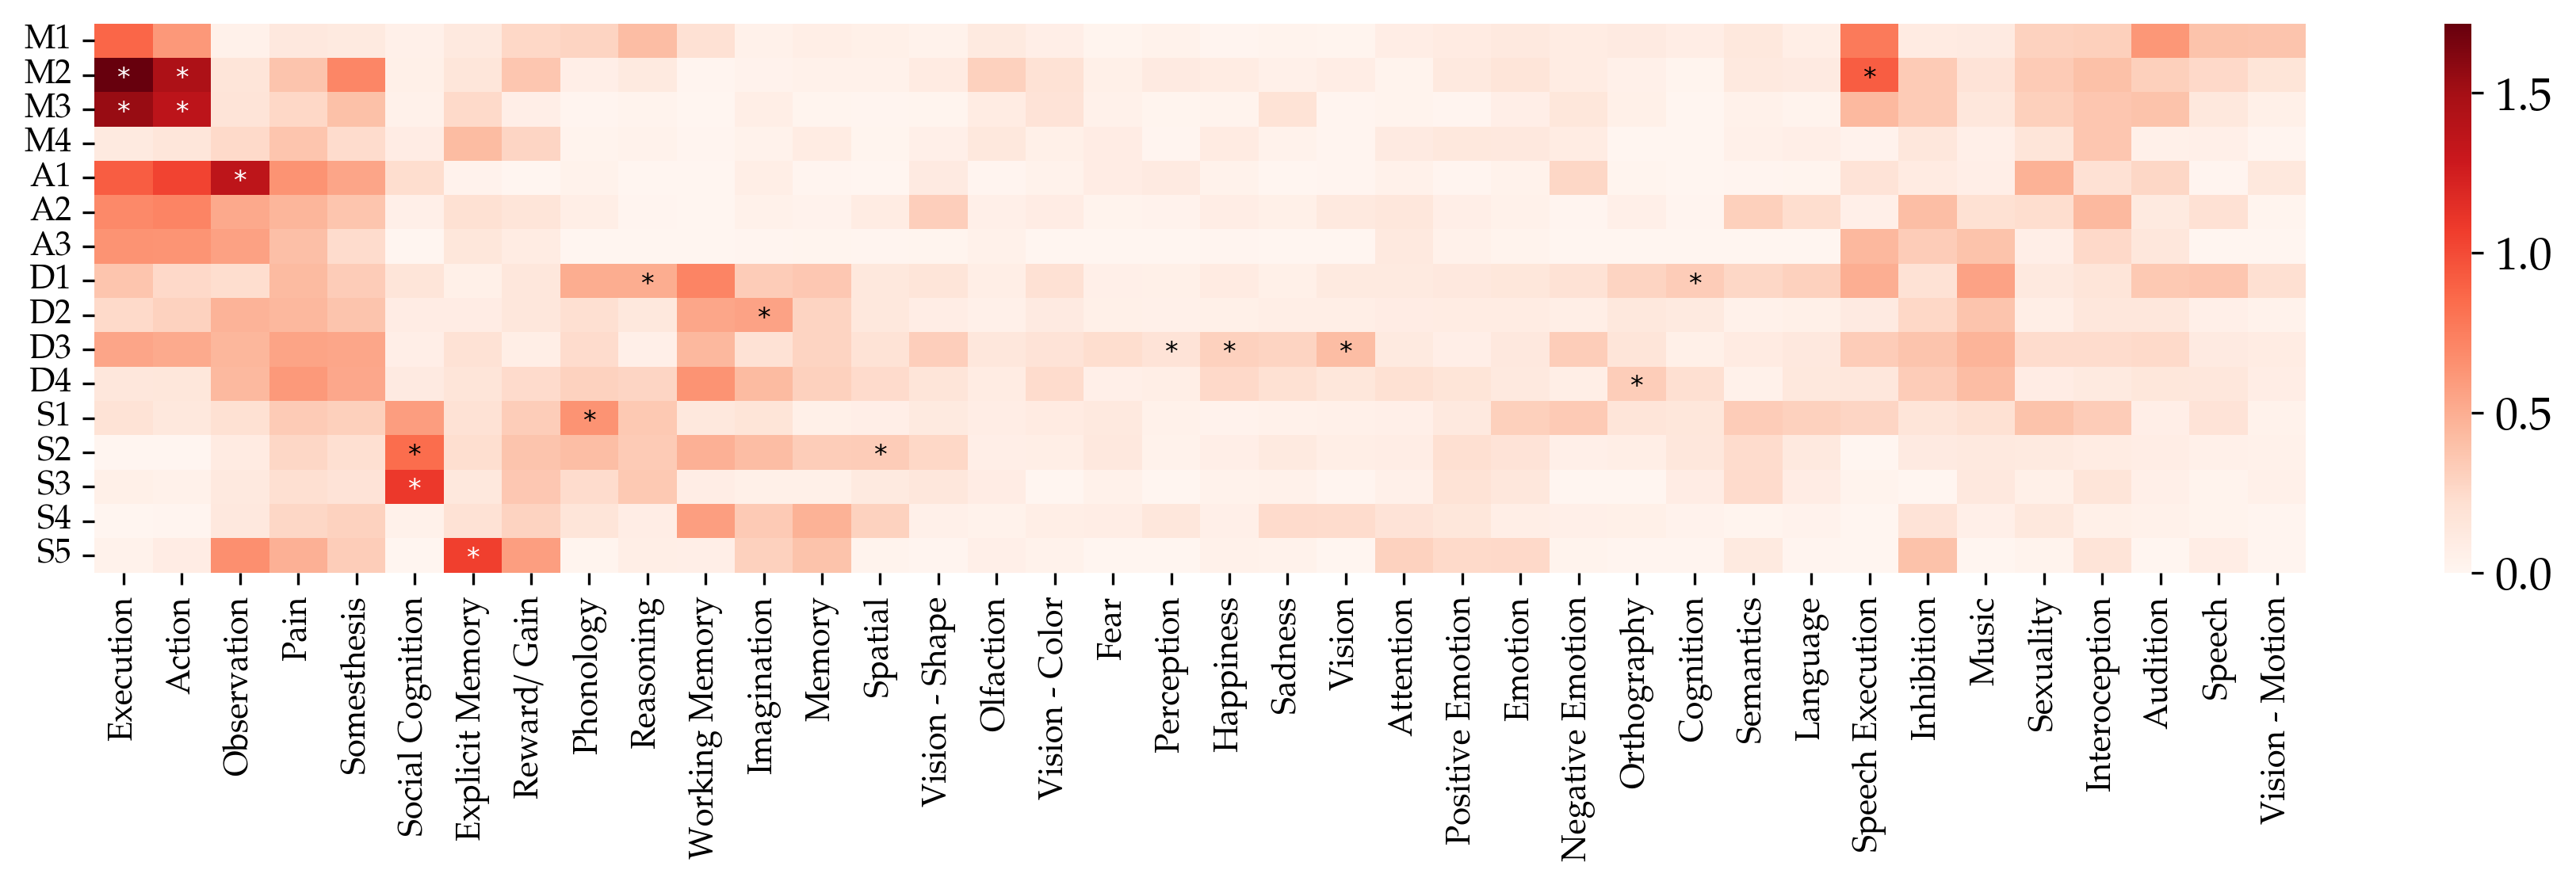

In [37]:
# Perform hierarchical clustering and plot dendrogram
fig, ax = plt.subplots(figsize=(15, 6))
model, dendro, leaf_order = utils.hierarchical_clustering(obs_mean.T, no_plot=False, ax=ax)
ax.set_ylim([-25, ax.get_ylim()[1]])
ax.axis('off')

# reorder the original data
mean_reordered = obs_mean.iloc[:, leaf_order]
# FDR correction
sig_fdr, _ = statsmodels.stats.multitest.fdrcorrection(p.values.flatten())
# reorder dfr data
sig_fdr = pd.DataFrame(sig_fdr.reshape(p.shape), index=p.index, columns=p.columns)
sig_fdr_reordered = sig_fdr.iloc[:, leaf_order]

# plot the reordered data
fig, ax = plt.subplots(figsize=(15, 3))
sns.heatmap(mean_reordered, cmap='Reds',linecolor='.8', ax=ax)
ax.set_xticks(np.arange(p.shape[1])+0.5)
ax.set_xticklabels(utils.bd_labels.loc[mean_reordered.columns].values, rotation=90, horizontalalignment='center', fontsize=10)
ax.set_yticks(np.arange(p.shape[0])+0.5)
ax.set_yticklabels(mean_reordered.index, rotation=0, fontsize=10)
ax.set_ylabel('')
# add the * layer
for x, col in enumerate(mean_reordered.columns):
    for y, row in enumerate(mean_reordered.index):
        if sig_fdr.loc[row, col]:
            text = r'$*$'
            # Conditional color based on the value of r
            text_color = 'white' if mean_reordered.loc[row, col] > 1.0  else 'black'
            ax.text(x+0.5, y+0.6,
                    text, 
                    fontsize=8,
                    color=text_color,
                    horizontalalignment='center', 
                    verticalalignment='center')

### S11c. Create a supplementary version with putative labels

In [40]:
# Assign merged label names to the indices of the dataframes
sig_fdr_labeled = sig_fdr.copy()
sig_fdr_labeled.index = nettekoven_labels_putative[1:17]

In [41]:
print(obs_mean_labeled)
print(sig_fdr_labeled)
print(sig_fdr_labeled)

                    Action.Execution.Speech  Action.Execution  \
Eye                                0.775836          0.876592   
Mouth                              0.917452          1.717290   
Hand & Upper                       0.440161          1.548532   
Foot & Lower                       0.027687          0.120065   
Spatial simulation                 0.181921          0.915246   
Action observation                 0.060659          0.691589   
Motor imagery                      0.448077          0.641585   
Spatial WM                         0.498127          0.372724   
Retrieval                          0.110392          0.250731   
Verbal WM                          0.328776          0.549612   
Spatial/ N-back                    0.144589          0.141174   
Linguistic                         0.276299          0.192969   
Social                             0.005222          0.001598   
Rest                               0.023394          0.054788   
Self-projection          

In [42]:
# Reorder y-axis labels according to the clustering
mean_reordered_labeled = mean_reordered.copy()
mean_reordered_labeled.index = obs_mean_labeled.index

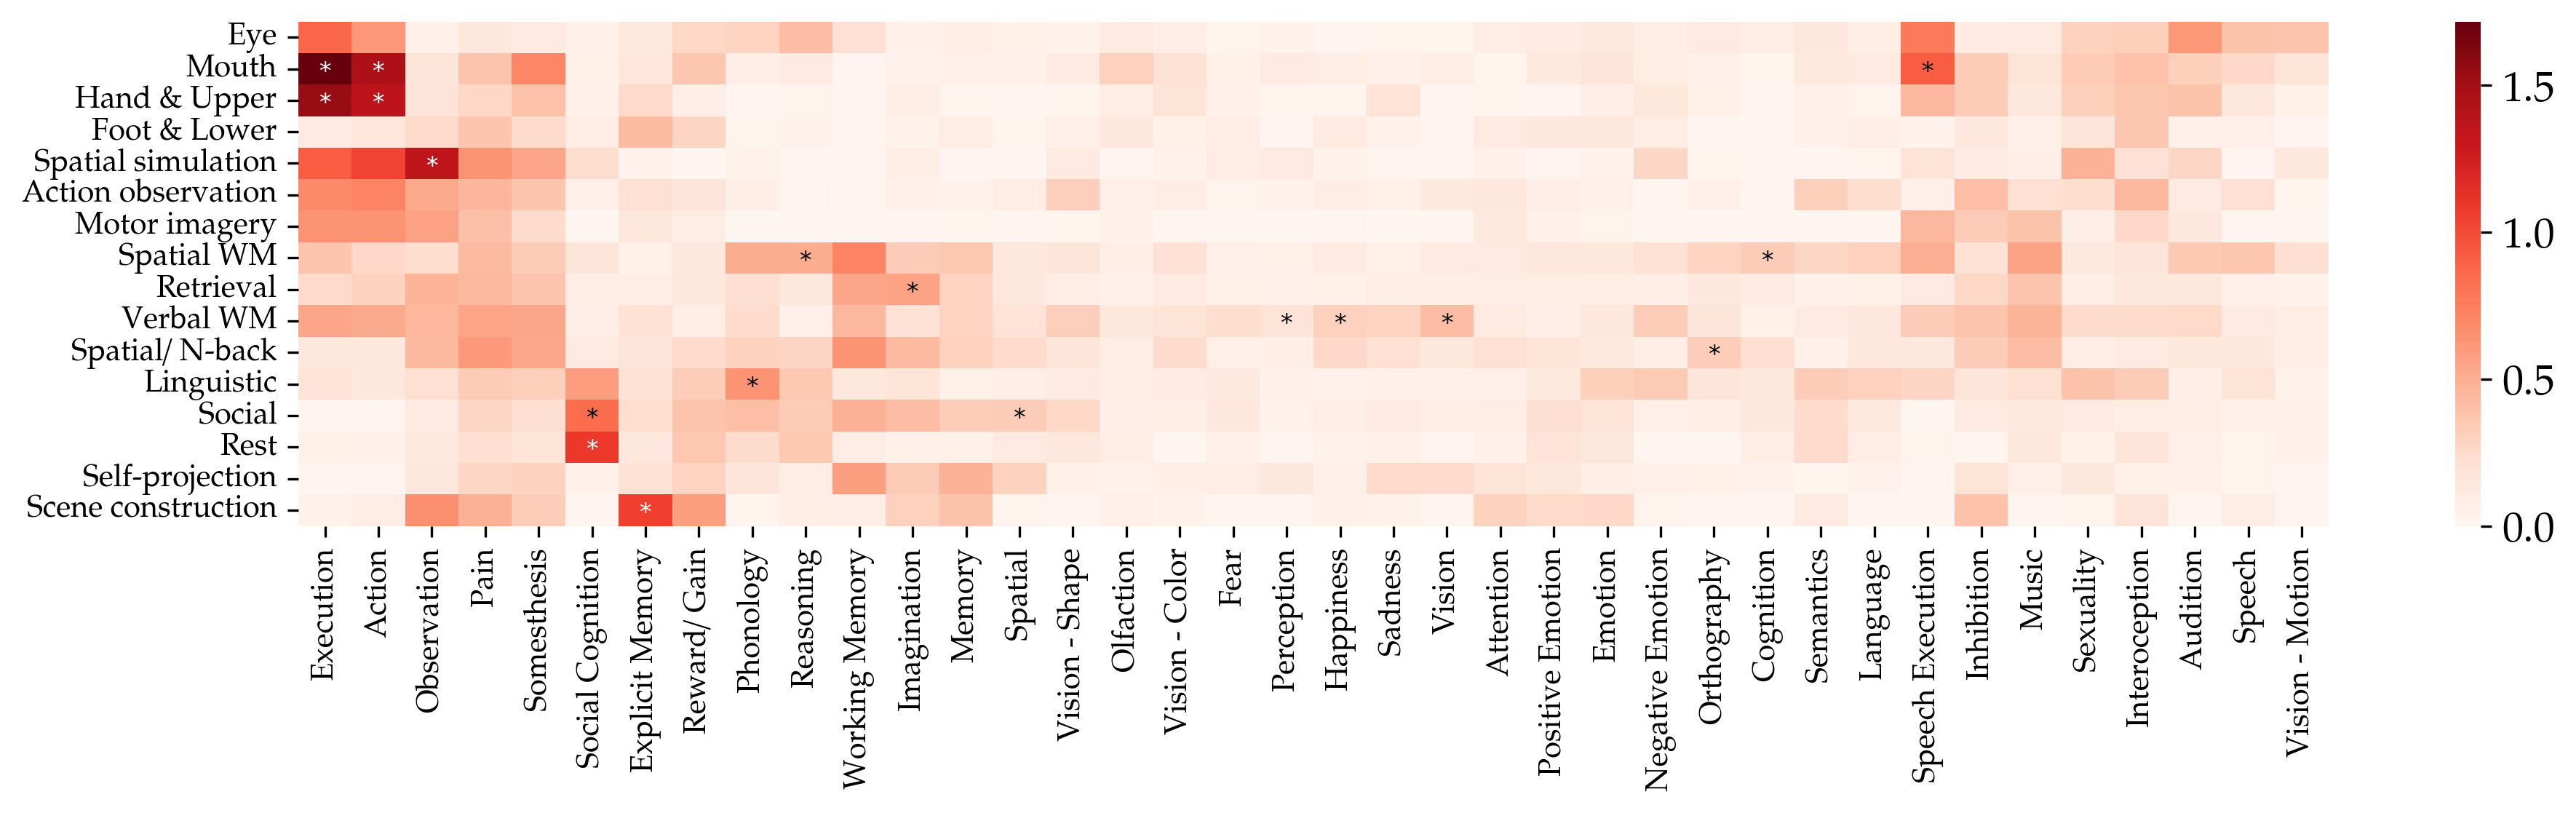

In [43]:
# Plot the reordered data
fig, ax = plt.subplots(figsize=(15, 3))
sns.heatmap(mean_reordered_labeled, cmap='Reds', linecolor='.8', ax=ax)
ax.set_xticks(np.arange(mean_reordered_labeled.shape[1])+0.5)
ax.set_xticklabels(utils.bd_labels.loc[mean_reordered_labeled.columns].values, rotation=90, horizontalalignment='center', fontsize=10)
ax.set_yticks(np.arange(mean_reordered_labeled.shape[0])+0.5)
ax.set_yticklabels(mean_reordered_labeled.index, rotation=0, fontsize=10)  # Use ordered labels here
ax.set_ylabel('')
# Add the * layer
for x, col in enumerate(mean_reordered_labeled.columns):
    for y, row in enumerate(mean_reordered_labeled.index):
        if sig_fdr_labeled.loc[row, col]:
            text = r'$*$'
            # Conditional color based on the value of r
            text_color = 'white' if mean_reordered_labeled.loc[row, col] > 1.0  else 'black'
            ax.text(x+0.5, y+0.6,
                    text, 
                    fontsize=8,
                    color=text_color,
                    horizontalalignment='center', 
                    verticalalignment='center')

## S11a. Buckner et al. 2011 atlas.

In [44]:
# Load data
buck = nibabel.load(os.path.join(INPUT_DIR, 'cerebellar_atlases/Buckner_2011/atl-Buckner7_space-MNI_dseg.nii'))

In [45]:
buckner_labels = pd.Series({
    '0': 'Background',
    '1': 'Visual',
    '2': 'Somatomotor',
    '3': 'Dorsal Attention',
    '4': 'Ventral Attention',
    '5': 'Limbic',
    '6': 'Frontoparietal',
    '7': 'Default-Mode',
})
# buckner_labels = buckner_labels.index

### Inspect the parcellation

In [46]:
#Extract the data array
buck_data = buck.get_fdata()
# Get unique labels
unique_labels = np.unique(buck_data)
# Print the unique labels and their count
print(f"Unique labels in buck_data: {unique_labels}")
print(f"Number of unique labels: {len(unique_labels)}")
# nilearn.plotting.plot_stat_map(buck, threshold=0)

Unique labels in buck_data: [0. 1. 2. 3. 4. 5. 6. 7.]
Number of unique labels: 8


In [47]:
# Check the data type of the loaded Buckner atlas
print(f"Data type of Buckner atlas before resampling: {buck.get_fdata().dtype}")
# Load the mask image
proper_mask_2mm = nibabel.load(os.path.join(INPUT_DIR, 'maps/D2009_MNI_2mm.nii.gz')) # This has been loaded before, make sure to resample to this mask.
# Resample the Buckner atlas to the mask
buck_mni_2mm = nilearn.image.resample_to_img(buck, proper_mask_2mm)
# Check the data type of the resampled Buckner atlas
print(f"Data type of Buckner atlas after resampling: {buck_mni_2mm.get_fdata().dtype}")
# Convert the data back to integer. It is important to check that the labels are still under the correct index.
buck_mni_2mm_data = buck_mni_2mm.get_fdata().astype(np.int32)
buck_mni_2mm = nibabel.Nifti1Image(buck_mni_2mm_data, buck_mni_2mm.affine, buck_mni_2mm.header)

Data type of Buckner atlas before resampling: float64
Data type of Buckner atlas after resampling: float64


In [48]:
# Check unique labels after resampling
unique_labels = np.unique(buck_mni_2mm.get_fdata())
print(f"Unique labels in resampled Buckner atlas: {unique_labels}")
print(f"Number of unique labels: {len(unique_labels)}")
# Check if the number of unique labels is 8
if len(unique_labels) == 8:
    print("The data contains 8 unique labels as expected.")
else:
    print(f"Warning: The data contains {len(unique_labels)} unique labels instead of 8.")

Unique labels in resampled Buckner atlas: [0. 1. 2. 3. 4. 5. 6. 7.]
Number of unique labels: 8
The data contains 8 unique labels as expected.


In this atlas, L and R already belong to the same parcel:

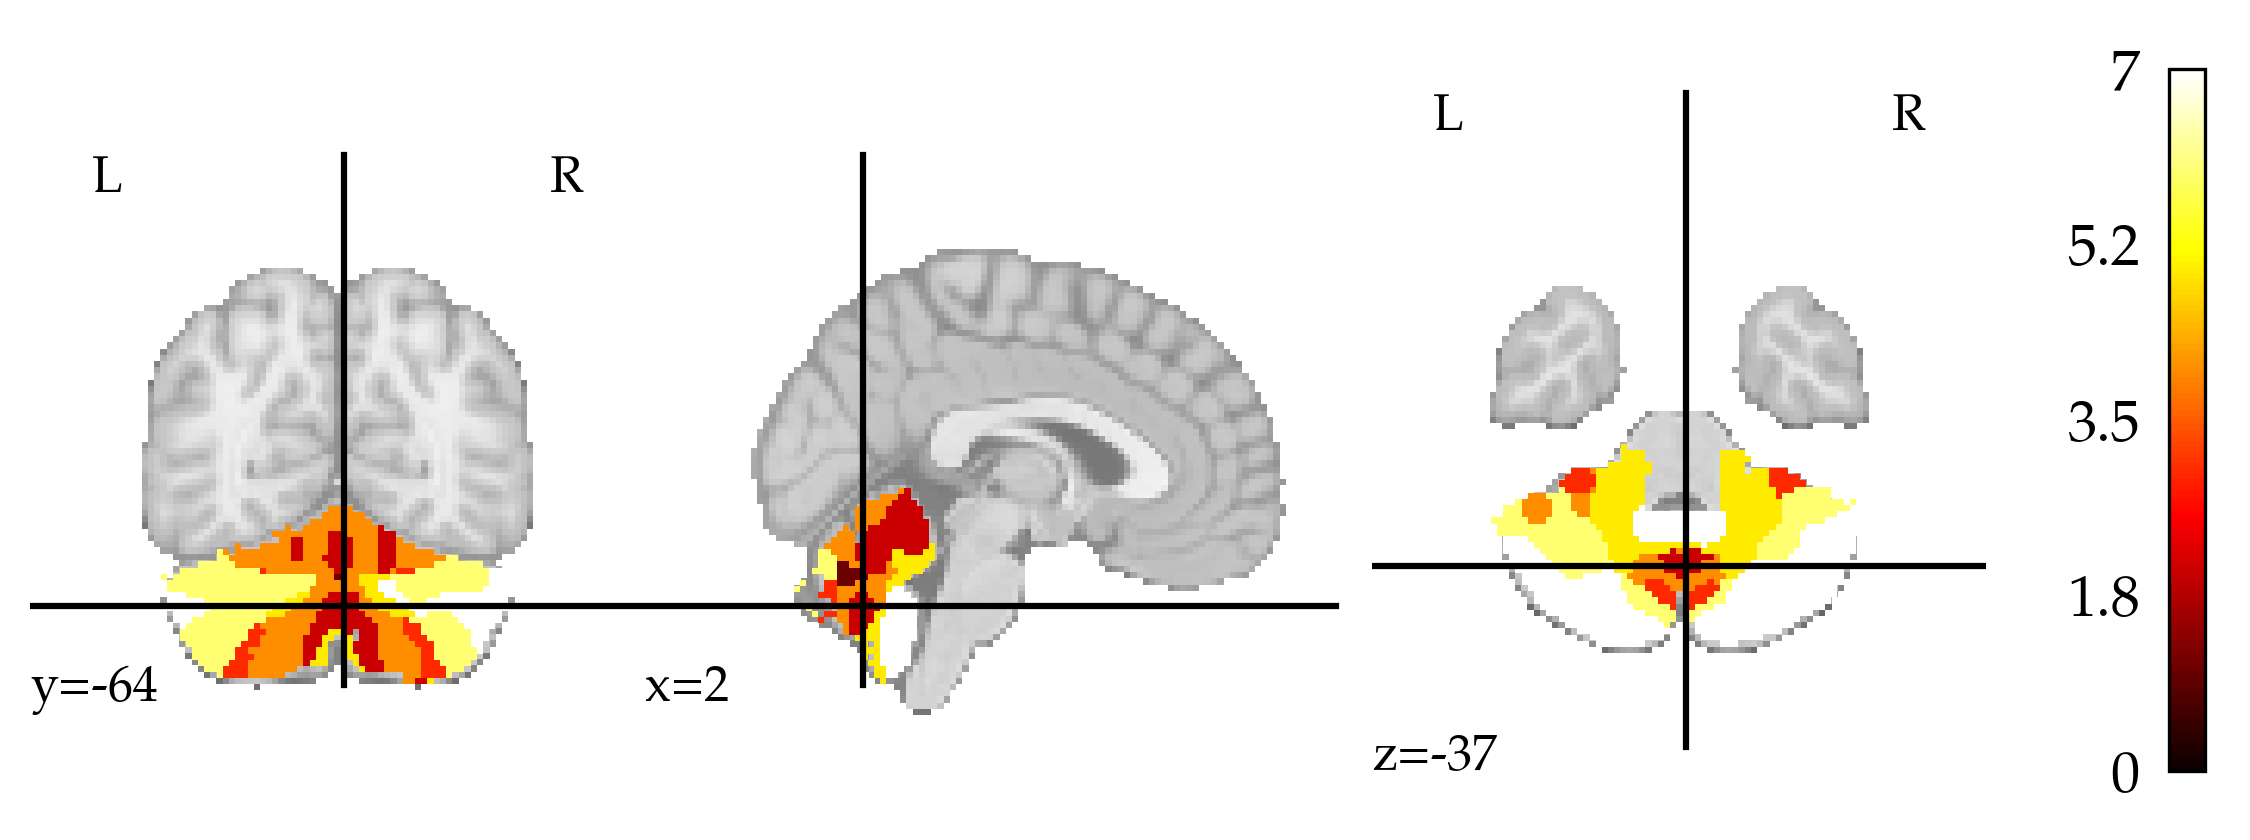

In [49]:
nilearn.plotting.plot_stat_map(buck_mni_2mm)

### Run variogram-based mean test

In [50]:
if os.path.exists(os.path.join(CORR_DIR, 'z_buckner_dseg_LRmerge_mean.csv')) and os.path.exists(os.path.join(CORR_DIR, 'z_buckner_dseg_LRmerge_p.csv')):
    obs_mean = pd.read_csv(os.path.join(CORR_DIR, 'z_buckner_dseg_LRmerge_mean.csv'), index_col=0)
    p = pd.read_csv(os.path.join(CORR_DIR, 'z_buckner_dseg_LRmerge_p.csv'), index_col=0)
    
    # Display the dataframes
    print(obs_mean)
    print(p)
else:

    mask_data = proper_mask_2mm.get_fdata().astype('bool')
    buck_mni_2mm_masked = buck_mni_2mm.get_fdata()[mask_data]
    
    obs_mean = pd.DataFrame(index=range(8))
    p = pd.DataFrame(index=range(8))
    
    surrogates_paths = sorted(glob.glob(os.path.join(OUTPUT_DIR, # Takes ~ 1 minute in total.
        'SALE/*/*/uncorr_z_2mm_mask-D2009_MNI_surrogates-variogram_n-1000.npy')
    ))
    
    for surrogates_path in tqdm(surrogates_paths):
        # Extract subbd using regex for better reliability
        subbd_match = re.search(r'SALE/(.*?)/(.*?)/', surrogates_path)
        if subbd_match:
            subbd = subbd_match.group(2)
        else:
            print(f"Failed to parse subbd from path: {surrogates_path}")
            continue

        # load z map and mask it
        z_2mm = os.path.join(os.path.dirname(surrogates_path), 'uncorr_z_2mm.nii.gz')
        z_2mm_masked = nibabel.load(z_2mm).get_fdata()[mask_data]
        # load surrogates
        surrogates = np.load(surrogates_path)

        obs_mean.loc[:, subbd] = pd.DataFrame(
            {'buck': buck_mni_2mm_masked,
            'z': z_2mm_masked}
        ).groupby('buck').mean().values.flatten()

        # This makes the calculations a ton faster!
        null_mean = (
            pd.DataFrame(surrogates.T, index=buck_mni_2mm_masked)
            .reset_index(drop=False)
            .groupby('index')
            .mean().values
        )
        
        p.loc[:, subbd] = (np.abs(null_mean) >= np.abs(obs_mean.loc[:, subbd].values[:, None])).mean(axis=1)
    # load and label
    obs_mean.index = buckner_labels
    p.index = buckner_labels
    # drop null
    obs_mean = obs_mean.drop(index='Background')
    p = p.drop(index='Background')
    
    # Display the resulting dataframes
    print(obs_mean)
    print(p)
    obs_mean.to_csv(os.path.join(CORR_DIR, 'z_buckner_dseg_LRmerge_mean.csv'))
    p.to_csv(os.path.join(CORR_DIR, 'z_buckner_dseg_LRmerge_p.csv'))

100%|█████████████████████████████████████████████████████████████████████████████████| 38/38 [00:18<00:00,  2.05it/s]

                   Action.Execution.Speech  Action.Execution  \
Visual                            0.024873          0.357350   
Somatomotor                       0.358988          1.341200   
Dorsal Attention                  0.141061          0.742587   
Ventral Attention                 0.601373          0.914873   
Limbic                            0.013058          0.207657   
Frontoparietal                    0.228626          0.169696   
Default-Mode                      0.034884          0.006273   

                   Action.Imagination  Action.Inhibition  Action.Observation  \
Visual                  -3.515312e-23       3.933321e-19       -2.254328e-20   
Somatomotor              4.023972e-02       2.894708e-01        1.474851e-01   
Dorsal Attention         3.051939e-01       2.008916e-01        8.098395e-01   
Ventral Attention        5.127981e-02       3.524277e-01        4.858254e-01   
Limbic                   4.677528e-02       1.029639e-01        1.462733e-01   
Frontop

### S11a. Label and plot hierarchically

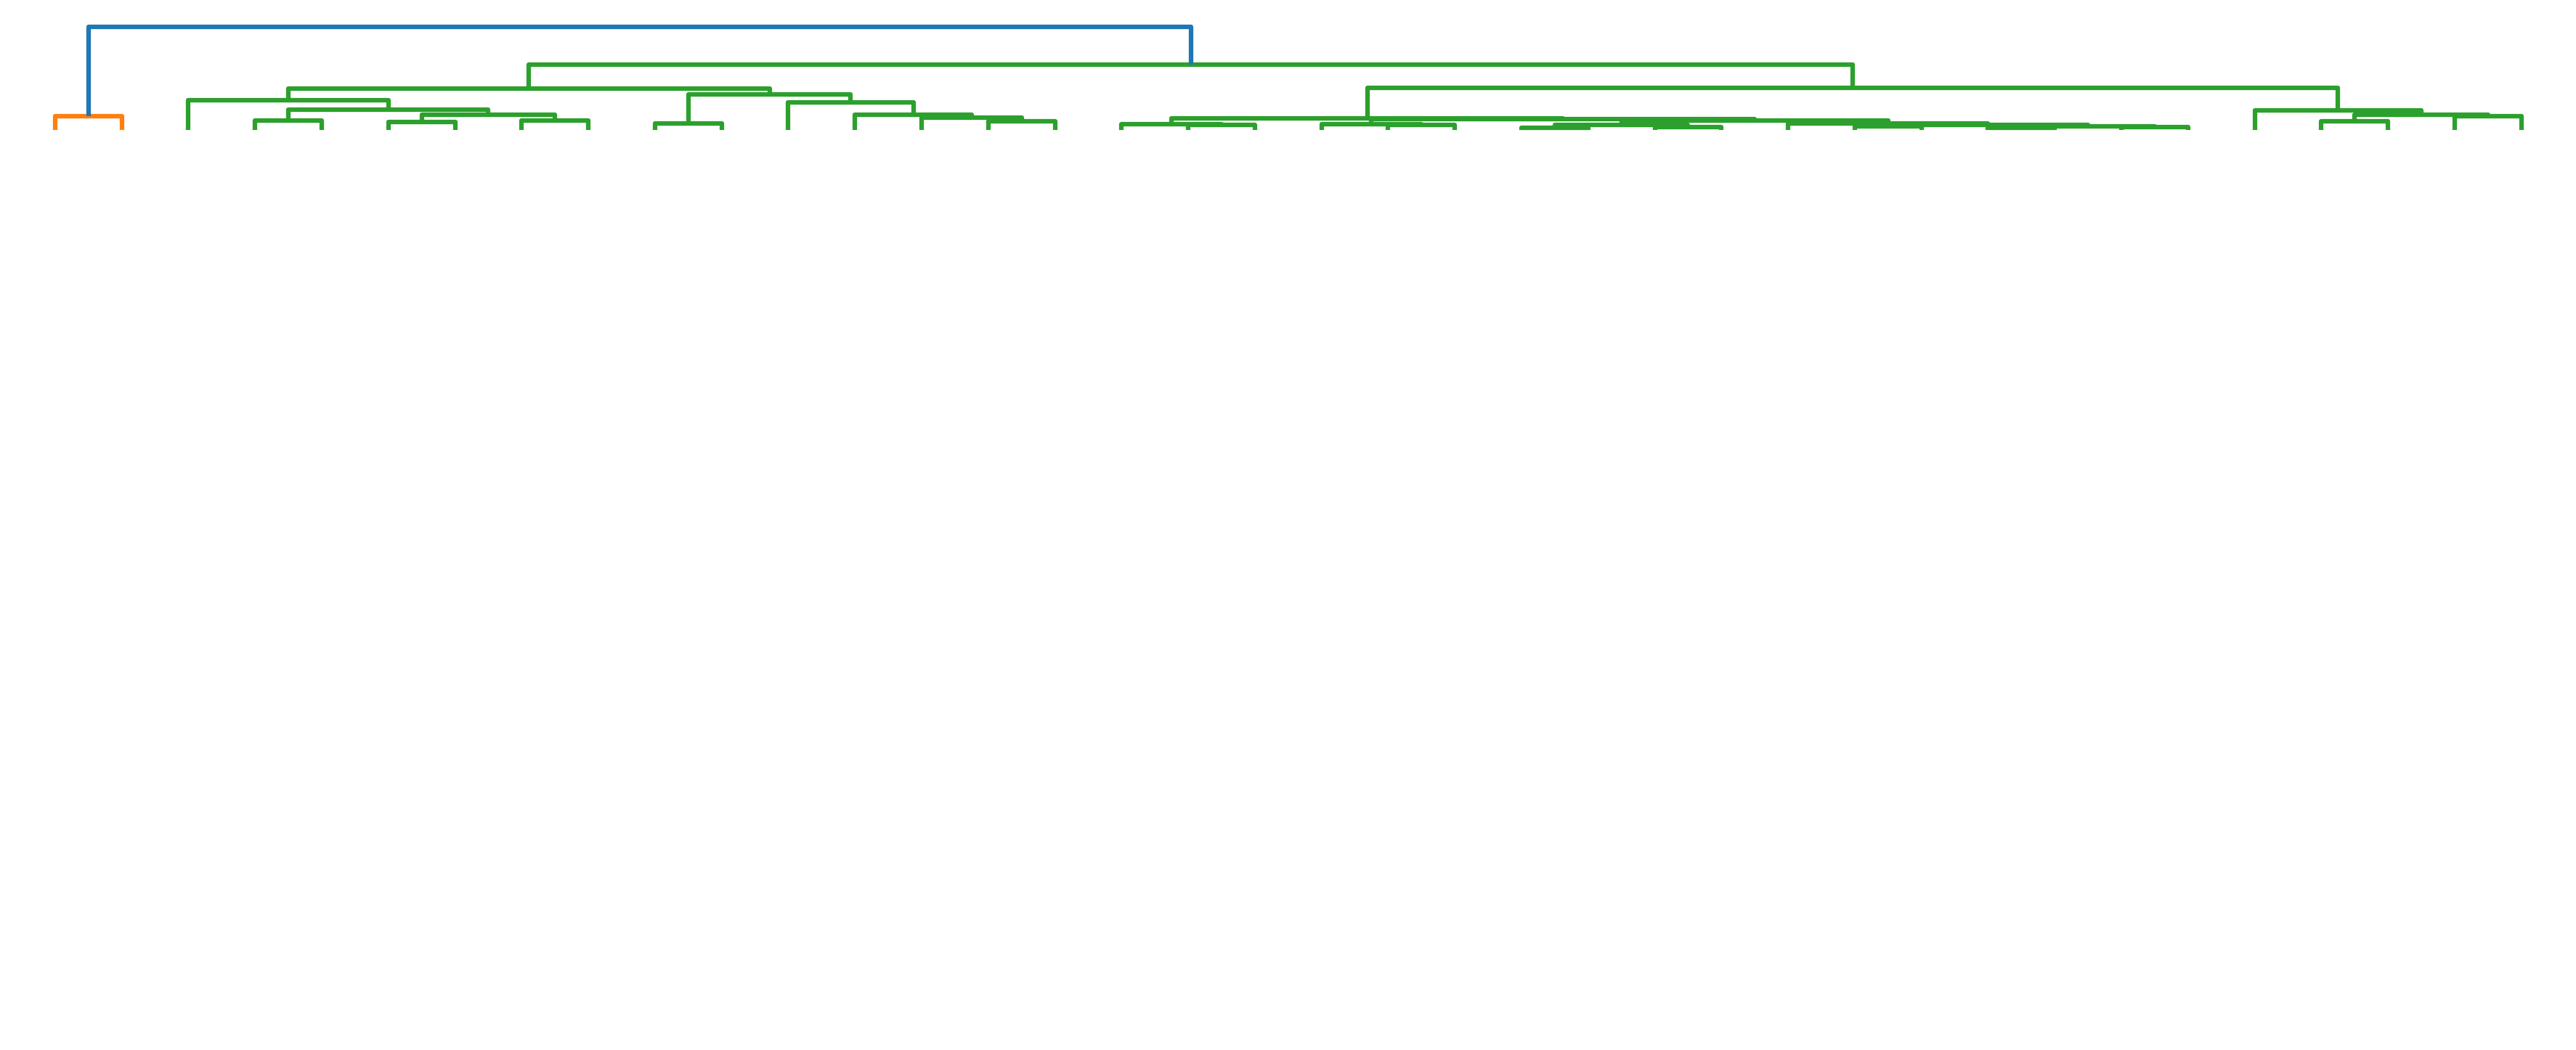

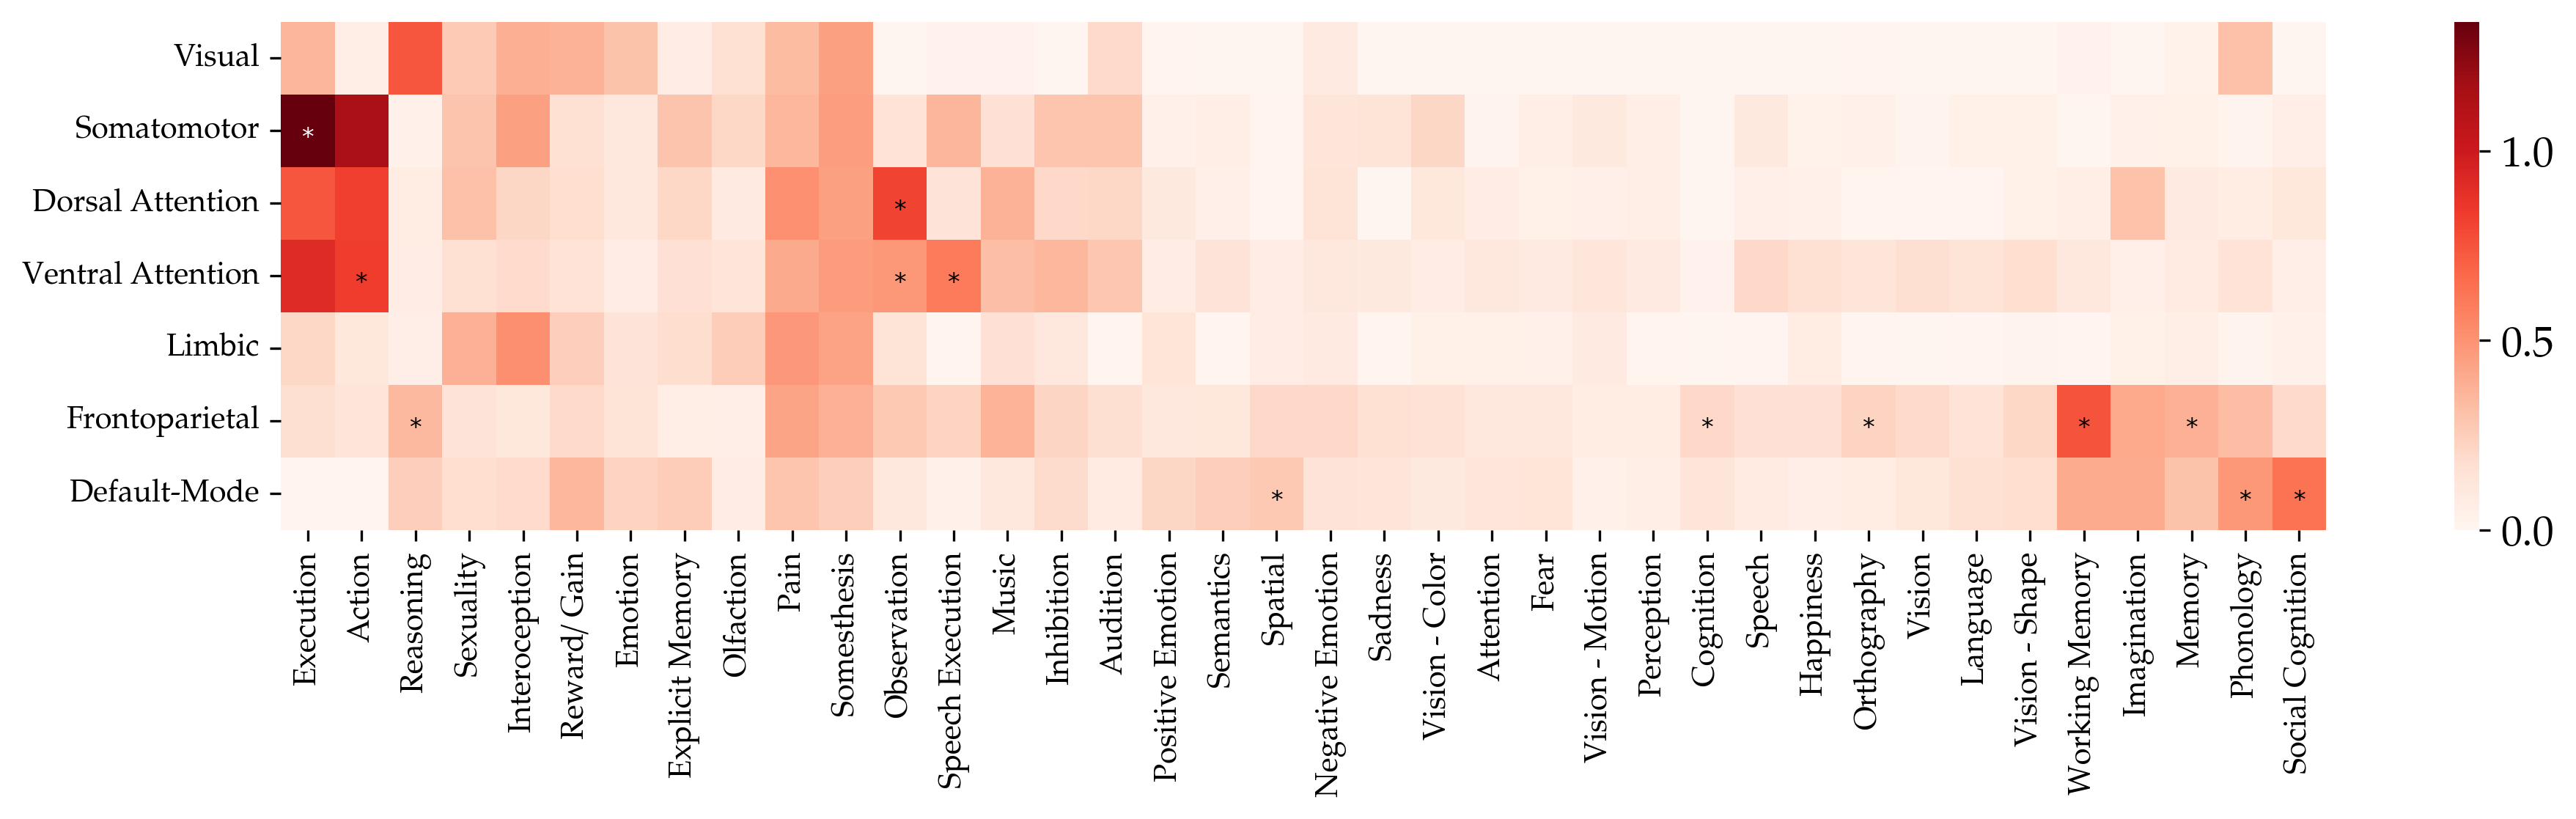

In [51]:
# Perform hierarchical clustering and plot dendrogram
fig, ax = plt.subplots(figsize=(15, 6))
model, dendro, leaf_order = utils.hierarchical_clustering(obs_mean.T, no_plot=False, ax=ax)
ax.set_ylim([-25, ax.get_ylim()[1]])
ax.axis('off')

# reorder the original data
mean_reordered = obs_mean.iloc[:, leaf_order]
# FDR correction
sig_fdr, _ = statsmodels.stats.multitest.fdrcorrection(p.values.flatten())
# reorder
sig_fdr = pd.DataFrame(sig_fdr.reshape(p.shape), index=p.index, columns=p.columns)
# p_reordered = p.iloc[:, leaf_order]
sig_fdr_reordered = sig_fdr.iloc[:, leaf_order]

# Plot the reordered data
fig, ax = plt.subplots(figsize=(15, 3))
sns.heatmap(mean_reordered, cmap='Reds',linecolor='.8', ax=ax)
ax.set_xticks(np.arange(p.shape[1])+0.5)
ax.set_xticklabels(utils.bd_labels.loc[mean_reordered.columns].values, rotation=90, horizontalalignment='center', fontsize=10)
ax.set_yticks(np.arange(p.shape[0])+0.5)
ax.set_yticklabels(mean_reordered.index, rotation=0, fontsize=10)
ax.set_ylabel('')
# add the * layer
for x, col in enumerate(mean_reordered.columns):
    for y, row in enumerate(mean_reordered.index):
        if sig_fdr.loc[row, col]:
            text = r'$*$'
            # Conditional color based on the value of r
            text_color = 'white' if mean_reordered.loc[row, col] > 1.0  else 'black'
            ax.text(x+0.5, y+0.6,
                    text, 
                    fontsize=8,
                    color=text_color,
                    horizontalalignment='center', 
                    verticalalignment='center')

## S11b. Ji et al. (2019) cortical-subcortical atlas.

In [52]:
# Load data
ji = nibabel.load(os.path.join(INPUT_DIR, 'cerebellar_atlases/Ji_2019/atl-Ji10_space-MNI_dseg.nii'))

In [53]:
ji_labels = pd.Series({ ## Inferred labels based on inspection of the parcels.
    '0': 'Background',
    '1': 'Primary Visual',
    '2': 'Secondary Visual',
    '3': 'Somatomotor',
    '4': 'Cingulo-Opercular',
    '5': 'Dorsal Attention',
    '6': 'Language',
    '7': 'Frontoparietal',
    '8': 'Auditory',
    '9': 'Default-Mode',
    '10': 'Posterior Multimodal'
})

### Inspect the parcellation

In [54]:
# Extract the data array
ji_data = ji.get_fdata()
# Get unique labels
unique_labels = np.unique(ji_data)
# Print the unique labels and their count
print(f"Unique labels in jd_data: {unique_labels}")
print(f"Number of unique labels: {len(unique_labels)}")

Unique labels in jd_data: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
Number of unique labels: 11


In [55]:
# Check the data type of the loaded Ji atlas
print(f"Data type of Ji atlas before resampling: {ji.get_fdata().dtype}")
# Load the mask image
proper_mask_2mm = nibabel.load(os.path.join(INPUT_DIR, 'maps/D2009_MNI_2mm.nii.gz'))
# Resample the Ji atlas to the mask
ji_mni_2mm = nilearn.image.resample_to_img(ji, proper_mask_2mm)
# Check the data type of the resampled Ji atlas
print(f"Data type of Ji atlas after resampling: {ji_mni_2mm.get_fdata().dtype}")
# Convert the data back to integer if necessary! It is important to check that the labels are still the correct number.
ji_mni_2mm_data = ji_mni_2mm.get_fdata().astype(np.int32)
ji_mni_2mm = nibabel.Nifti1Image(ji_mni_2mm_data, ji_mni_2mm.affine, ji_mni_2mm.header)

Data type of Ji atlas before resampling: float64
Data type of Ji atlas after resampling: float64


In [56]:
# Check unique labels after resampling
unique_labels = np.unique(ji_mni_2mm.get_fdata())
print(f"Unique labels in resampled Ji atlas: {unique_labels}")
print(f"Number of unique labels: {len(unique_labels)}")

# Check if the number of unique labels is 11 (the number in the original map).
if len(unique_labels) == 11:
    print("The data contains 11 unique labels as expected.")
else:
    print(f"Warning: The data contains {len(unique_labels)} unique labels instead of 11.")

Unique labels in resampled Ji atlas: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
Number of unique labels: 11
The data contains 11 unique labels as expected.


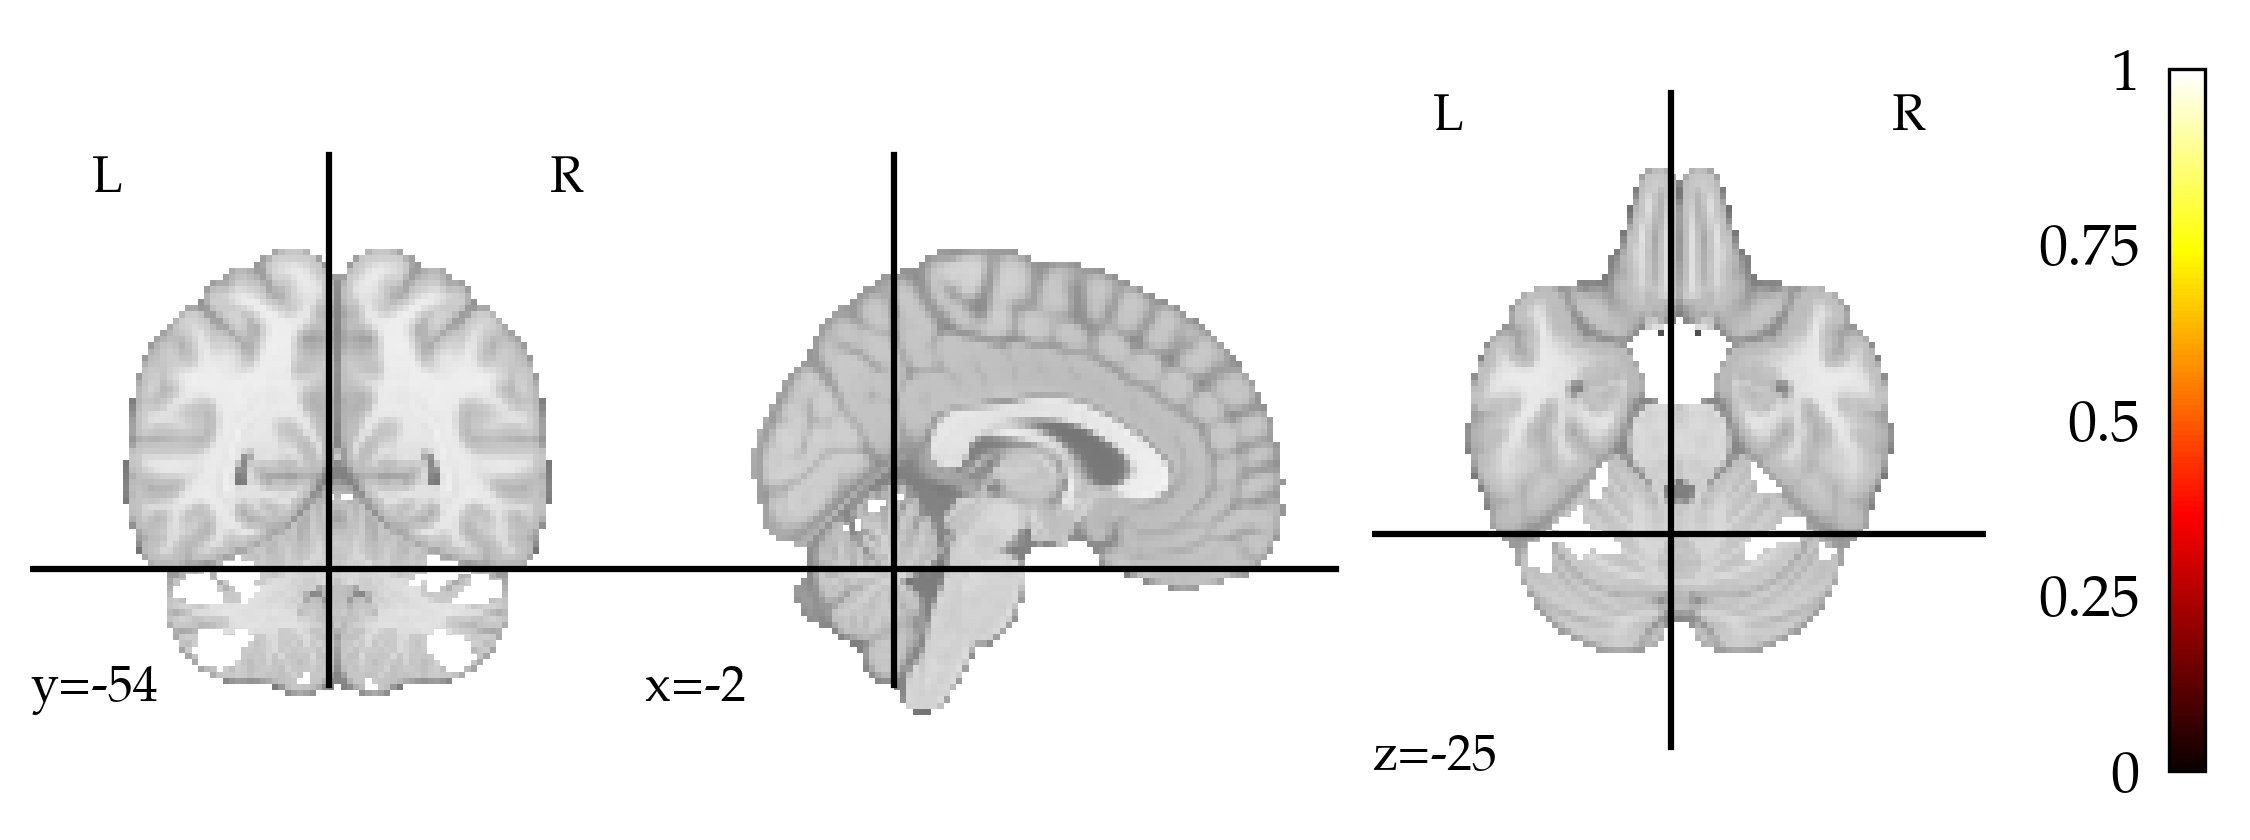

In [57]:
# Plot a single, example, parcel and check if it is includes L/R parcels.
nilearn.plotting.plot_stat_map(nilearn.image.math_img('a == 4', a=ji_mni_2mm))

The parcellation includes left and right parcels and neatly overlaps the cerebellum, good.

### Visualise with original colors to check what each region corresponds to.

In [58]:
# Load the color lookup table
tsv_file = (os.path.join(INPUT_DIR, 'cerebellar_atlases/Ji_2019/atl-Ji10.tsv'))
lookup_table = pd.read_csv(tsv_file, sep='\t')
lookup_table

index      name    color
0      1   Region1  #8fe399
1      2   Region2  #0053b8
2      3   Region3  #3c0099
3      4   Region4  #009999
4      5   Region5  #4e9dff
5      6   Region6  #ffff00
6      7   Region7  #ffe3c3
7      8   Region8  #b05828
8      9   Region9  #db133c
9     10  Region10  #ff9c00

In [59]:
# Create a dictionary to map region index to color
index_to_color = {row['index']: row['color'] for _, row in lookup_table.iterrows()}
# Create a dictionary, mapping region index to RGB color.
index_to_color = {
    1: (0.5647, 0.8902, 0.6000),
    2: (0.0000, 0.3255, 0.7216),
    3: (0.2392, 0.0000, 0.6000),
    4: (0.0000, 0.6039, 0.6039),
    5: (0.3098, 0.6157, 1.0000),
    6: (1.0000, 1.0000, 0.0000),
    7: (1.0000, 0.8941, 0.7686),
    8: (0.6941, 0.3490, 0.1569),
    9: (0.8627, 0.0784, 0.2353),
    10: (1.0000, 0.6118, 0.0000)
}

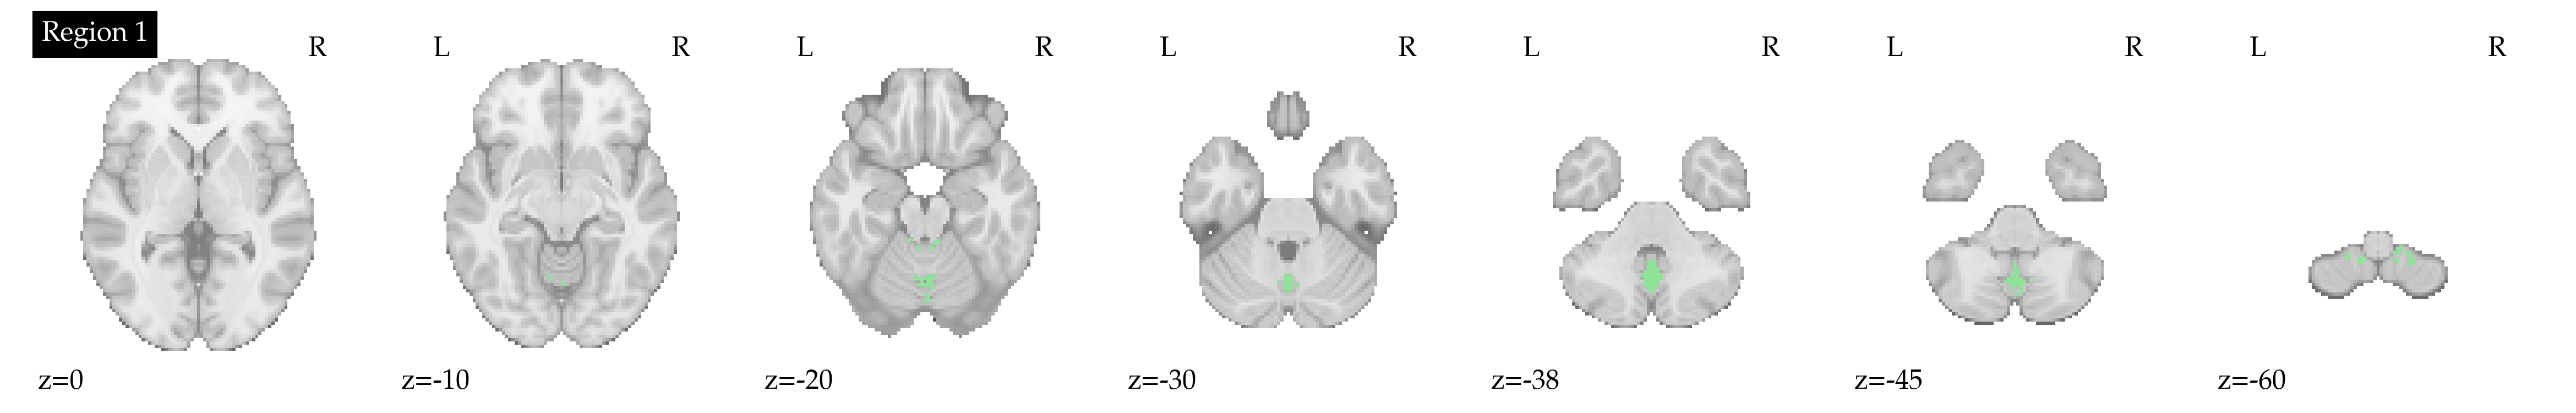

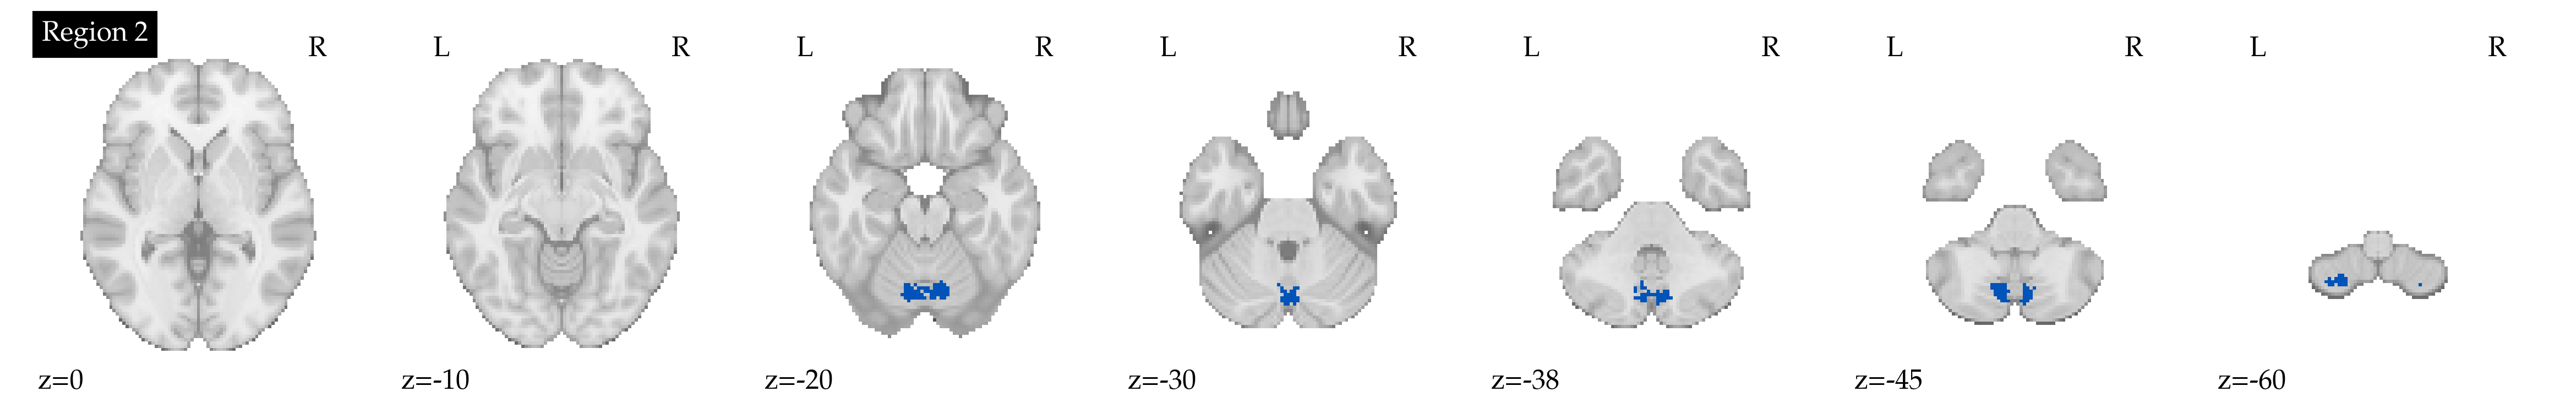

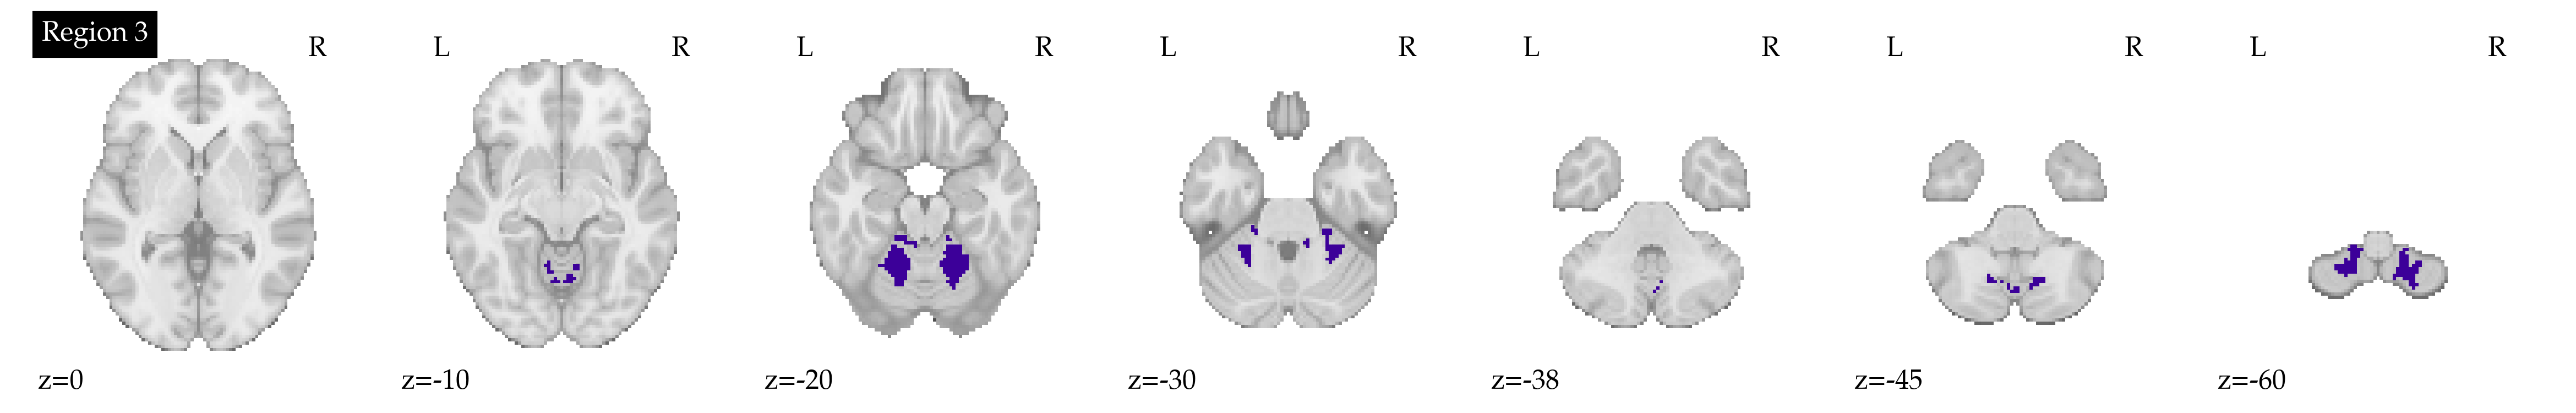

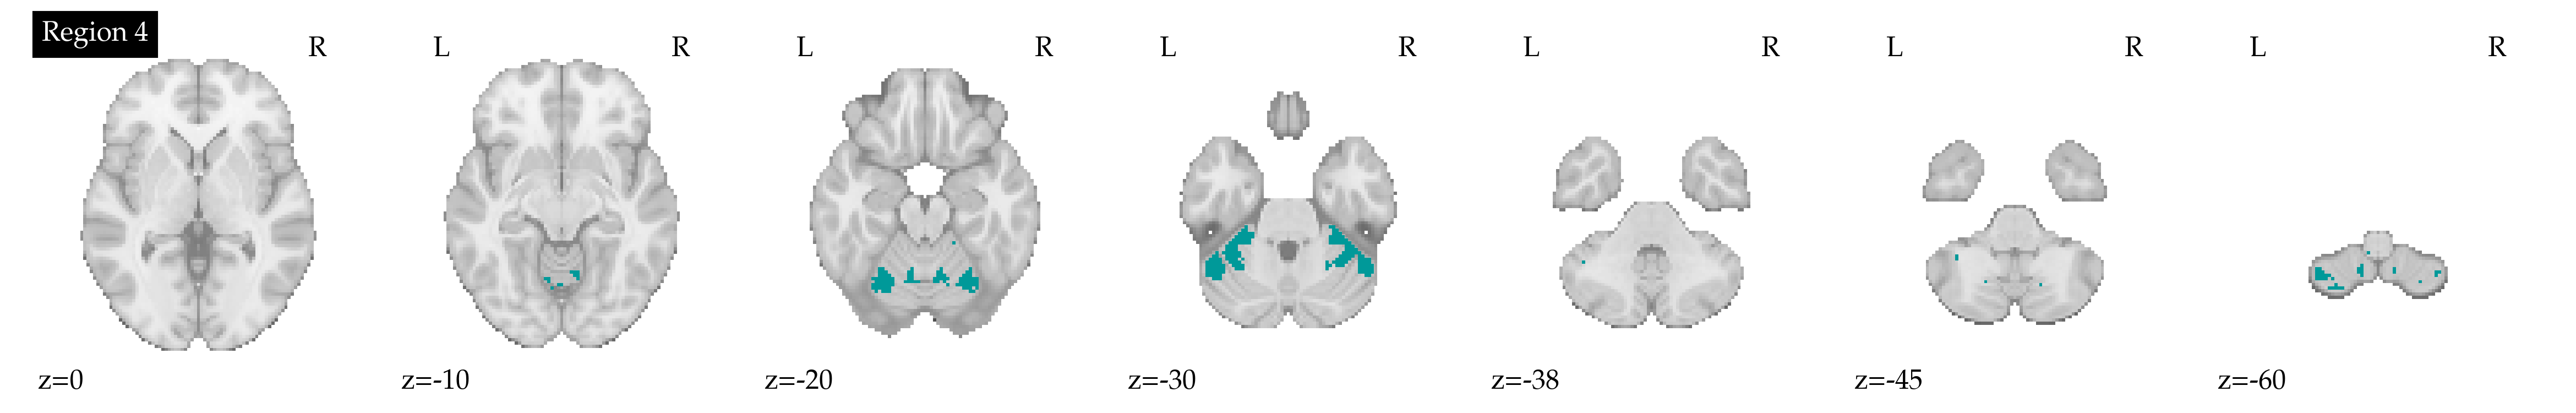

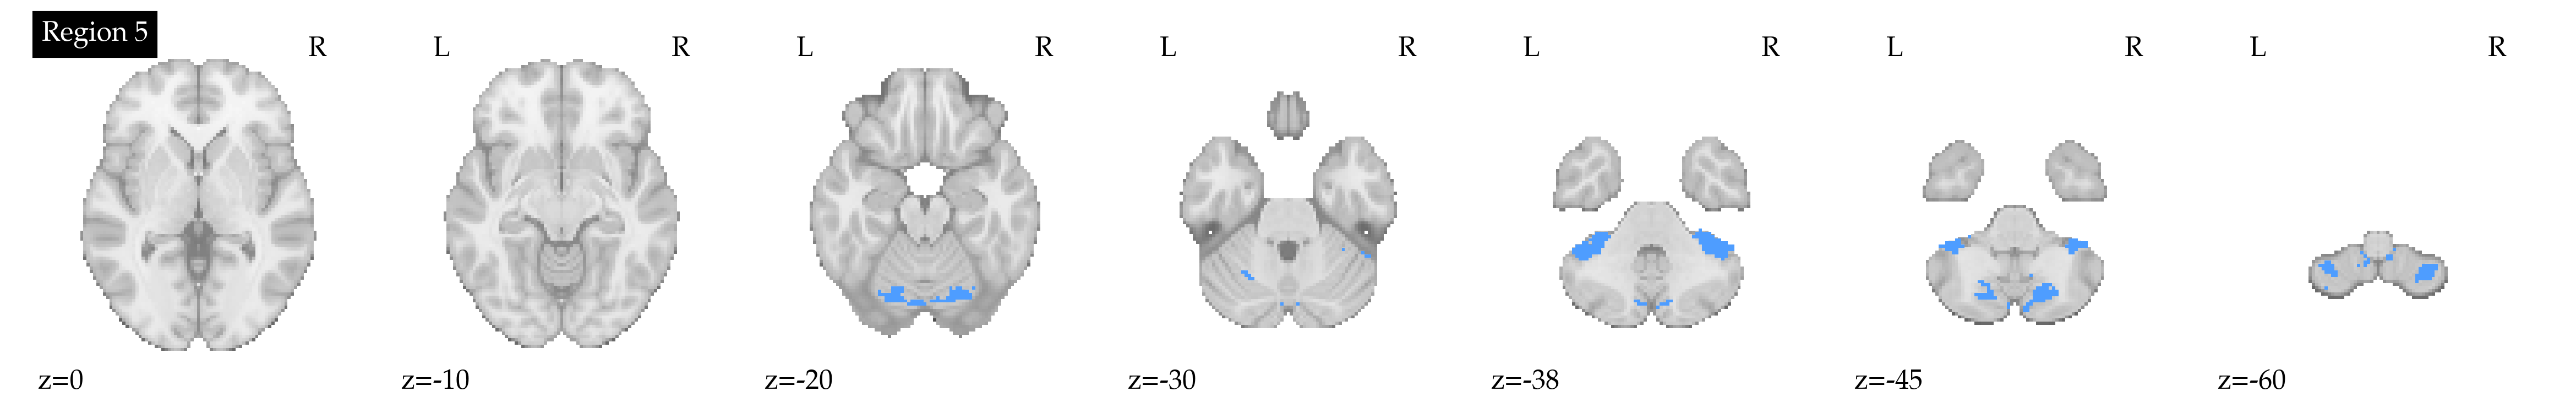

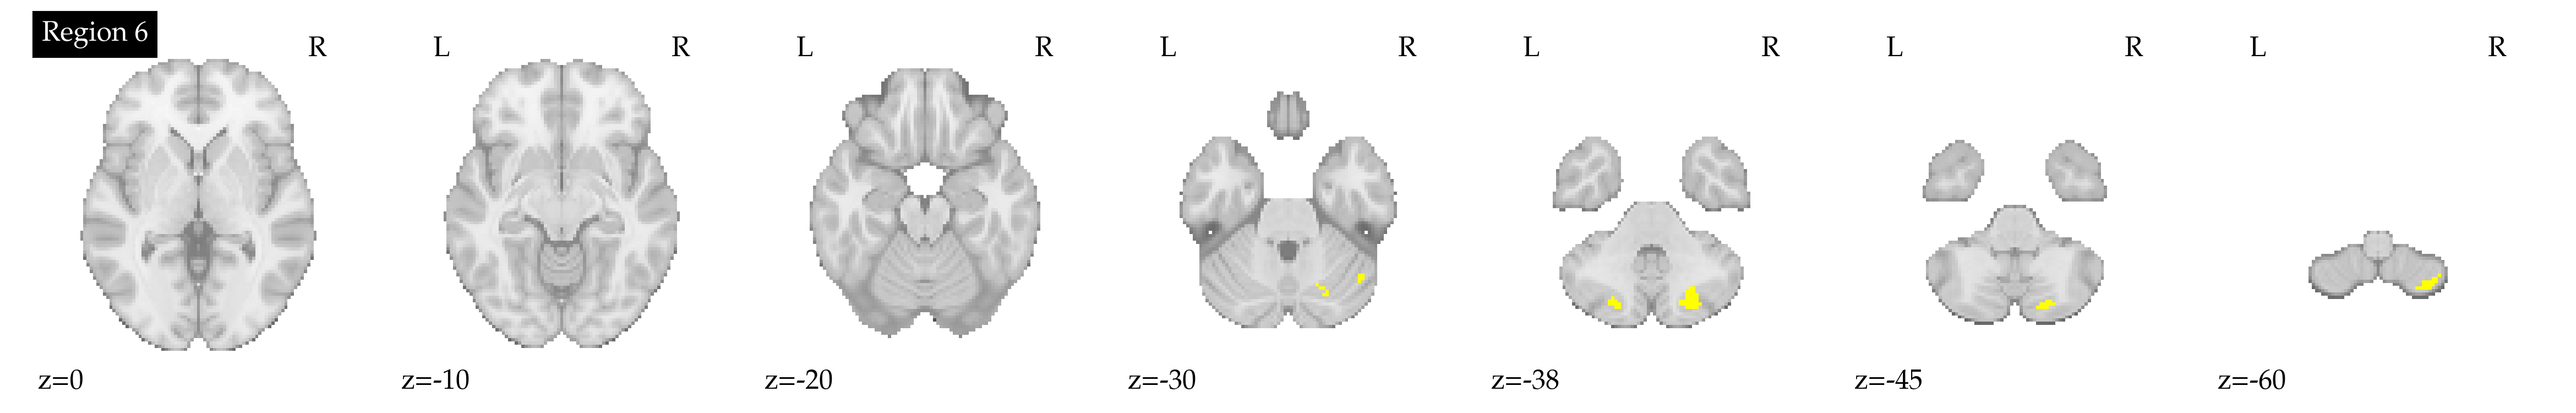

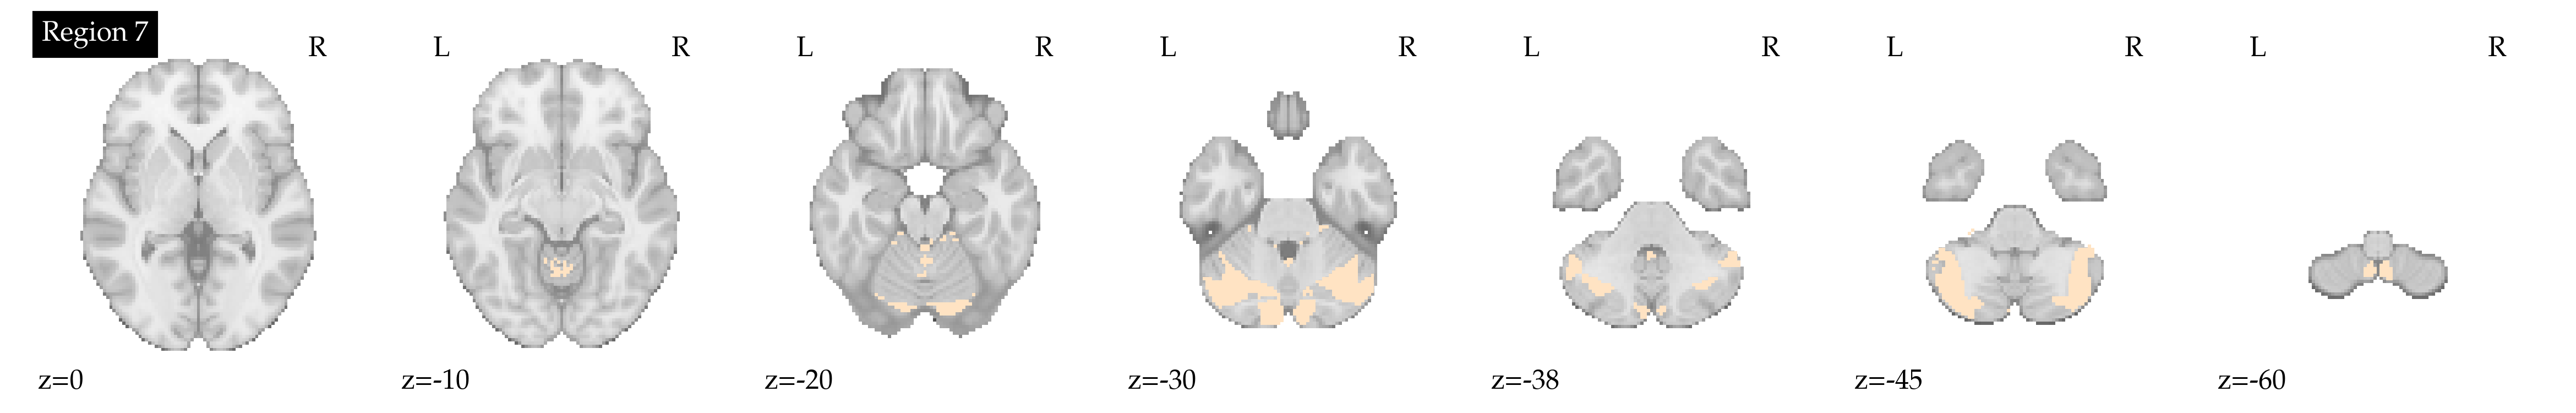

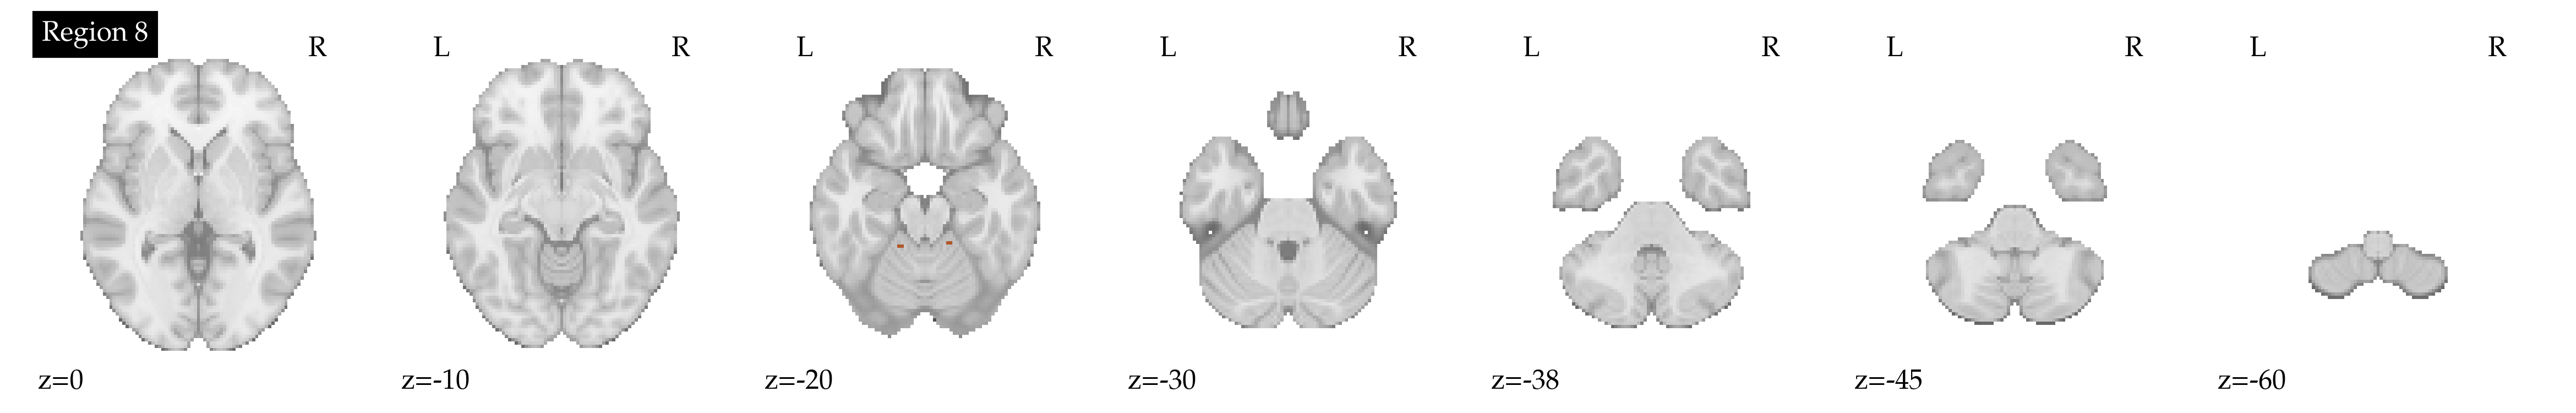

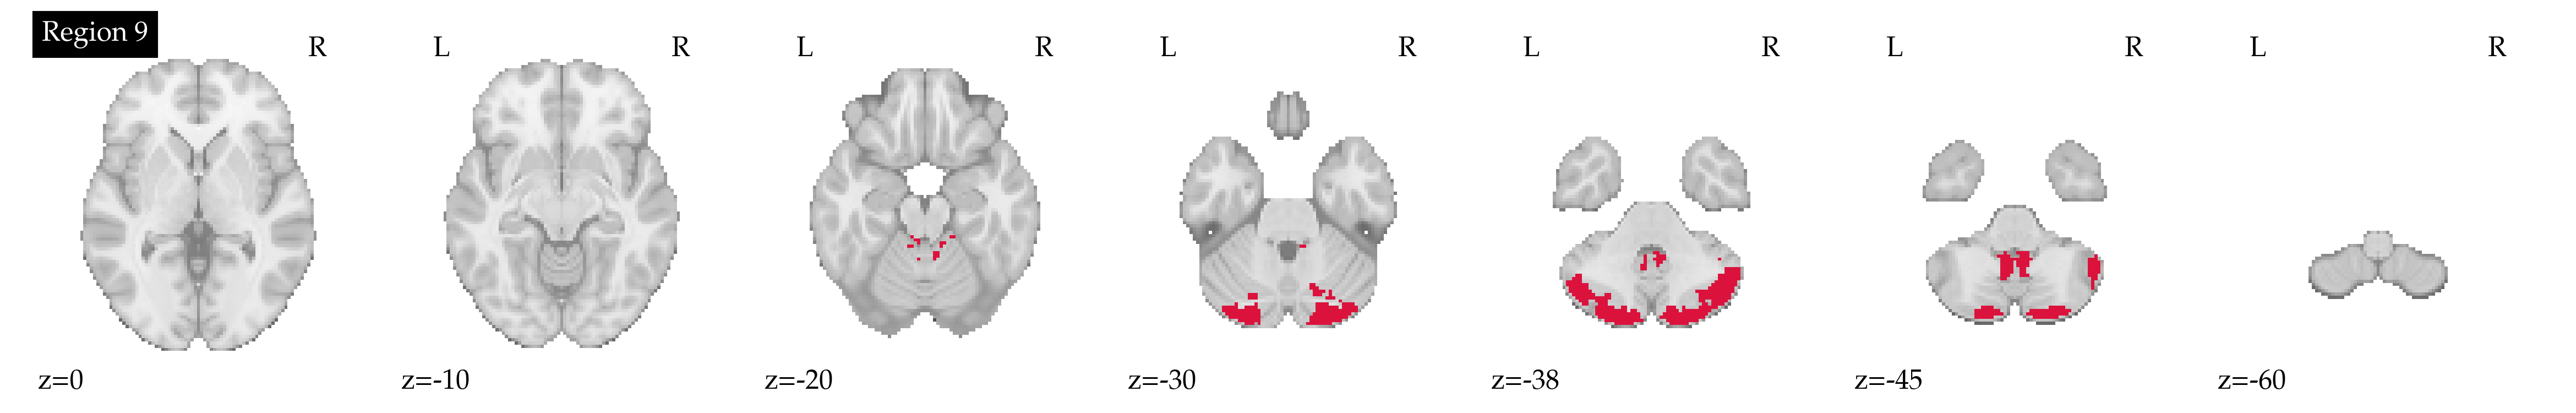

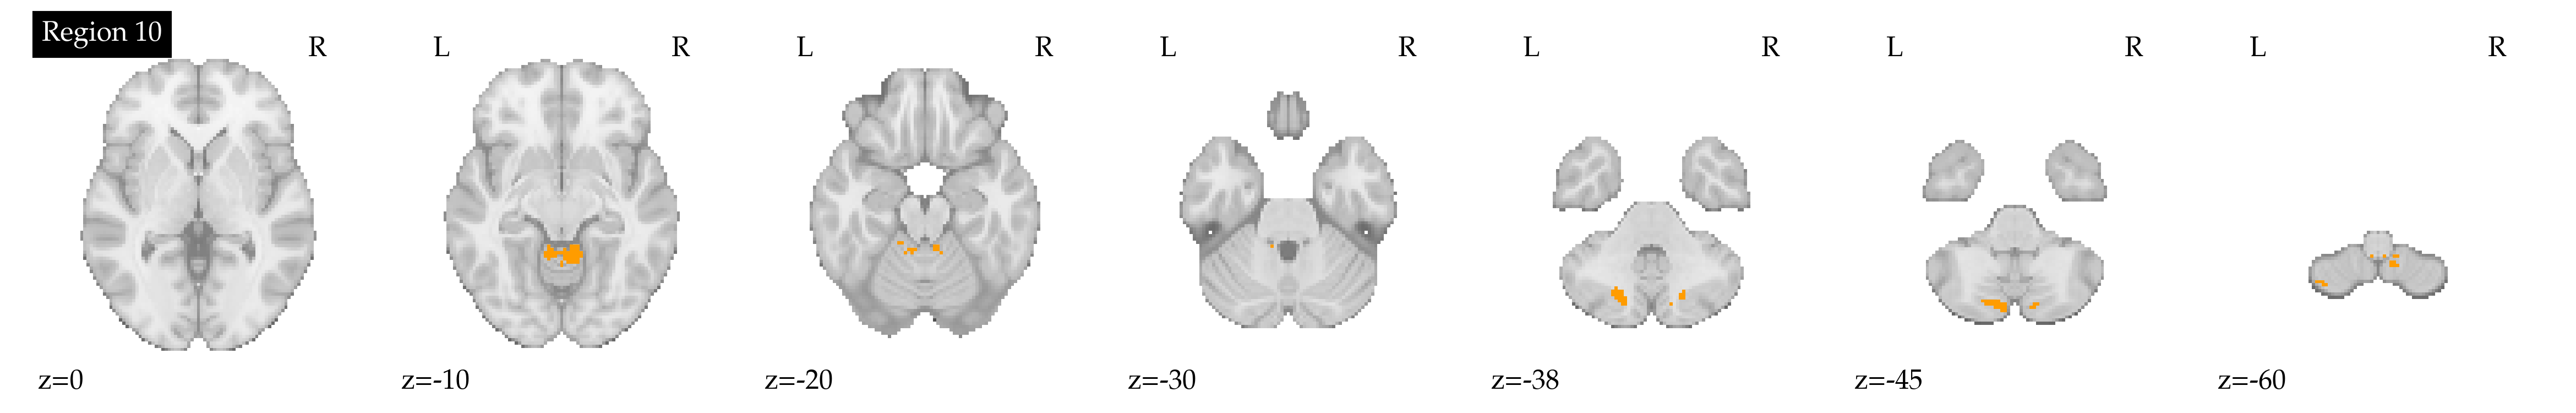

In [60]:
cut_coords= [0, -10, -20, -30, -38, -45, -60]  # Use the same slice coordinates for all.
# Loop through each colored region and plot it
for index, color in index_to_color.items():
    # Create a binary mask for the region
    region_img = nilearn.image.math_img('a == {}'.format(index), a=ji_mni_2mm)
    # Plot the region using the specified color
    display = nilearn.plotting.plot_stat_map(
        region_img, 
        colorbar=False, 
        display_mode='z', 
        threshold=0.5, 
        cut_coords=cut_coords,
        cmap=plt.cm.colors.ListedColormap([color]), 
        #title=f'Region {index}'
    )
    display.title(f'Region {index}', size=12)
    plt.show()

Regions (Figure 1b of Ji et al. 2019):
1. Primary Visual
2. Secondary Visual
3. Somatomotor
4. Cingulo-Opercular
5. Dorsal Attention
6. Language
7. Frontoparietal
8. Auditory (?; this is really difficult to see in the publication but inferred from the consistent order observed in other labels)
9. Default-Mode
10. Posterior Multimodal

Missing are Ventral Multimodal and Orbito-Affective.

### Run variogram-based mean test

In [61]:
if os.path.exists(os.path.join(CORR_DIR, 'z_ji10_dseg_mean.csv')) and os.path.exists(os.path.join(CORR_DIR, 'z_ji10_dseg_p.csv')):
    obs_mean = pd.read_csv(os.path.join(CORR_DIR, 'z_ji10_dseg_mean.csv'), index_col=0)
    p = pd.read_csv(os.path.join(CORR_DIR, 'z_ji10_dseg_p.csv'), index_col=0)
    # Display the dataframes
    print(obs_mean)
    print(p)
else:
    mask_data = proper_mask_2mm.get_fdata().astype('bool')
    ji_mni_2mm_masked =  ji_mni_2mm.get_fdata()[mask_data]
    obs_mean = pd.DataFrame(index=range(11)) # Corresponds to the number of parcels (+1, background)
    p = pd.DataFrame(index=range(11))
    surrogates_paths = sorted(glob.glob(os.path.join(OUTPUT_DIR,
        'SALE/*/*/uncorr_z_2mm_mask-D2009_MNI_surrogates-variogram_n-1000.npy')
    ))
    for surrogates_path in tqdm(surrogates_paths):
        # Extract subbd using regex for better reliability
        subbd_match = re.search(r'SALE/(.*?)/(.*?)/', surrogates_path)
        if subbd_match:
            subbd = subbd_match.group(2)
        else:
            print(f"Failed to parse subbd from path: {surrogates_path}")
            continue
        # load z map and mask it
        z_2mm = os.path.join(os.path.dirname(surrogates_path), 'uncorr_z_2mm.nii.gz')
        z_2mm_masked = nibabel.load(z_2mm).get_fdata()[mask_data]
        # load surrogates
        surrogates = np.load(surrogates_path)
        obs_mean.loc[:, subbd] = pd.DataFrame(
            {'ji': ji_mni_2mm_masked,
            'z': z_2mm_masked}
        ).groupby('ji').mean().values.flatten()
        # This step makes the calculations a ton faster.
        null_mean = (
            pd.DataFrame(surrogates.T, index=ji_mni_2mm_masked)
            .reset_index(drop=False)
            .groupby('index')
            .mean().values
        )
        p.loc[:, subbd] = (np.abs(null_mean) >= np.abs(obs_mean.loc[:, subbd].values[:, None])).mean(axis=1)
    # label
    obs_mean.index = ji_labels
    p.index = ji_labels
    # drop null
    obs_mean = obs_mean.drop(index='Background')
    p = p.drop(index='Background')
    # Display the resulting dataframes
    print(obs_mean)
    print(p)
    # Save to csv
    obs_mean.to_csv(os.path.join(CORR_DIR, 'z_ji10_dseg_mean.csv'))
    p.to_csv(os.path.join(CORR_DIR, 'z_ji10_dseg_p.csv'))

100%|█████████████████████████████████████████████████████████████████████████████████| 38/38 [00:52<00:00,  1.38s/it]

                      Action.Execution.Speech  Action.Execution  \
Primary Visual                   2.947981e-01          0.918895   
Secondary Visual                 7.850715e-01          0.965646   
Somatomotor                      4.704920e-01          1.504694   
Cingulo-Opercular                5.844054e-01          0.872407   
Dorsal Attention                 3.443661e-01          0.580695   
Language                         9.452295e-02          0.269753   
Frontoparietal                   1.364696e-01          0.098157   
Auditory                         3.884002e-18          0.383610   
Default-Mode                     2.431314e-02          0.005048   
Posterior Multimodal             2.582662e-02          0.086469   

                      Action.Imagination  Action.Inhibition  \
Primary Visual              7.285606e-02           0.069502   
Secondary Visual            3.307140e-02           0.173605   
Somatomotor                 4.062140e-02           0.241244   
Cingulo-Op

### S11b. Plot hierarchically

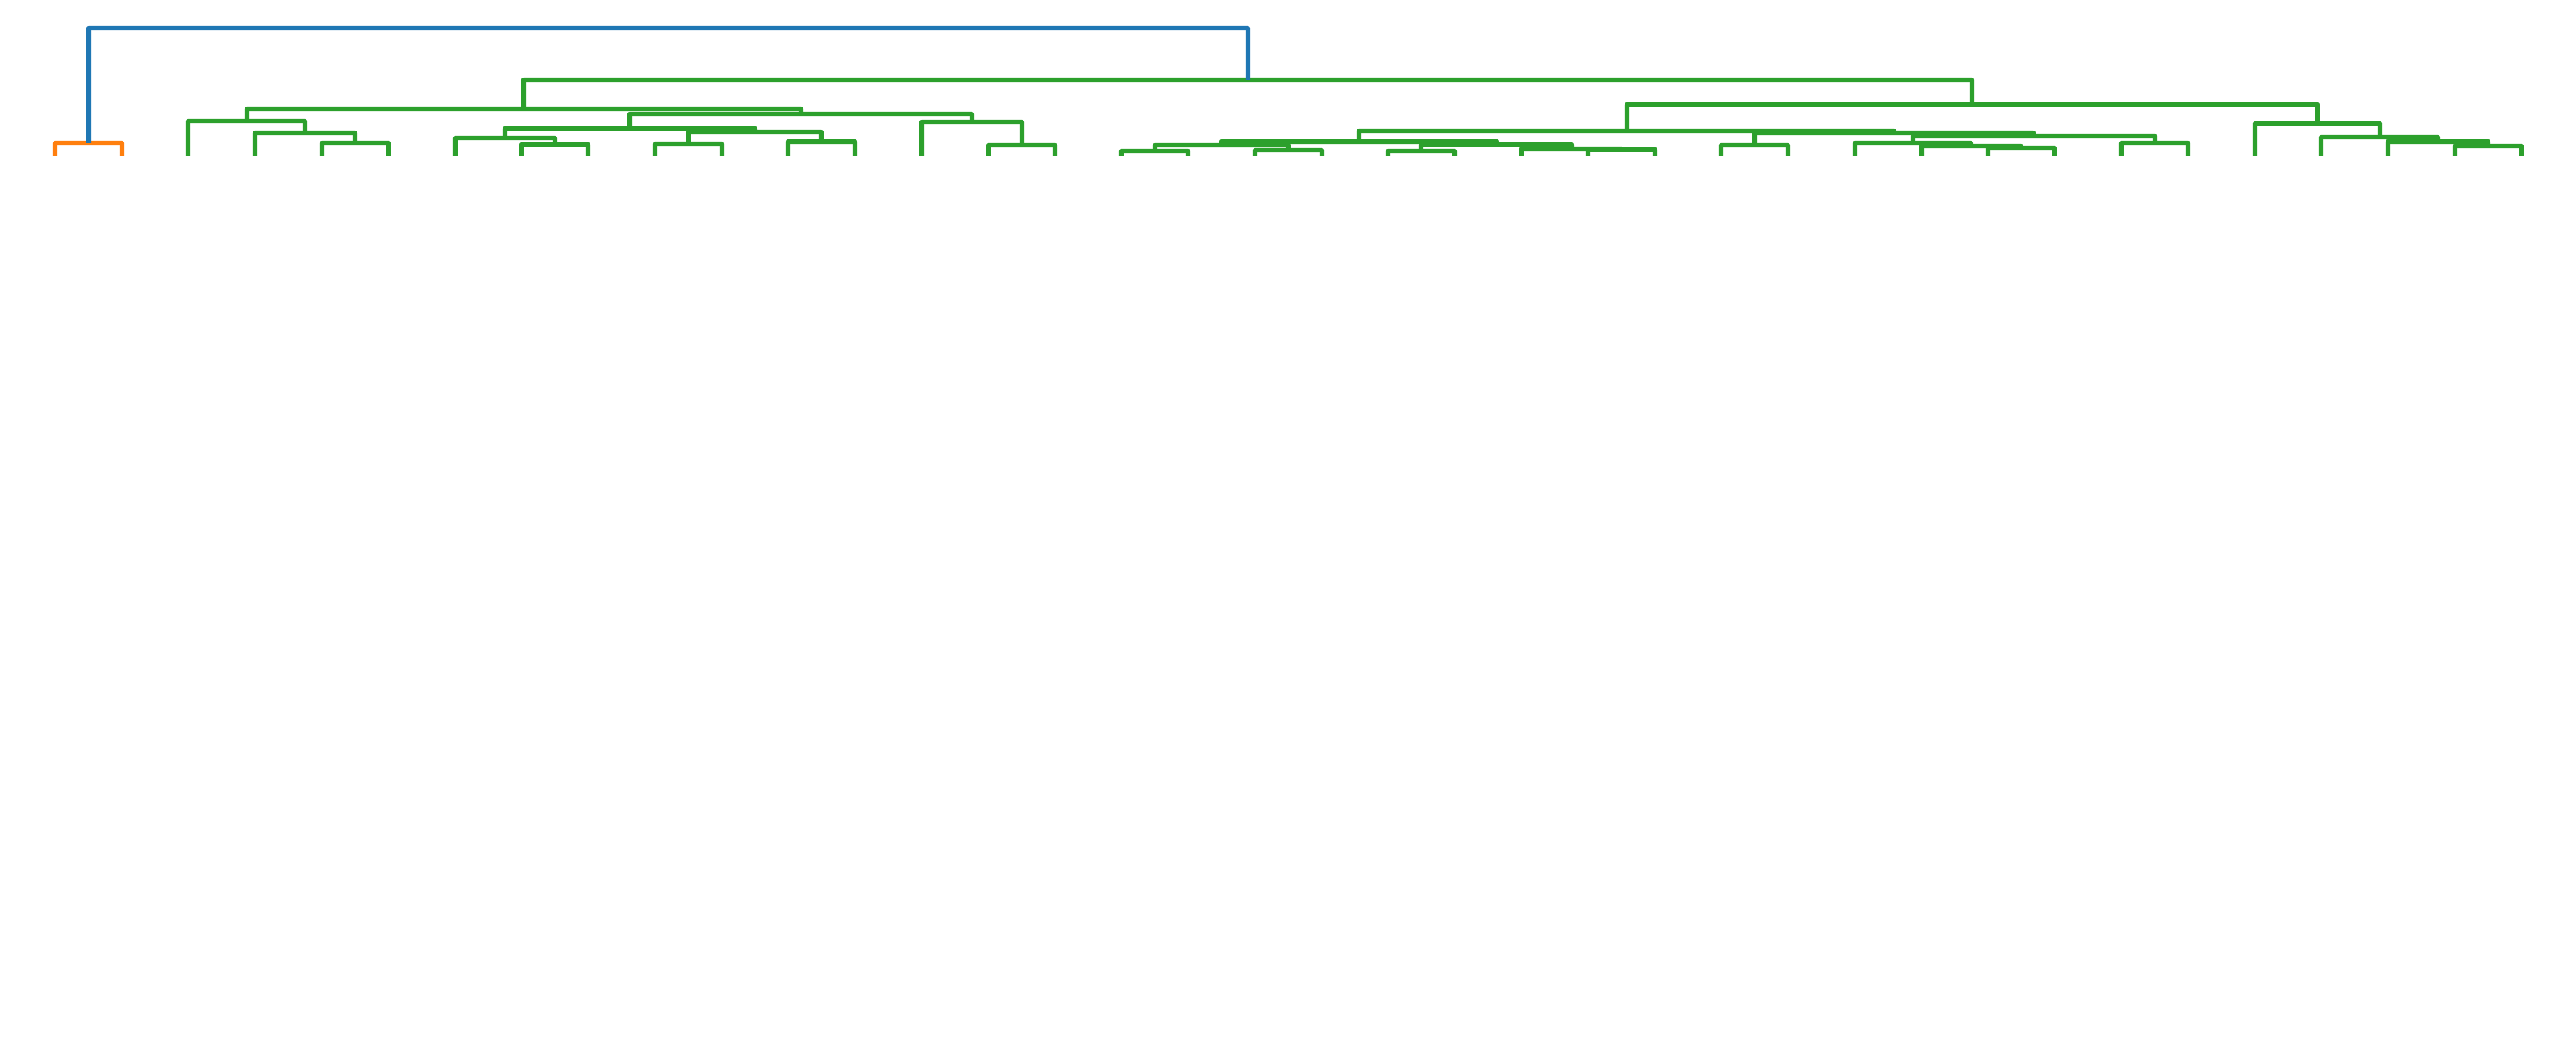

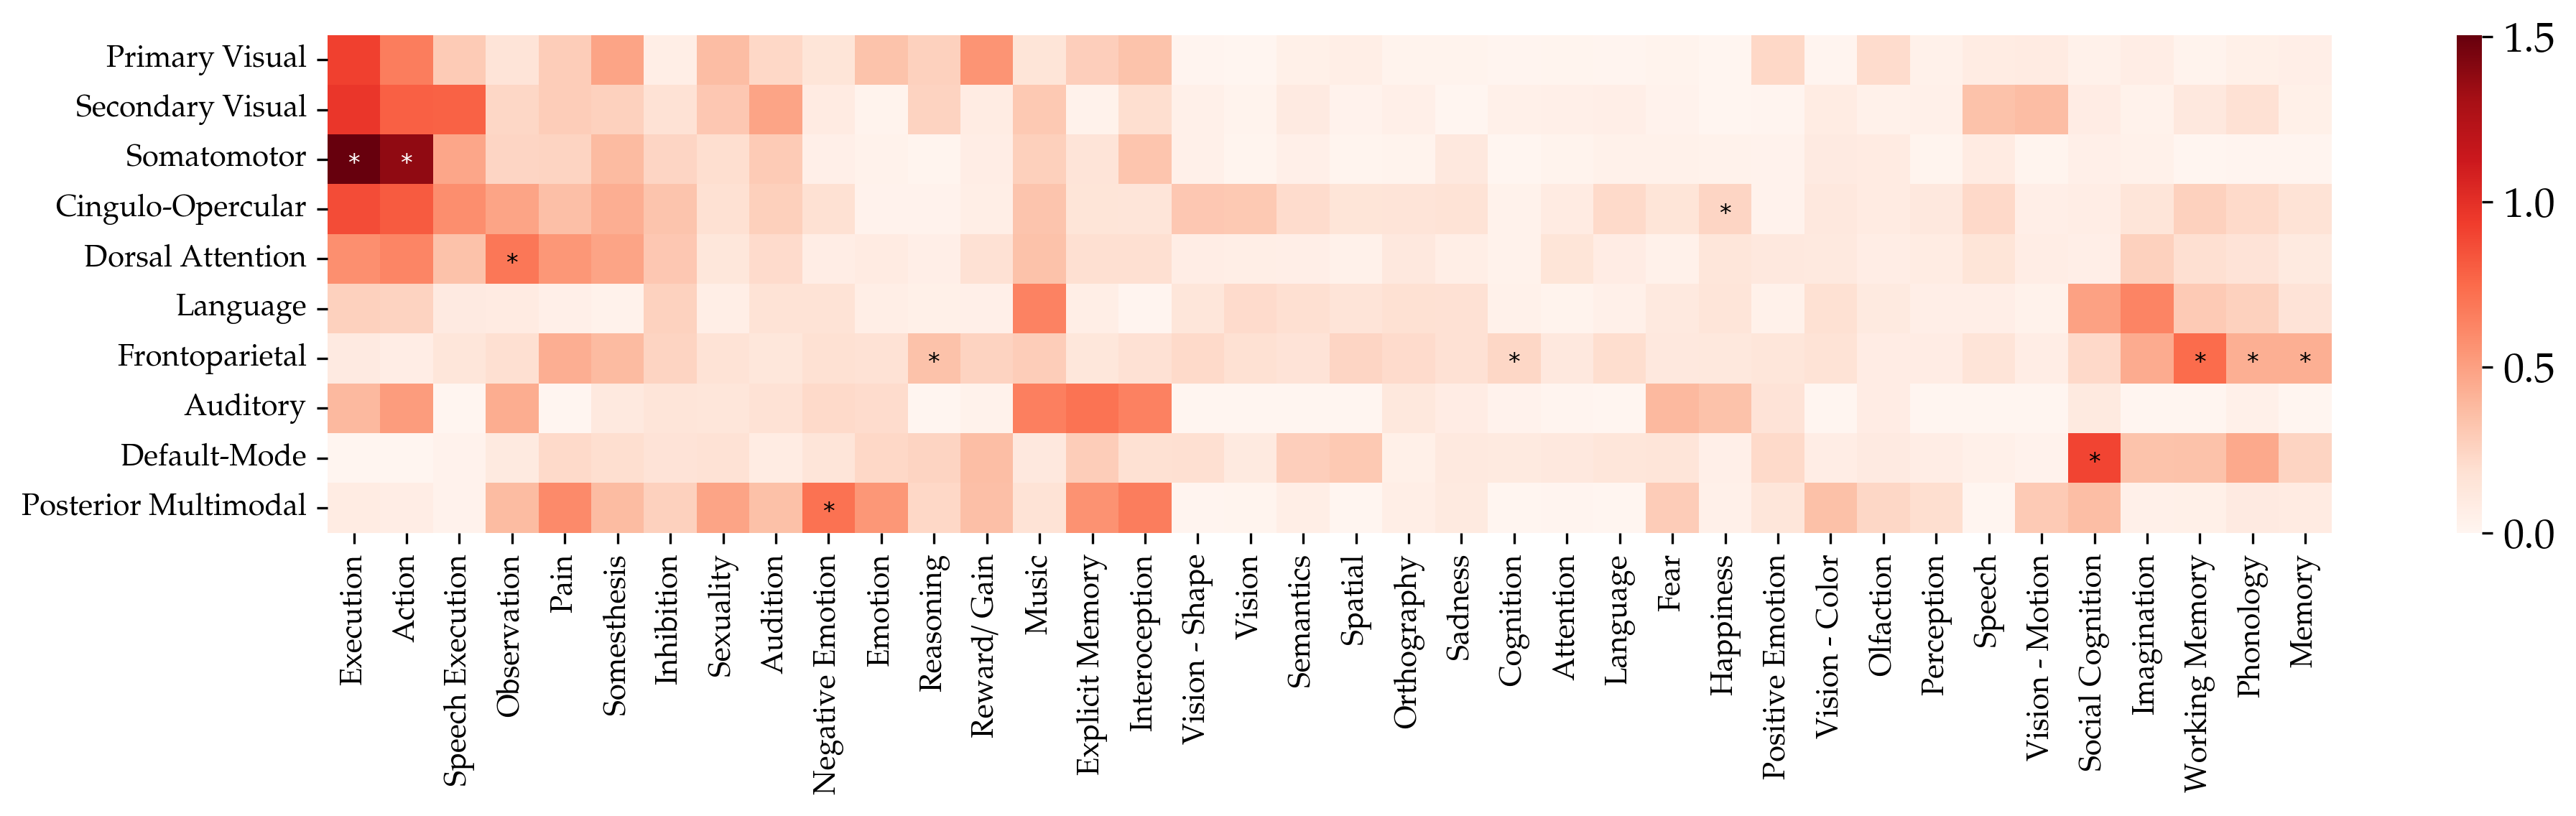

In [62]:
# Perform hierarchical clustering and plot dendrogram
fig, ax = plt.subplots(figsize=(15, 6))
model, dendro, leaf_order = utils.hierarchical_clustering(obs_mean.T, no_plot=False, ax=ax)
ax.set_ylim([-25, ax.get_ylim()[1]])
ax.axis('off')

# reorder the original data
mean_reordered = obs_mean.iloc[:, leaf_order]
# FDR correction
sig_fdr, _ = statsmodels.stats.multitest.fdrcorrection(p.values.flatten())
# reorder
sig_fdr = pd.DataFrame(sig_fdr.reshape(p.shape), index=p.index, columns=p.columns)
# p_reordered = p.iloc[:, leaf_order]
sig_fdr_reordered = sig_fdr.iloc[:, leaf_order]

# plot the reordered data
fig, ax = plt.subplots(figsize=(15, 3))
sns.heatmap(mean_reordered, cmap='Reds',linecolor='.8', ax=ax)
ax.set_xticks(np.arange(p.shape[1])+0.5)
ax.set_xticklabels(utils.bd_labels.loc[mean_reordered.columns].values, rotation=90, horizontalalignment='center', fontsize=10)
ax.set_yticks(np.arange(p.shape[0])+0.5)
ax.set_yticklabels(mean_reordered.index, rotation=0, fontsize=10)
ax.set_ylabel('')
# add the * layer
for x, col in enumerate(mean_reordered.columns):
    for y, row in enumerate(mean_reordered.index):
        if sig_fdr.loc[row, col]:
            text = r'$*$'
            # Conditional color based on the value of r
            text_color = 'white' if mean_reordered.loc[row, col] > 1.0  else 'black'
            ax.text(x+0.5, y+0.6,
                    text, 
                    fontsize=8,
                    color=text_color,
                    horizontalalignment='center', 
                    verticalalignment='center')

## S12a. Deterministic cerebellar lobules (Diedrichsen 2009).

In [63]:
# Load data
jd = nibabel.load(os.path.join(INPUT_DIR, 'cerebellar_atlases/Diedrichsen_2009/atl-Anatom_space-MNI_dseg.nii'))

In [64]:
jd_labels = pd.Series({
    # '0': 'Background', # Commented out missing parcels.
    '1': 'Left I-IV',
    '2': 'Right I-IV',
    '3': 'Left V',
    '4': 'Right V',
    '5': 'Left VI',
    '6': 'Vermis VI',
    '7': 'Right VI',
    '8': 'Left Crus I',
    '9': 'Vermis Crus I',
    '10': 'Right Crus I',
    '11': 'Left Crus II',
    '12': 'Vermis Crus II',
    '13': 'Right Crus II',
    '14': 'Left VIIb',
    '15': 'Vermis VIIb',
    '16': 'Right VIIb',
    '17': 'Left VIIIa',
    '18': 'Vermis VIIIa',
    '19': 'Right VIIIa',
    '20': 'Left VIIIb',
    '21': 'Vermis VIIIb',
    '22': 'Right VIIIb',
    '23': 'Left IX',
    '24': 'Vermis IX',
    '25': 'Right IX',
    '26': 'Left X',
    '27': 'Vermis X',
    '28': 'Right X',
    '29': 'Left Dentate',
    '30': 'Right Dentate',
    '31': 'Left Interposed',
    '32': 'Right Interposed',
    # '33': 'Left Fastigial',
    # '34': 'Right Fastigial'
})

Note we also make this comparison with the probabilistic segmentation. In the deterministic segmentation, our C-SALE maps do not overlap background and fastigial nuclei so these are commented out here.

### Inspect the parcellation

Unique labels in jd_data: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34.]
Number of unique labels: 35


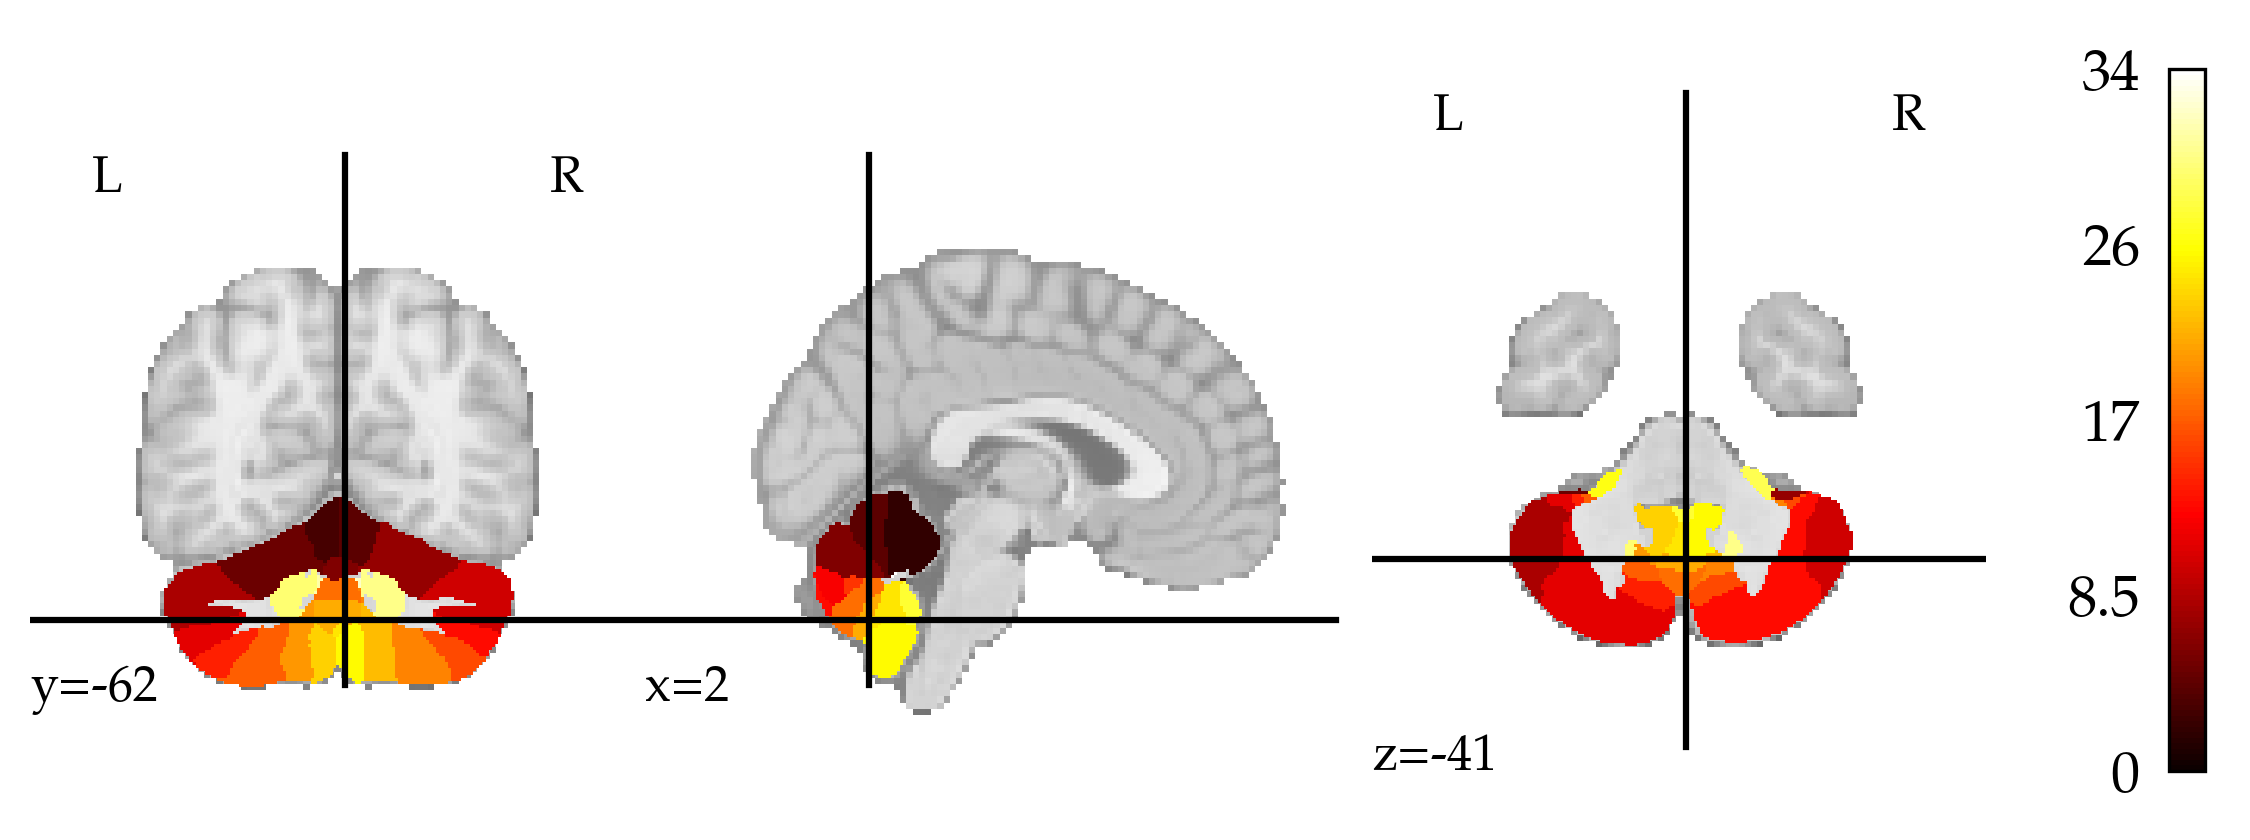

In [65]:
#Extract the data array
jd_data = jd.get_fdata()

# Get unique labels
unique_labels = np.unique(jd_data)

# Print the unique labels and their count
print(f"Unique labels in jd_data: {unique_labels}")
print(f"Number of unique labels: {len(unique_labels)}")
nilearn.plotting.plot_stat_map(jd, threshold=0)

In [66]:
# Check the data type of the loaded atlas
print(f"Data type of Diedrichsen structural atlas before resampling: {jd.get_fdata().dtype}")
# Load the mask image
proper_mask_2mm = nibabel.load(os.path.join(INPUT_DIR, 'maps/D2009_MNI_2mm.nii.gz'))
# Resample the atlas to the mask
jd_mni_2mm = nilearn.image.resample_to_img(jd, proper_mask_2mm)
# Check the data type of the resampled atlas
print(f"Data type of Diedrichsen structural atlas after resampling: {jd_mni_2mm.get_fdata().dtype}")
# Convert the data back to integer if necessary! It is important to check that the labels are still the correct number.
jd_mni_2mm_data = jd_mni_2mm.get_fdata().astype(np.int32)
jd_mni_2mm = nibabel.Nifti1Image(jd_mni_2mm_data, jd_mni_2mm.affine, jd_mni_2mm.header)

Data type of Diedrichsen structural atlas before resampling: float64
Data type of Diedrichsen structural atlas after resampling: float64


In [67]:
# Check unique labels after resampling
unique_labels = np.unique(jd_mni_2mm.get_fdata())
print(f"Unique labels in resampled Diedrichsen atlas: {unique_labels}")
print(f"Number of unique labels: {len(unique_labels)}")
# Check if the number of unique labels is 35 (the number in the original map).
if len(unique_labels) == 35:
    print("The data contains 35 unique labels as expected.")
else:
    print(f"Warning: The data contains {len(unique_labels)} unique labels instead of 35.") # This seems to have removed the background.

Unique labels in resampled Diedrichsen atlas: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32.]
Number of unique labels: 33


### Run variogram-based mean test

In [68]:
if os.path.exists(os.path.join(CORR_DIR, 'z_D2009_dseg_mean.csv')) and os.path.exists(os.path.join(CORR_DIR, 'z_D2009_dseg_p.csv')):
    obs_mean = pd.read_csv(os.path.join(CORR_DIR, 'z_D2009_dseg_mean.csv'), index_col=0)
    p = pd.read_csv(os.path.join(CORR_DIR, 'z_D2009_dseg_p.csv'), index_col=0)
    # Display the dataframes
    print(obs_mean)
    print(p)
else:
    mask_data = proper_mask_2mm.get_fdata().astype('bool')
    jd_mni_2mm_masked = jd_mni_2mm.get_fdata()[mask_data]
    obs_mean = pd.DataFrame(index=range(32)) # Corresponds to the number of parcels (+1, background)
    p = pd.DataFrame(index=range(32))
    surrogates_paths = sorted(glob.glob(os.path.join(OUTPUT_DIR, # takes ~ 1 min.
        'SALE/*/*/uncorr_z_2mm_mask-D2009_MNI_surrogates-variogram_n-1000.npy')
    ))
    for surrogates_path in tqdm(surrogates_paths):
        # Extract subbd using regex for better reliability
        subbd_match = re.search(r'SALE/(.*?)/(.*?)/', surrogates_path)
        if subbd_match:
            subbd = subbd_match.group(2)
        else:
            print(f"Failed to parse subbd from path: {surrogates_path}")
            continue
        # load z map and mask it
        z_2mm = os.path.join(os.path.dirname(surrogates_path), 'uncorr_z_2mm.nii.gz')
        z_2mm_masked = nibabel.load(z_2mm).get_fdata()[mask_data]
        # load surrogates
        surrogates = np.load(surrogates_path)
        obs_mean.loc[:, subbd] = pd.DataFrame(
            {'jd': jd_mni_2mm_masked,
            'z': z_2mm_masked}
        ).groupby('jd').mean().values.flatten()
        # This step makes the calculations a ton faster!
        null_mean = (
            pd.DataFrame(surrogates.T, index=jd_mni_2mm_masked)
            .reset_index(drop=False)
            .groupby('index')
            .mean().values
        )
        p.loc[:, subbd] = (np.abs(null_mean) >= np.abs(obs_mean.loc[:, subbd].values[:, None])).mean(axis=1)
    # label
    obs_mean.index = jd_labels
    p.index = jd_labels
    # Display the resulting DataFrames
    print(obs_mean)
    print(p)
    obs_mean.to_csv(os.path.join(CORR_DIR, 'z_D2009_dseg_mean.csv'))
    p.to_csv(os.path.join(CORR_DIR, 'z_D2009_dseg_p.csv'))

100%|█████████████████████████████████████████████████████████████████████████████████| 38/38 [00:18<00:00,  2.07it/s]

                  Action.Execution.Speech  Action.Execution  \
Left I-IV                    3.673425e-02      1.437183e-01   
Right I-IV                   1.469894e-03      4.422669e-01   
Left V                       6.822775e-01      1.250729e+00   
Right V                      1.267391e-01      2.272680e+00   
Left VI                      1.542946e+00      1.403410e+00   
Vermis VI                    8.551130e-01      1.519308e+00   
Right VI                     9.138021e-01      1.395502e+00   
Left Crus I                  8.349451e-02      1.631760e-02   
Vermis Crus I                2.495999e-19      4.694732e-20   
Right Crus I                 5.990737e-02      8.302724e-21   
Left Crus II                 4.642623e-03      5.491677e-03   
Vermis Crus II               1.212501e-19      4.491711e-20   
Right Crus II                8.275924e-05      2.032840e-03   
Left VIIb                    8.055294e-02      2.803013e-01   
Vermis VIIb                 -1.290493e-18      9.589173

### S12a. Label and plot hierarchically

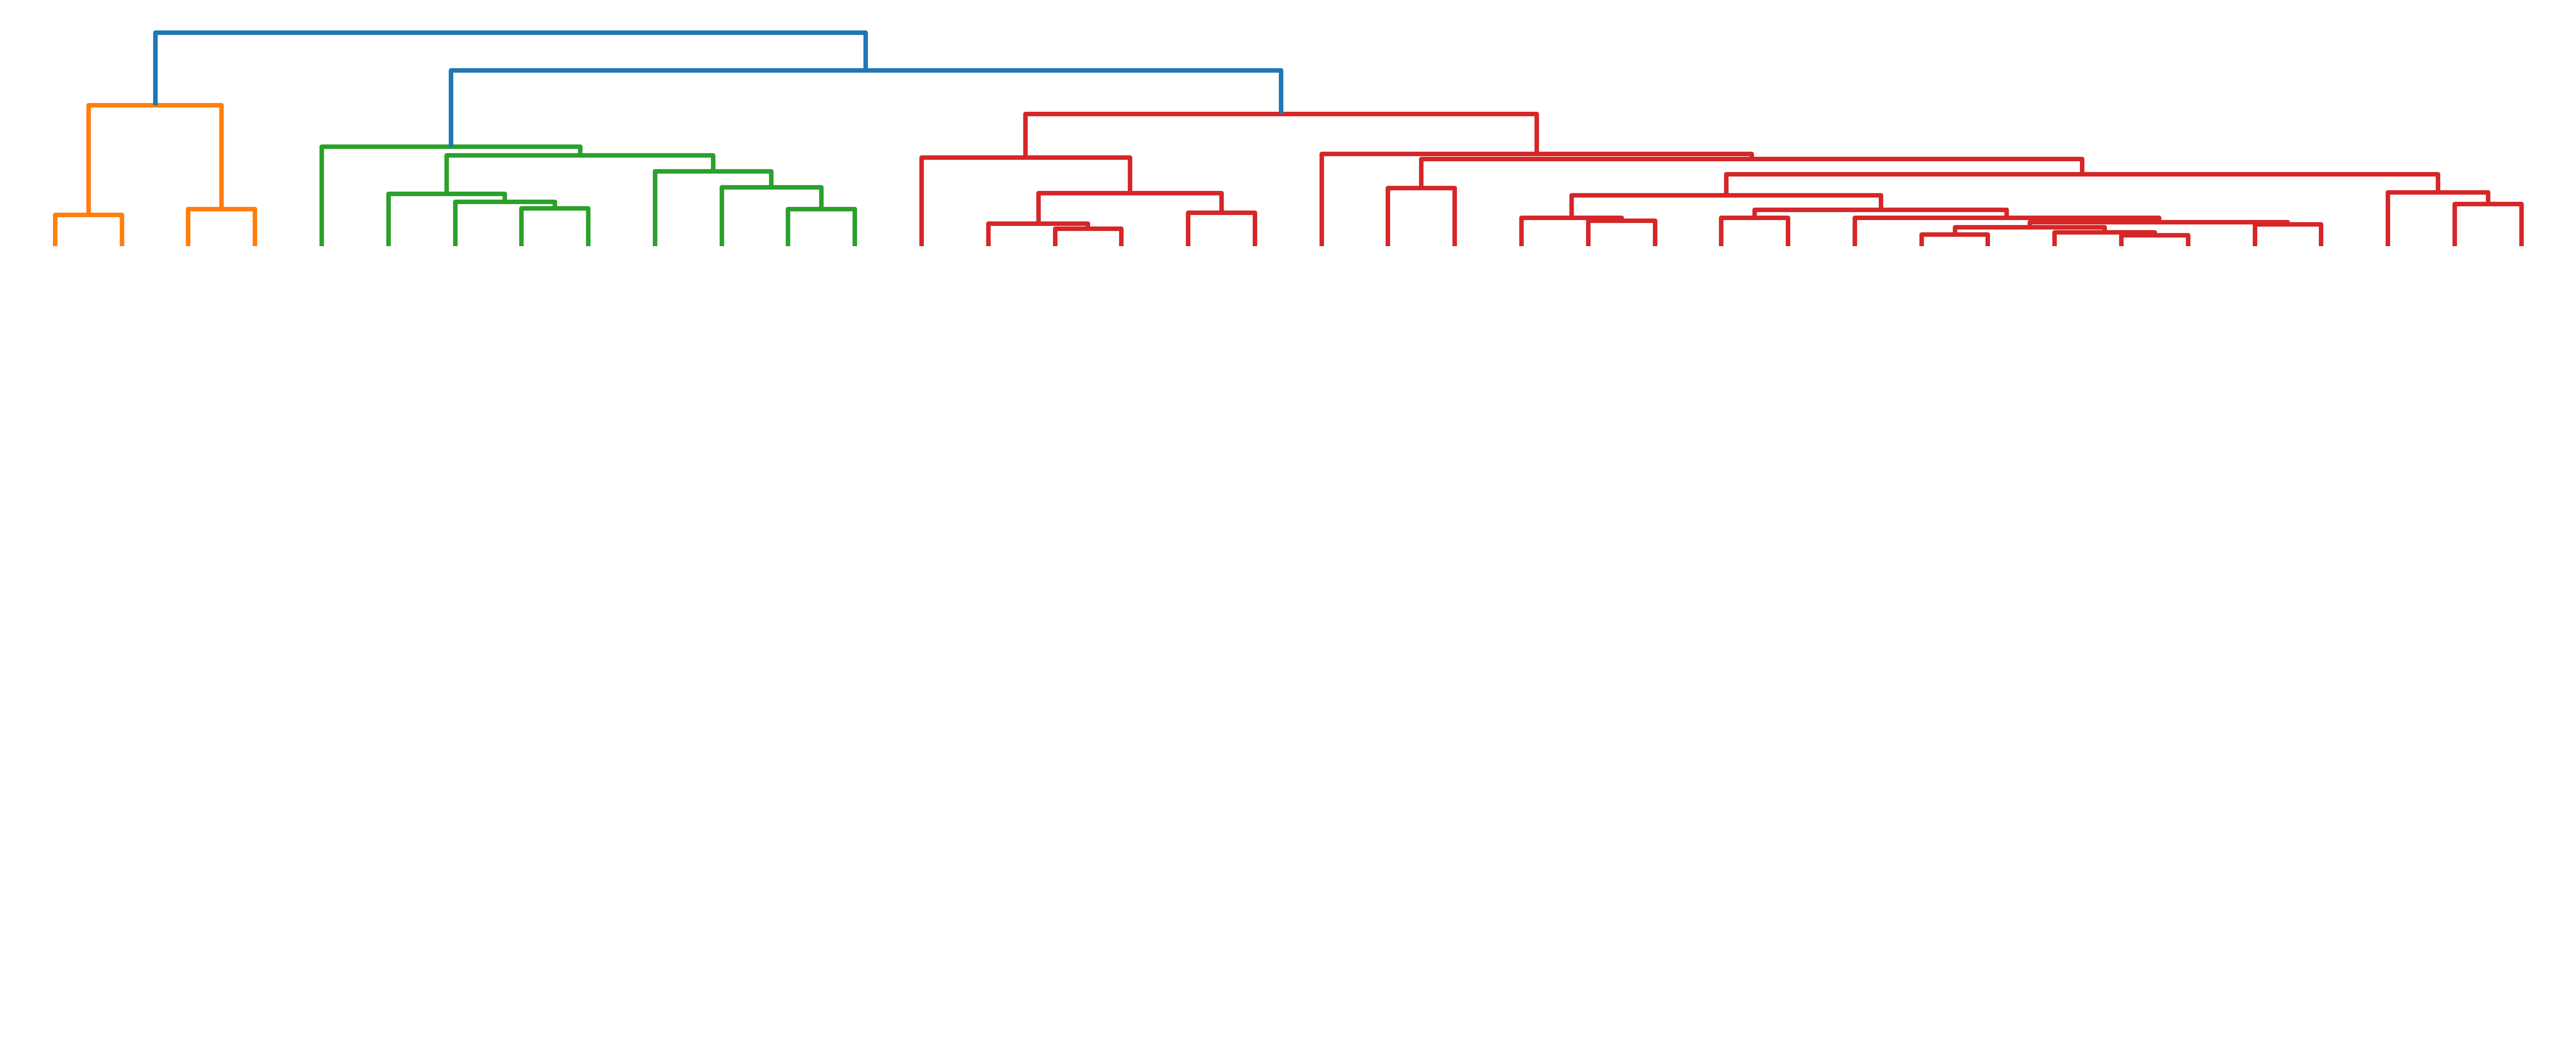

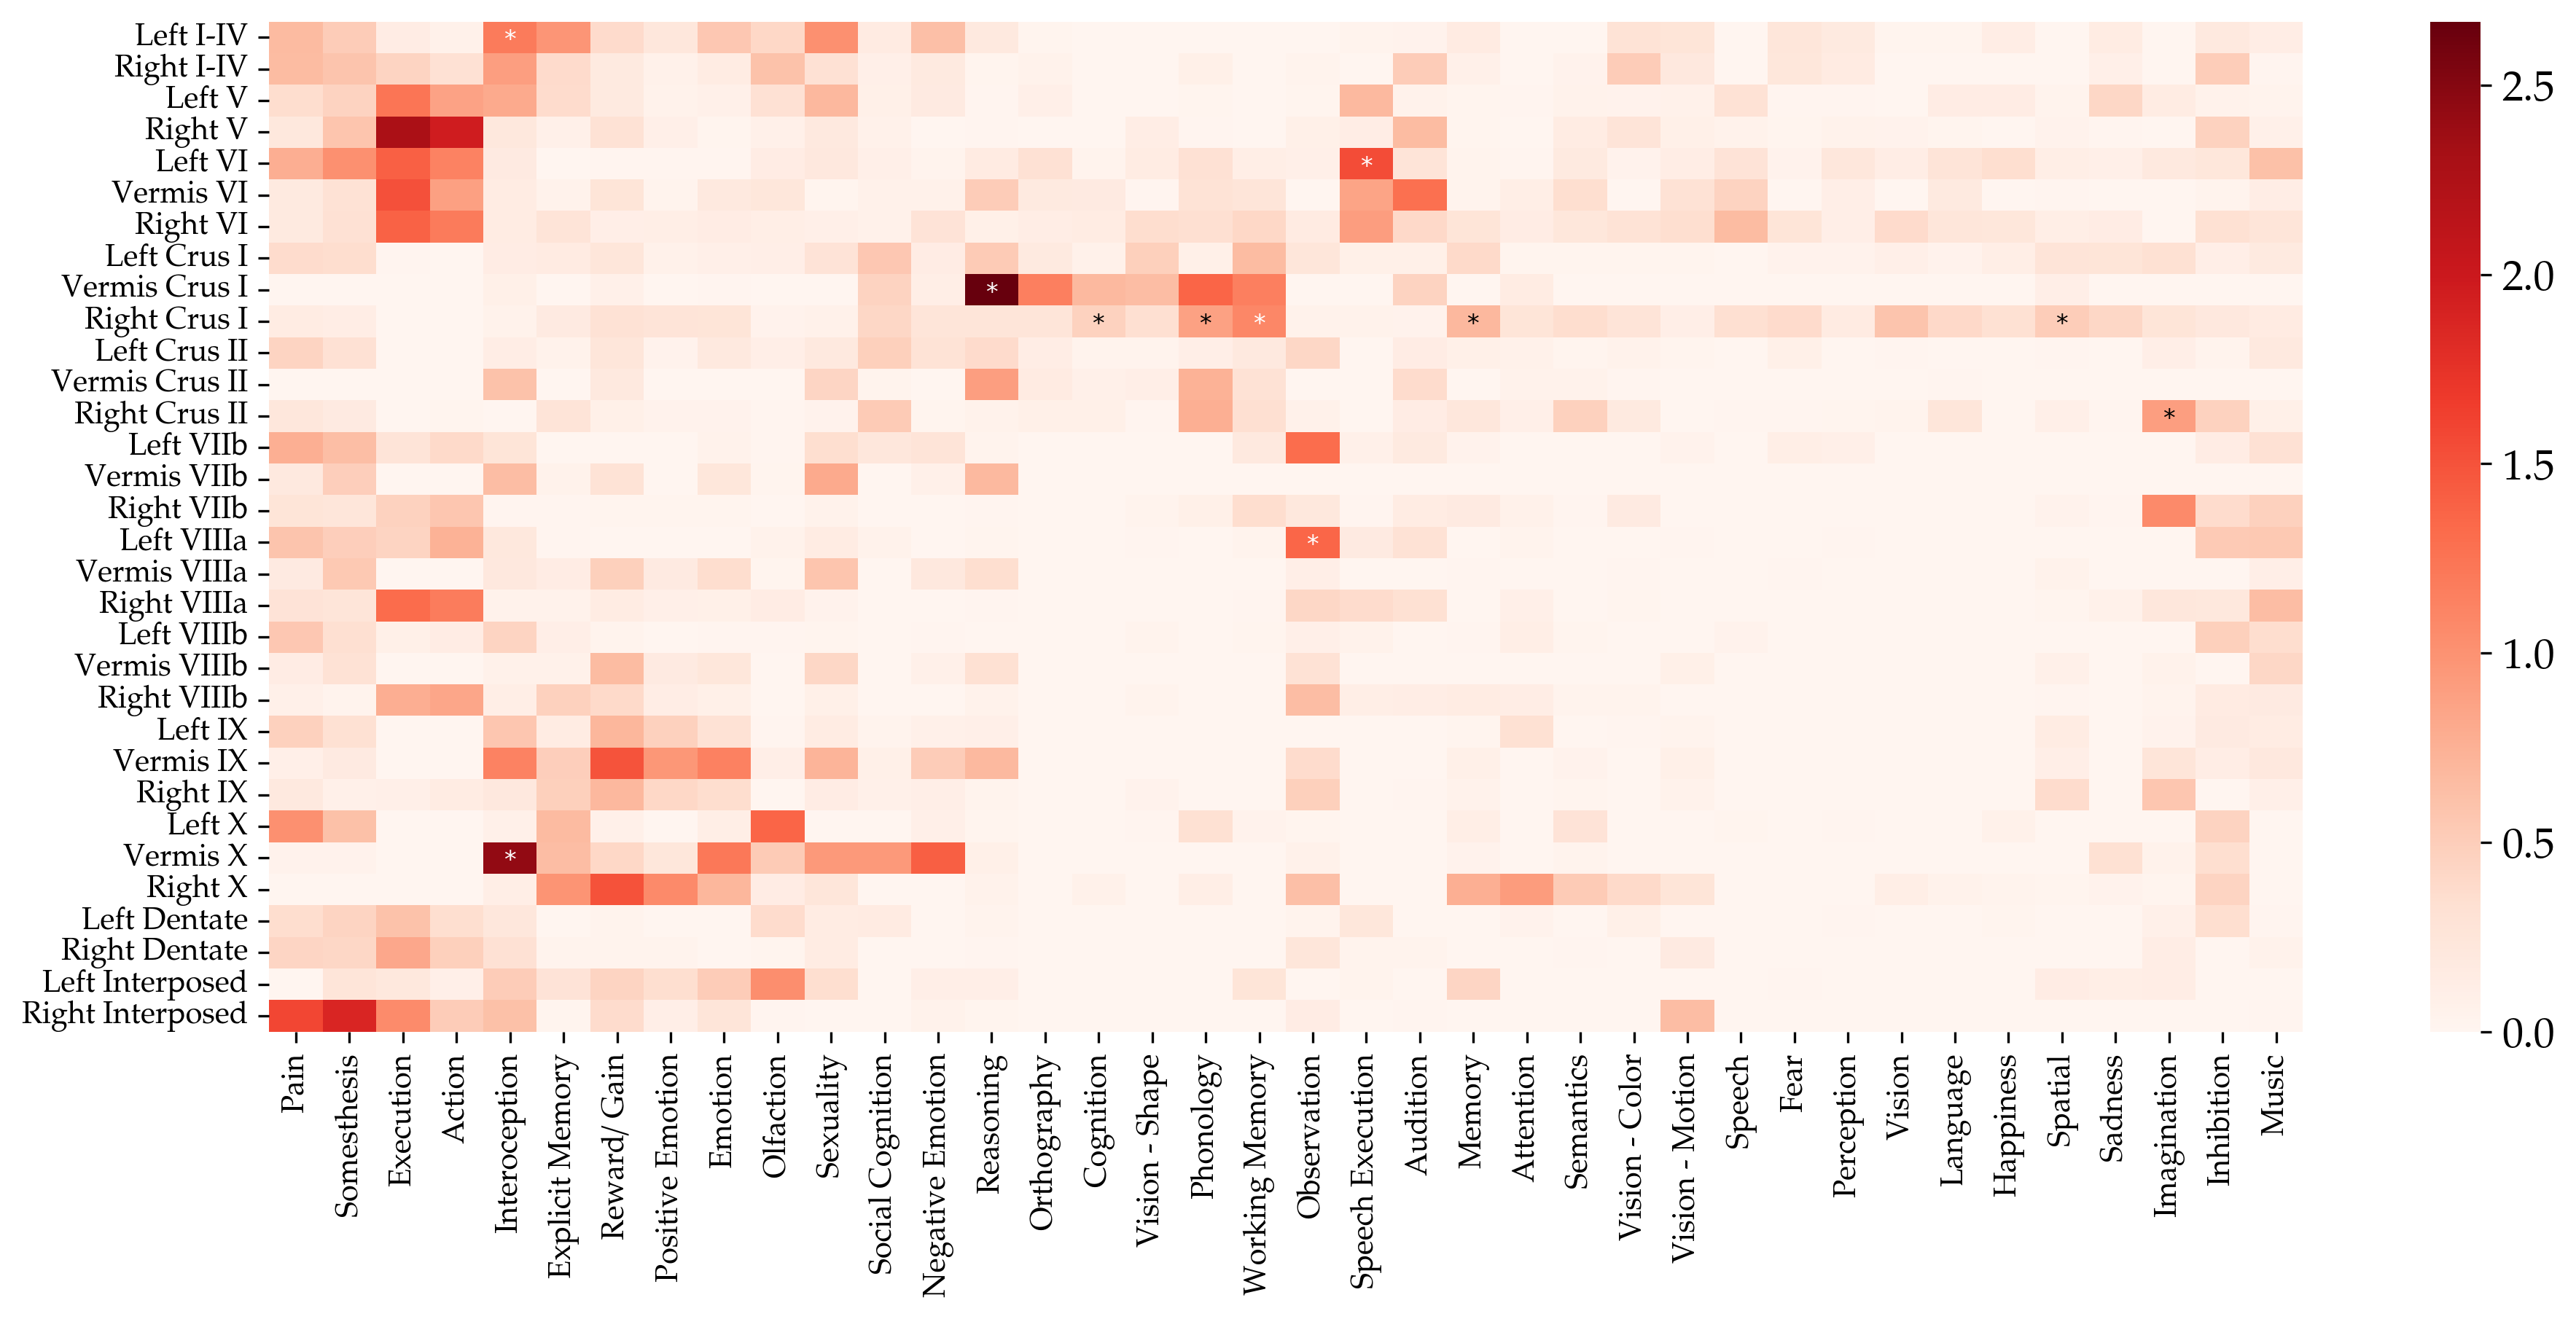

In [69]:
# Perform hierarchical clustering and plot dendrogram
fig, ax = plt.subplots(figsize=(15, 6))
model, dendro, leaf_order = utils.hierarchical_clustering(obs_mean.T, no_plot=False, ax=ax)
ax.set_ylim([-25, ax.get_ylim()[1]])
ax.axis('off')

# reorder the original data
mean_reordered = obs_mean.iloc[:, leaf_order]
# FDR correction
sig_fdr, _ = statsmodels.stats.multitest.fdrcorrection(p.values.flatten())
# reorder 
sig_fdr = pd.DataFrame(sig_fdr.reshape(p.shape), index=p.index, columns=p.columns)
sig_fdr_reordered = sig_fdr.iloc[:, leaf_order]

# plot the reordered data
fig, ax = plt.subplots(figsize=(15, 6))
sns.heatmap(mean_reordered, cmap='Reds',linecolor='.8', ax=ax)
ax.set_xticks(np.arange(p.shape[1])+0.5)
ax.set_xticklabels(utils.bd_labels.loc[mean_reordered.columns].values, rotation=90, horizontalalignment='center', fontsize=10)
ax.set_yticks(np.arange(p.shape[0])+0.5)
ax.set_yticklabels(mean_reordered.index, rotation=0, fontsize=10)
ax.set_ylabel('')
# add the * layer
for x, col in enumerate(mean_reordered.columns):
    for y, row in enumerate(mean_reordered.index):
        if sig_fdr.loc[row, col]:
            text = r'$*$'
            # Conditional color based on the value of r
            text_color = 'white' if mean_reordered.loc[row, col] > 1.0  else 'black'
            ax.text(x+0.5, y+0.6,
                    text, 
                    fontsize=8,
                    color=text_color,
                    horizontalalignment='center', 
                    verticalalignment='center')